# Artificial Intelligence in Industry - One-Hot Kernels for measuring correlation between categorical variables  
# Marcello Mancino 

In [13]:
import random as rn
import numpy as np
import pandas as pd
import seaborn as sns
import time as t
import matplotlib.pyplot as plt
import scipy.stats as ss

from cfair.backends import NumpyBackend
from cfair.metrics.kernel.hgr import DoubleKernelHGR
from ucimlrepo import fetch_ucirepo 

from scipy.linalg import qr # is the last column always removed?

In [14]:
backend = NumpyBackend()

# Cramer's V

This is the bias-corrected version

In [15]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [16]:
def vanilla_cramers_v(confusion_matrix):

    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    return np.sqrt(phi2 / min((k - 1), (r - 1)))

# OHE kernel function

In [17]:
def one_hot_encode(x):
        unique_vals = np.unique(x)
        return np.array([[1 if val == xi else 0 for val in unique_vals] for xi in x]).transpose()

## What happens when a0 and b0 are at None?

In [18]:
x = np.array([[0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0]]).transpose()
print(x)

[[0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 1 0 1]
 [1 0 0 0 0 1 0]]


Nella result:

In [19]:
x = np.stack(x, axis=1)
print(x)

[[0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]]


### Is the last column discarded? (_indices function)

In [20]:
my_delta_independent = 0.2

In [21]:
b = np.ones(shape=(len(x), 1))            
x = np.concatenate((b, x), axis=1)        
# compute the QR factorization
r = qr(x, mode='r')[0]
# build the diagonal of the R matrix (excluding the bias column)
r = np.abs(np.diag(r)[1:])
# independent columns are those having a value higher than the tolerance
mask = r >= my_delta_independent

In [22]:
print(mask)

[ True  True  True False]


In [23]:
x = x - np.mean(x, axis=0)
print(x)

[[ 0.         -0.14285714 -0.14285714 -0.42857143  0.71428571]
 [ 0.         -0.14285714  0.85714286 -0.42857143 -0.28571429]
 [ 0.         -0.14285714 -0.14285714  0.57142857 -0.28571429]
 [ 0.          0.85714286 -0.14285714 -0.42857143 -0.28571429]
 [ 0.         -0.14285714 -0.14285714  0.57142857 -0.28571429]
 [ 0.         -0.14285714 -0.14285714 -0.42857143  0.71428571]
 [ 0.         -0.14285714 -0.14285714  0.57142857 -0.28571429]]


In [24]:
print(type(x))

<class 'numpy.ndarray'>


### Calcolo di a0

In [25]:
my_esp = 1e-9

In [26]:
somma = x.sum(axis=1)
print(somma)

[1.11022302e-16 1.66533454e-16 0.00000000e+00 1.66533454e-16
 0.00000000e+00 1.11022302e-16 0.00000000e+00]


In [27]:
varianza = somma.var(ddof=0)
print(varianza)

5.15677568782868e-33


In [28]:
denominator = np.sqrt(varianza + my_esp) 
print(denominator)

3.1622776601683795e-05


In [29]:
my_a0 = np.ones(4) / denominator
print(my_a0)

[31622.77660168 31622.77660168 31622.77660168 31622.77660168]


# Sample function

In [30]:
def sample(a_list):
    return rn.choice(a_list)

In [31]:
warriors = ["Ultramarine", "Salamander", "White Scar", "Space Wolf", "Raven Guard", "Iron Hand", "Imperial Fist", "Blood Angel", "Dark Angel"]
animals = ["cat", "dog", "wolf", "horse"]

In [32]:
np.unique(warriors)

array(['Blood Angel', 'Dark Angel', 'Imperial Fist', 'Iron Hand',
       'Raven Guard', 'Salamander', 'Space Wolf', 'Ultramarine',
       'White Scar'], dtype='<U13')

In [33]:
np.unique(animals)

array(['cat', 'dog', 'horse', 'wolf'], dtype='<U5')

# One hot Kernel

In [34]:
my_kernel_one_hot = DoubleKernelHGR(
    backend=backend,          # Or any other appropriate backend
    kernel_a=one_hot_encode, # Custom kernel function for variable a
    kernel_b=one_hot_encode, # Custom kernel function for variable b
)

# One hot Kernel with delta

In [35]:
my_kernel_one_hot_with_delta = DoubleKernelHGR(
    backend=backend,          # Or any other appropriate backend
    kernel_a=one_hot_encode, # Custom kernel function for variable a
    kernel_b=one_hot_encode, # Custom kernel function for variable b
    delta_independent=0.2
)

# Polinomial Kernel

In [134]:
polynomial_kernel = DoubleKernelHGR(
    backend=backend,          
    kernel_a=9, 
    kernel_b=4, 
    delta_independent=0.2
)

# Experiments utilities

## General

In [37]:
def compute_corr_and_exec_time(feat1, feat2, kernel = "cramer", init = None, norm = True):

    if kernel == "cramer":
        start_time = t.time()
        confusion_matrix = pd.crosstab(feat1, feat2)
        result = cramers_v(confusion_matrix.values)
        end_time = t.time()
        exec_time = end_time - start_time

    else:
        l1, l2 = len(np.unique(feat1)), len(np.unique(feat2))

        a0, b0 = None, None # Default case is None

        if init == "ones":
            a0 = np.ones(l1)
            b0 = np.ones(l2)
            if norm:
                a0 = a0/l1
                b0 = b0/l2

        elif init == "random":
            a0=np.random.rand(l1)
            b0=np.random.rand(l2)
            if norm:
                a0 = a0/a0.sum()
                b0 = b0/b0.sum()

        elif init == "rel_fr":
            a0 = np.array([ feat1.count(f1_value)/len(feat1) for f1_value in np.unique(feat1)])
            b0 = np.array([ feat2.count(f2_value)/len(feat2) for f2_value in np.unique(feat2)])

        start_time = t.time()
        result = kernel._result(feat1, feat2, kernel_a=True, kernel_b=True, a0=a0, b0=b0)
        end_time = t.time()
            
        exec_time = end_time - start_time

    return result, exec_time

## Experiments

In [38]:
def experiment(dataset_creation_function, kernel):
    results = []

    for i in range(30):

        res_i = {}

        war_i, ani_i = dataset_creation_function()

        result_i_none, exec_time_none = compute_corr_and_exec_time(war_i, ani_i, kernel)

        result_i_ones, exec_time_ones = compute_corr_and_exec_time(war_i, ani_i, kernel, "ones")

        result_i_random, exec_time_random = compute_corr_and_exec_time(war_i, ani_i, kernel, "random")

        result_i_rf, exec_time_rf = compute_corr_and_exec_time(war_i, ani_i, kernel, "rel_fr")

        cramer, exec_time_cramer = compute_corr_and_exec_time(war_i, ani_i)

        res_i['correlation_none'] = result_i_none.value
        res_i['alpha_none'] = result_i_none.alpha
        res_i['beta_none'] = result_i_none.beta
        res_i['time_none'] = exec_time_none

        res_i['correlation_ones'] = result_i_ones.value
        res_i['alpha_ones'] = result_i_ones.alpha
        res_i['beta_ones'] = result_i_ones.beta
        res_i['time_ones'] = exec_time_ones

        res_i['correlation_random'] = result_i_random.value
        res_i['alpha_random'] = result_i_random.alpha
        res_i['beta_random'] = result_i_random.beta
        res_i['time_random'] = exec_time_random

        res_i['correlation_rf'] = result_i_rf.value
        res_i['alpha_rf'] = result_i_rf.alpha
        res_i['beta_rf'] = result_i_rf.beta
        res_i['time_rf'] = exec_time_rf

        res_i['correlation_cramer'] = cramer
        res_i['time_cramer'] = exec_time_cramer

        results.append(res_i)

    return results

In [39]:
def experiment_norm(dataset_creation_function, kernel):
    results = []

    for i in range(30):

        res_i = {}

        war_i, ani_i = dataset_creation_function()

        result_i_ones, exec_time_ones = compute_corr_and_exec_time(war_i, ani_i, kernel, "ones")
        result_i_ones_not_norm, exec_time_ones_not_norm = compute_corr_and_exec_time(war_i, ani_i, kernel, "ones", False)

        result_i_random, exec_time_random = compute_corr_and_exec_time(war_i, ani_i, kernel, "random")
        result_i_random_not_norm, exec_time_random_not_norm = compute_corr_and_exec_time(war_i, ani_i, kernel, "random", False)

        cramer, exec_time_cramer = compute_corr_and_exec_time(war_i, ani_i)

        res_i['correlation_ones'] = result_i_ones.value
        res_i['alpha_ones'] = result_i_ones.alpha
        res_i['beta_ones'] = result_i_ones.beta
        res_i['time_ones'] = exec_time_ones

        res_i['correlation_ones_not_norm'] = result_i_ones_not_norm.value
        res_i['alpha_ones_not_norm'] = result_i_ones_not_norm.alpha
        res_i['beta_ones_not_norm'] = result_i_ones_not_norm.beta
        res_i['time_ones_not_norm'] = exec_time_ones_not_norm

        res_i['correlation_random'] = result_i_random.value
        res_i['alpha_random'] = result_i_random.alpha
        res_i['beta_random'] = result_i_random.beta
        res_i['time_random'] = exec_time_random

        res_i['correlation_random_not_norm'] = result_i_random_not_norm.value
        res_i['alpha_random_not_norm'] = result_i_random_not_norm.alpha
        res_i['beta_random_not_norm'] = result_i_random_not_norm.beta
        res_i['time_random_not_norm'] = exec_time_random_not_norm

        res_i['correlation_cramer'] = cramer
        res_i['time_cramer'] = exec_time_cramer

        results.append(res_i)

    return results

In [40]:
def experiment_delta(dataset_creation_function, kernel):
    results = []

    for i in range(30):

        res_i = {}

        war_i, ani_i = dataset_creation_function()

        result_i_none, exec_time_none = compute_corr_and_exec_time(war_i, ani_i, kernel)

        result_i_rf, exec_time_rf = compute_corr_and_exec_time(war_i, ani_i, kernel, "rel_fr")

        cramer, exec_time_cramer = compute_corr_and_exec_time(war_i, ani_i)

        res_i['correlation_none'] = result_i_none.value
        res_i['alpha_none'] = result_i_none.alpha
        res_i['beta_none'] = result_i_none.beta
        res_i['time_none'] = exec_time_none

        res_i['correlation_rf'] = result_i_rf.value
        res_i['alpha_rf'] = result_i_rf.alpha
        res_i['beta_rf'] = result_i_rf.beta
        res_i['time_rf'] = exec_time_rf

        res_i['correlation_cramer'] = cramer
        res_i['time_cramer'] = exec_time_cramer

        results.append(res_i)

    return results

In [86]:
def experiment_general(dataset_creation_function, kernel1, kernel2):
    results = []

    for i in range(30):

        res_i = {}

        war_i, ani_i = dataset_creation_function(i)

        result_i_none, exec_time_none = compute_corr_and_exec_time(war_i, ani_i, kernel1)

        result_i_rf, exec_time_rf = compute_corr_and_exec_time(war_i, ani_i, kernel2, "rel_fr")

        cramer, exec_time_cramer = compute_corr_and_exec_time(war_i, ani_i)

        res_i['correlation_none'] = result_i_none.value
        res_i['alpha_none'] = result_i_none.alpha
        res_i['beta_none'] = result_i_none.beta
        res_i['time_none'] = exec_time_none

        res_i['correlation_rf'] = result_i_rf.value
        res_i['alpha_rf'] = result_i_rf.alpha
        res_i['beta_rf'] = result_i_rf.beta
        res_i['time_rf'] = exec_time_rf

        res_i['correlation_cramer'] = cramer
        res_i['time_cramer'] = exec_time_cramer

        results.append(res_i)

    return results

In [146]:
def experiment_hot_poly(dataset_creation_function, kernel1, kernel2):
    results = []

    for i in range(30):

        res_i = {}

        war_i, ani_i = dataset_creation_function()

        result_i_poly, exec_time_poly = compute_corr_and_exec_time(war_i, ani_i, kernel1)

        result_i_rf, exec_time_rf = compute_corr_and_exec_time(war_i, ani_i, kernel2, "rel_fr")

        cramer, exec_time_cramer = compute_corr_and_exec_time(war_i, ani_i)

        res_i['correlation_poly'] = result_i_poly.value
        res_i['alpha_poly'] = result_i_poly.alpha
        res_i['beta_poly'] = result_i_poly.beta
        res_i['time_poly'] = exec_time_poly

        res_i['correlation_rf'] = result_i_rf.value
        res_i['alpha_rf'] = result_i_rf.alpha
        res_i['beta_rf'] = result_i_rf.beta
        res_i['time_rf'] = exec_time_rf

        res_i['correlation_cramer'] = cramer
        res_i['time_cramer'] = exec_time_cramer

        results.append(res_i)

    return results

## Plots

### Results

In [41]:
def plot_results(results, target, x_axis_description):

    correlations_none = [res[f'{target}_none'] for res in results]
    correlations_ones = [res[f'{target}_ones'] for res in results]
    correlations_random = [res[f'{target}_random'] for res in results]
    correlations_rf = [res[f'{target}_rf'] for res in results]
    cramers = [res[f'{target}_cramer'] for res in results]

    plt.plot(correlations_none, marker='o', linestyle='--', color='b', label='One Hot Kernel, a0 and b0 None')
    plt.plot(correlations_ones, marker='d', linestyle='--', color='r', label='One Hot Kernel, a0 and b0 ones')
    plt.plot(correlations_random, marker='d', linestyle='--', color='g', label='One Hot Kernel, a0 and b0 random')
    plt.plot(correlations_rf, marker='o', linestyle='--', color='y', label='One Hot Kernel, a0 and b0 rf')
    plt.plot(cramers, marker='o', linestyle='--', color='c', label='Cramer\'s V')
    
    plt.title(f'{target} plot')
    plt.xlabel(x_axis_description)
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.show()

In [42]:
def plot_results_norm(results, target, x_axis_description):

    correlations_ones = [res[f'{target}_ones'] for res in results]
    correlations_ones_not_norm = [res[f'{target}_ones_not_norm'] for res in results]
    correlations_random = [res[f'{target}_random'] for res in results]
    correlations_random_not_norm = [res[f'{target}_random_not_norm'] for res in results]
    cramers = [res[f'{target}_cramer'] for res in results]

    plt.plot(correlations_ones, marker='o', linestyle='--', color='b', label='One Hot Kernel, a0 and b0 ones')
    plt.plot(correlations_ones_not_norm, marker='d', linestyle='--', color='r', label='One Hot Kernel, a0 and b0 ones not normalized')
    plt.plot(correlations_random, marker='d', linestyle='--', color='g', label='One Hot Kernel, a0 and b0 random')
    plt.plot(correlations_random_not_norm, marker='o', linestyle='--', color='y', label='One Hot Kernel, a0 and b0 random not normalized')
    plt.plot(cramers, marker='o', linestyle='--', color='c', label='Cramer\'s V')
    
    plt.title(f'{target} plot')
    plt.xlabel(x_axis_description)
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.show()

In [51]:
def plot_results_delta(results, target, x_axis_description):

    correlations_none = [res[f'{target}_none'] for res in results]
    correlations_rf = [res[f'{target}_rf'] for res in results]
    cramers = [res[f'{target}_cramer'] for res in results]

    plt.plot(correlations_none, marker='o', linestyle='--', color='b', label='One Hot Kernel, a0 and b0 None with delta')
    plt.plot(correlations_rf, marker='o', linestyle='--', color='y', label='One Hot Kernel, a0 and b0 rf with delta')
    plt.plot(cramers, marker='o', linestyle='--', color='c', label='Cramer\'s V')
    
    plt.title(f'{target} plot')
    plt.xlabel(x_axis_description)
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.show()

In [91]:
def plot_results_general(results, target, x_axis_description):

    correlations_none = [res[f'{target}_none'] for res in results]
    correlations_rf = [res[f'{target}_rf'] for res in results]
    cramers = [res[f'{target}_cramer'] for res in results]

    plt.plot(correlations_none, marker='o', linestyle='--', color='b', label='One Hot Kernel, a0 and b0 None with delta')
    plt.plot(correlations_rf, marker='o', linestyle='--', color='y', label='One Hot Kernel, a0 and b0 rf without delta')
    plt.plot(cramers, marker='o', linestyle='--', color='c', label='Cramer\'s V')
    
    plt.title(f'{target} plot')
    plt.xlabel(x_axis_description)
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.show()

In [141]:
def plot_results_hot_poly(results, target, x_axis_description):

    correlations_poly = [res[f'{target}_poly'] for res in results]
    correlations_rf = [res[f'{target}_rf'] for res in results]
    cramers = [res[f'{target}_cramer'] for res in results]

    plt.plot(correlations_poly, marker='o', linestyle='--', color='b', label='Polynomial Kernel, a0 and b0 None with delta')
    plt.plot(correlations_rf, marker='o', linestyle='--', color='y', label='One Hot Kernel, a0 and b0 rf without delta')
    plt.plot(cramers, marker='o', linestyle='--', color='c', label='Cramer\'s V')
    
    plt.title(f'{target} plot')
    plt.xlabel(x_axis_description)
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.show()

### Coefficients

In [43]:
def plot_coefficients(results, coeff, values, x_axis_description, absolute = True):
    
    ordered_val = np.unique(values)
    l = len(ordered_val)

    plt.figure(figsize=(20, 20))

    for i in range(l):

        c_none = [res[f'{coeff}_none'][i] for res in results]
        c_ones = [res[f'{coeff}_ones'][i] for res in results]       
        c_random = [res[f'{coeff}_random'][i] for res in results]
        c_rf = [res[f'{coeff}_rf'][i] for res in results]

        if absolute:
            c_none = list(map(abs, c_none))
            c_ones = list(map(abs, c_ones))
            c_random = list(map(abs, c_random))
            c_rf = list(map(abs, c_rf))

        plt.subplot(3, 3, i+1)
        
        plt.plot(c_none, marker='o', linestyle='--', color='b', label=f'{coeff} None')
        plt.plot(c_ones, marker='o', linestyle='--', color='r', label=f'{coeff} ones')
        plt.plot(c_random, marker='o', linestyle='--', color='g', label=f'{coeff} random')
        plt.plot(c_rf, marker='o', linestyle='--', color='y', label=f'{coeff} rf')

        plt.xlim(0, 30)
        plt.ylim(0, 1)

        plt.title(f'{coeff}{str(i+1)} - {ordered_val[i]}')
        plt.xlabel(x_axis_description)
        plt.ylabel(coeff)
        plt.legend()
        plt.grid(True)

    plt.show()

In [64]:
def plot_coefficients_norm(results, coeff, values, x_axis_description, absolute = True):
    
    ordered_val = np.unique(values)
    l = len(ordered_val)

    plt.figure(figsize=(20, 20))

    for i in range(l):

        c_ones = [res[f'{coeff}_ones'][i] for res in results]
        c_ones_not_norm = [res[f'{coeff}_ones_not_norm'][i] for res in results]       
        c_random = [res[f'{coeff}_random'][i] for res in results]
        c_random_not_norm = [res[f'{coeff}_random_not_norm'][i] for res in results]

        if absolute:
            c_ones = list(map(abs, c_ones))
            c_ones_not_norm = list(map(abs, c_ones_not_norm))
            c_random = list(map(abs, c_random))
            c_random_not_norm = list(map(abs, c_random_not_norm))

        plt.subplot(3, 3, i+1)
        
        plt.plot(c_ones, marker='o', linestyle='--', color='b', label=f'{coeff} ones')
        plt.plot(c_ones_not_norm, marker='o', linestyle='--', color='r', label=f'{coeff} ones not normalized')
        plt.plot(c_random, marker='o', linestyle='--', color='g', label=f'{coeff} random')
        plt.plot(c_random_not_norm, marker='o', linestyle='--', color='y', label=f'{coeff} random not normalized')

        plt.xlim(0, 30)
        plt.ylim(0, 1)

        plt.title(f'{coeff}{str(i+1)} - {ordered_val[i]}')
        plt.xlabel(x_axis_description)
        plt.ylabel(coeff)
        plt.legend()
        plt.grid(True)

    plt.show()

In [71]:
def plot_coefficients_delta(results, coeff, values, x_axis_description, absolute = True, zoom = None):
    
    ordered_val = np.unique(values)
    l = len(ordered_val)

    plt.figure(figsize=(20, 20))

    for i in range(l):

        c_none = [res[f'{coeff}_none'][i] for res in results]      
        c_rf = [res[f'{coeff}_rf'][i] for res in results]

        if absolute:
            c_none = list(map(abs, c_none))
            c_rf = list(map(abs, c_rf))

        plt.subplot(3, 3, i+1)
        
        plt.plot(c_none, marker='o', linestyle='--', color='b', label=f'{coeff} None with delta')
        plt.plot(c_rf, marker='d', linestyle='--', color='y', label=f'{coeff} rf with delta')

        plt.xlim(0, 30)
        if zoom != None:
            plt.ylim(0, zoom)
        else:
            plt.ylim(0, 1)

        plt.title(f'{coeff}{str(i+1)} - {ordered_val[i]}')
        plt.xlabel(x_axis_description)
        plt.ylabel(coeff)
        plt.legend()
        plt.grid(True)

    plt.show()

In [93]:
def plot_coefficients_general(results, coeff, values, x_axis_description, absolute = True, zoom = None):
    
    ordered_val = np.unique(values)
    l = len(ordered_val)

    plt.figure(figsize=(20, 20))

    for i in range(l):

        c_none = [res[f'{coeff}_none'][i] for res in results]      
        c_rf = [res[f'{coeff}_rf'][i] for res in results]

        if absolute:
            c_none = list(map(abs, c_none))
            c_rf = list(map(abs, c_rf))

        plt.subplot(3, 3, i+1)
        
        plt.plot(c_none, marker='o', linestyle='--', color='b', label=f'{coeff} None with delta')
        plt.plot(c_rf, marker='d', linestyle='--', color='y', label=f'{coeff} rf without delta')

        plt.xlim(0, 30)
        if zoom != None:
            plt.ylim(0, zoom)
        else:
            plt.ylim(0, 1)

        plt.title(f'{coeff}{str(i+1)} - {ordered_val[i]}')
        plt.xlabel(x_axis_description)
        plt.ylabel(coeff)
        plt.legend()
        plt.grid(True)

    plt.show()

In [154]:
def plot_coefficients_hot_poly(results, coeff, values, x_axis_description, absolute = True, zoom = None):
    
    ordered_val = np.unique(values)
    l = len(ordered_val)

    plt.figure(figsize=(20, 20))

    for i in range(l):

        c_poly = [res[f'{coeff}_poly'][i] for res in results]      
        c_rf = [res[f'{coeff}_rf'][i] for res in results]

        if absolute:
            c_poly = list(map(abs, c_poly))
            c_rf = list(map(abs, c_rf))

        plt.subplot(3, 3, i+1)
        
        plt.plot(c_poly, marker='o', linestyle='--', color='b', label=f'{coeff} polynomial, None with delta')
        plt.plot(c_rf, marker='d', linestyle='--', color='y', label=f'{coeff} one-hot, rf without delta')

        plt.xlim(0, 30)
        if zoom != None:
            plt.ylim(0, zoom)
        else:
            plt.ylim(0, 1)

        plt.title(f'{coeff}{str(i+1)} - {ordered_val[i]}')
        plt.xlabel(x_axis_description)
        plt.ylabel(coeff)
        plt.legend()
        plt.grid(True)

    plt.show()

# Utilities for Real Data

In [237]:
def plot_hist(dataset, feature, relative_feature = None, relative_value = None):

    title = f'{feature} distribution'

    if relative_feature!=None:
        
        title = title + f' relative to {relative_feature} equal to {relative_value}'
        dataset = dataset[ dataset[relative_feature] == relative_value ]
  
    plt.figure(figsize=(20,10))

    sns.countplot(data=dataset, x=feature, order=np.unique(dataset[feature]), stat="proportion")
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(title)

    plt.show()

In [46]:
def compute_correlation(dataset, feat1, feat2, kernel):
    
    sorted_feat1 = np.unique(dataset[feat1])
    sorted_feat2 = np.unique(dataset[feat2])


    feat1_rf_a0 = np.array([ len(dataset[ dataset[feat1] == value ])/len(dataset) for value in sorted_feat1])
    feat2_rf_b0 = np.array([ len(dataset[ dataset[feat2] == value ])/len(dataset) for value in sorted_feat2])
   
    return kernel._result(dataset[feat1], dataset[feat2], kernel_a=True, kernel_b=True, a0=feat1_rf_a0, b0=feat2_rf_b0)

In [228]:
def my_sort(couple):
    return abs(couple[1]) 

def print_coefficients(values, coefficients):

    max_len = max(len(value) for value in values)

    to_print = []
    
    for value, coefficient in zip(values, coefficients):
        to_print.append((value, coefficient))

    to_print.sort(key=my_sort, reverse=True)

    for couple in to_print:
        print("{:<{width}} : {}".format(couple[0], couple[1], width=max_len))

    

def print_coefficients_alphabetical(values, coefficients):

    max_len = max(len(value) for value in values)

    for value, coefficient in zip(values, coefficients):
        print("{:<{width}} : {}".format(value, coefficient, width=max_len))

# 0.1 Overall impact of a0 and b0 initialization

In this experiment i wanted to check how the behaviour of the kernel changes w.r.t. the way in which the coefficients are initialized.  
In particular i've tried four different initializations:

1. **None**: the coefficients are inizialized with an array of ones divided by the standard deviation of the row-wise sums of the kernel (adjusted by a small constant in order to avoid divisions by 0 or very small numbers). With one-hot kernels this translates into a vector of very high numbers (the order of magnitude is ~1e3).
2. **All ones**: the coefficients are all set at 1, and then the vector is normalized.
3. **Random**: the coefficients are set to random numbers in the interval [0, 1), and then the vector is normalized. 
4. **Relative Frequency (rf)**: the coefficients are initialized with the relative frequency of the corresponding values in the dataset (normalized by definition).

## Dataset description

I'll create 30 dataset of 50000 samples for each experiment: in the first ones i will do so in order to check if the kernels behave in a consistent way, and to be reasonably sure that their behavior is not due to chance. In the latter experiments i will do so because some characteristic of the dataset, be it its distribution or the correlation between its variables, will change from dataset to dataset in a certain, controlled way.  
This baseline dataset is such that two couples of values are strongly correlated, while the other ones are all random.

In [49]:
def create_dataset():

    war_i = []
    ani_i = []

    for j in range(50000):
            
        warrior=sample(warriors)

        war_i.append(warrior)

        if warrior == "White Scar":
            anim = "horse"
        elif warrior == "Raven Guard":
            anim="cat"
        else:
            anim = sample(animals)

        ani_i.append(anim)

    return war_i, ani_i

In [53]:
results_initialization = experiment(create_dataset, my_kernel_one_hot)

## 1. Correlations plots

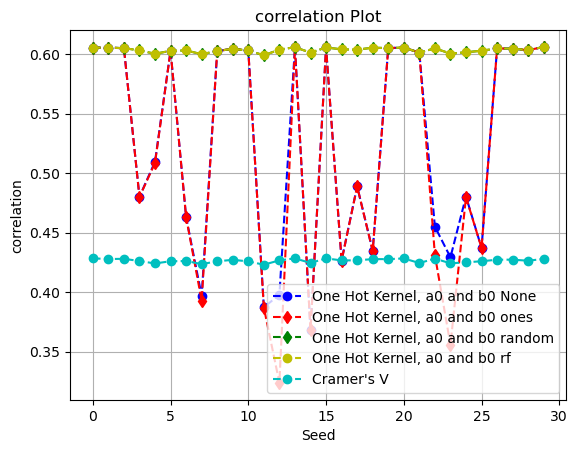

In [54]:
plot_results(results_initialization, "correlation", "Seed")

As we can se the "ones" and "None" initializations are really unstable.

## 2. Execution times

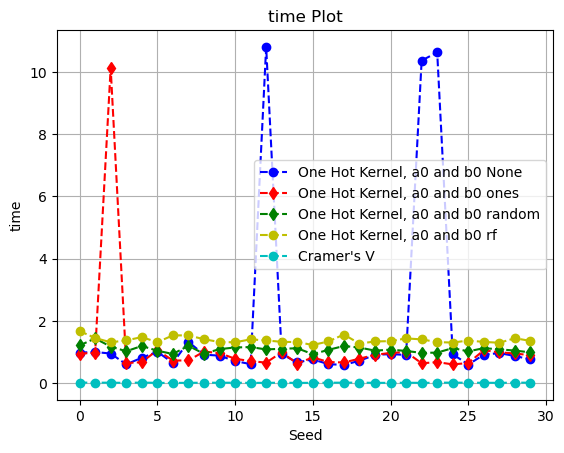

In [55]:
plot_results(results_initialization, "time", "Seed")

The time is roughly the same for all initializations, except for "None" and "ones".

## 3. Alphas plots (abs values)

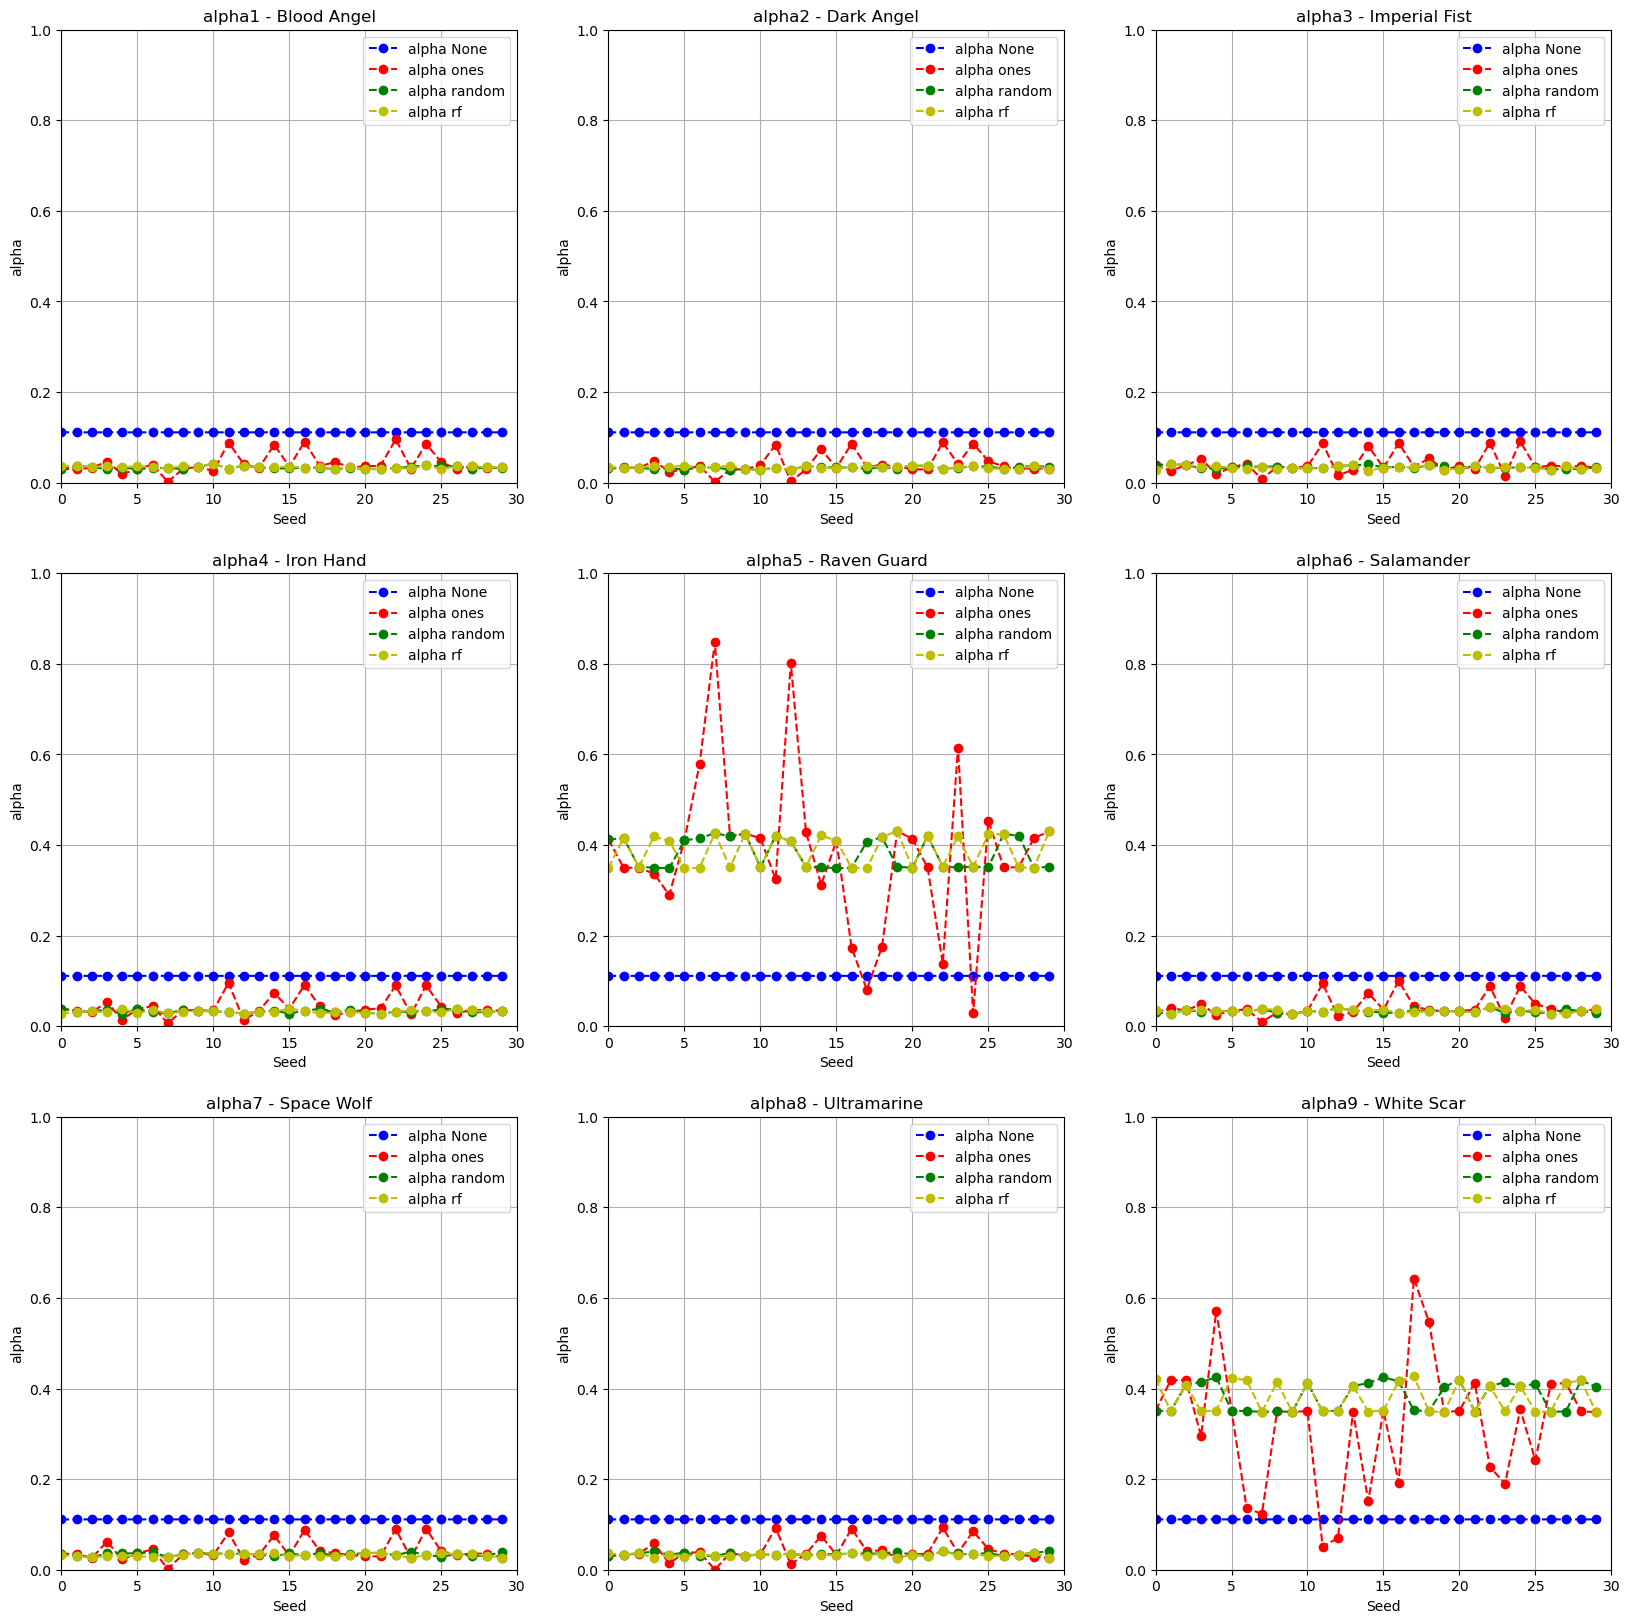

In [56]:
plot_coefficients(results_initialization, "alpha", warriors, "Seed")

Abs values of non correlated coefficients tend toward 0, while abs values of correlated coefficients are sensibly higher (~0.4 in this case, for alpha 5 and 9).

## 4. Betas plots (abs values)

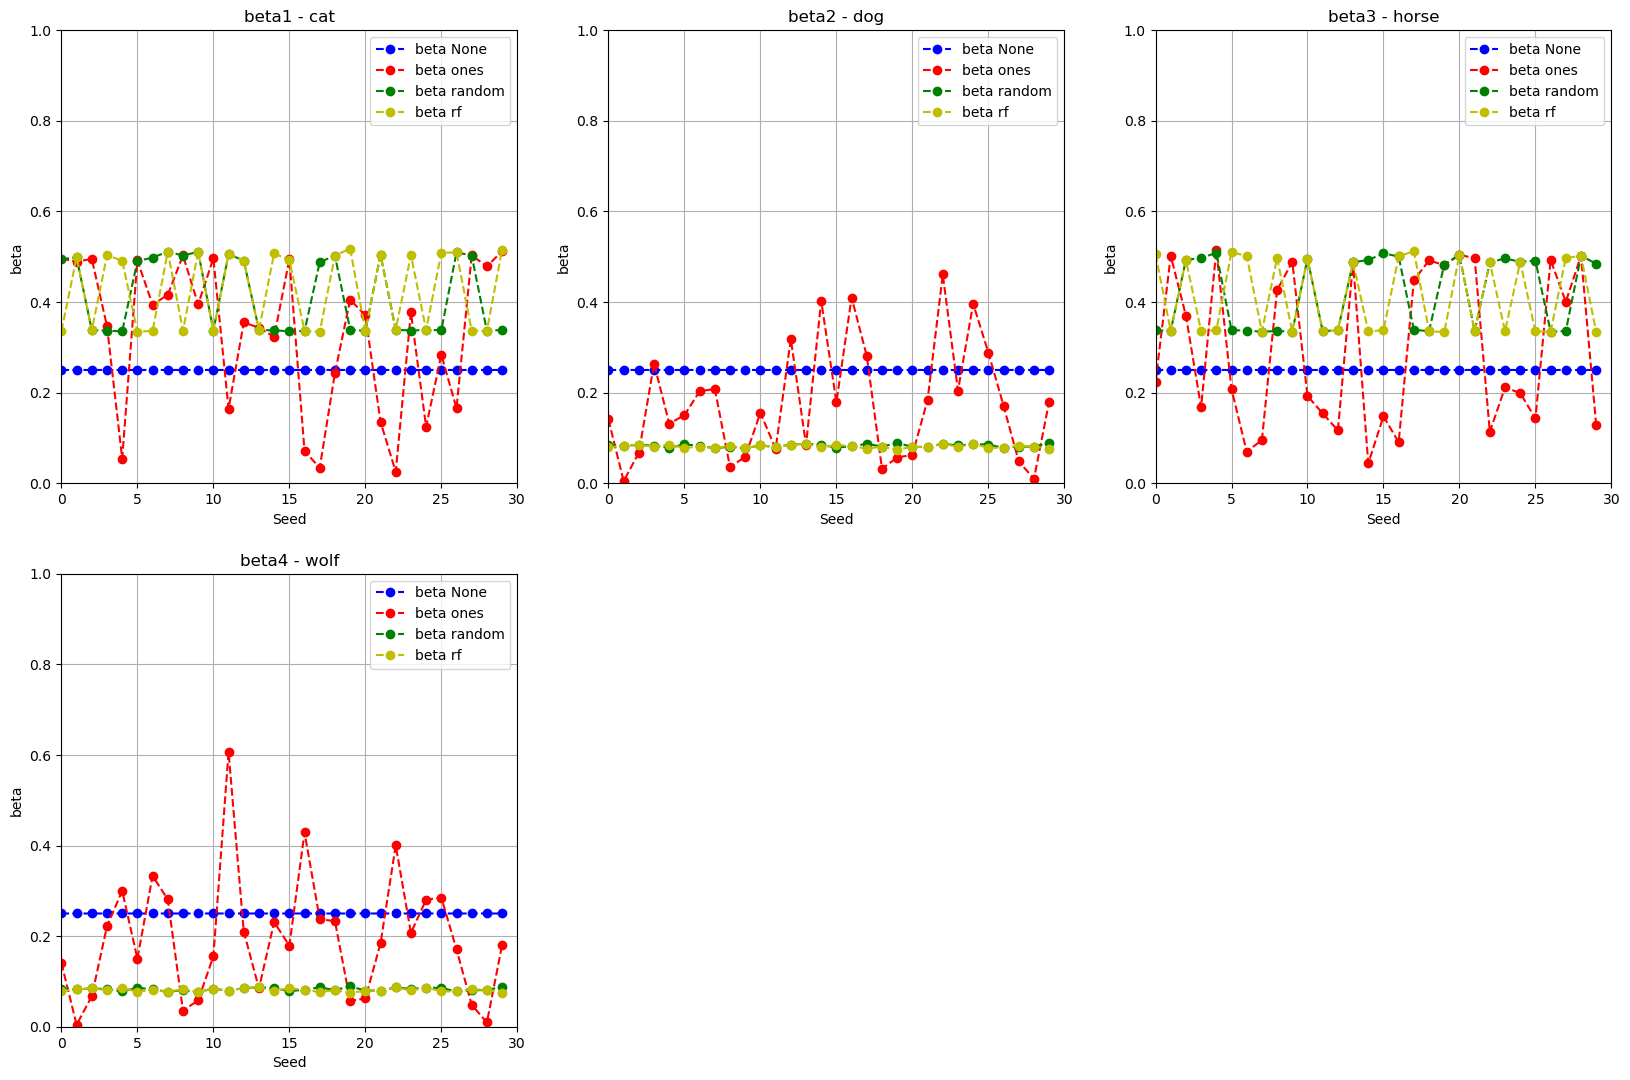

In [57]:
plot_coefficients(results_initialization, 'beta', animals, "Seed")

# 0.2 The importance of Normalizing

I've checked what does change if we normalize or not. Since "rf" is normalized by definition and both "None" and "all ones" would end up in the same vector if normalized since each one of them is a vector with all equal components (the ones of "None" are just much bigger), i've decided to run this experiment with the following initializations:  

1. **Ones**: both normalized and not normalized.
2. **Random**: same as "ones".

## Dataset description

The dataset is the same used in experiment 0.1

In [77]:
results_norm = experiment_norm(create_dataset, my_kernel_one_hot)

## 1. Correlations plots

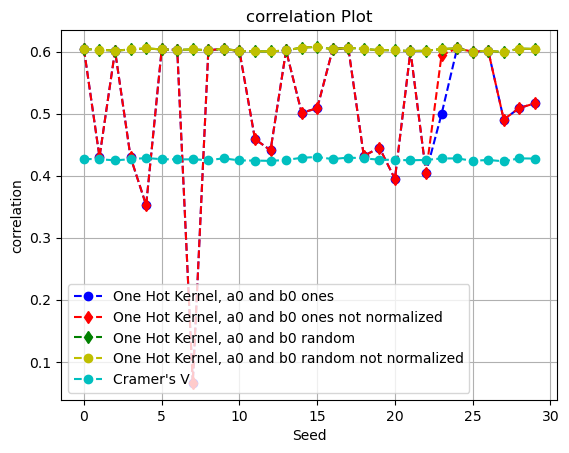

In [78]:
plot_results_norm(results_norm, "correlation", "Seed")

It is interesting to note how sometimes the algorithm "collapses" to Cramer's V.

## 2. Execution times

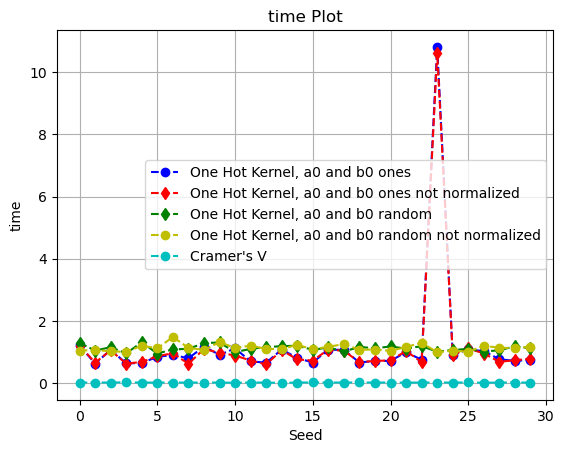

In [80]:
plot_results_norm(results_norm, "time", "Seed")

## 3. Alphas plots (abs values)

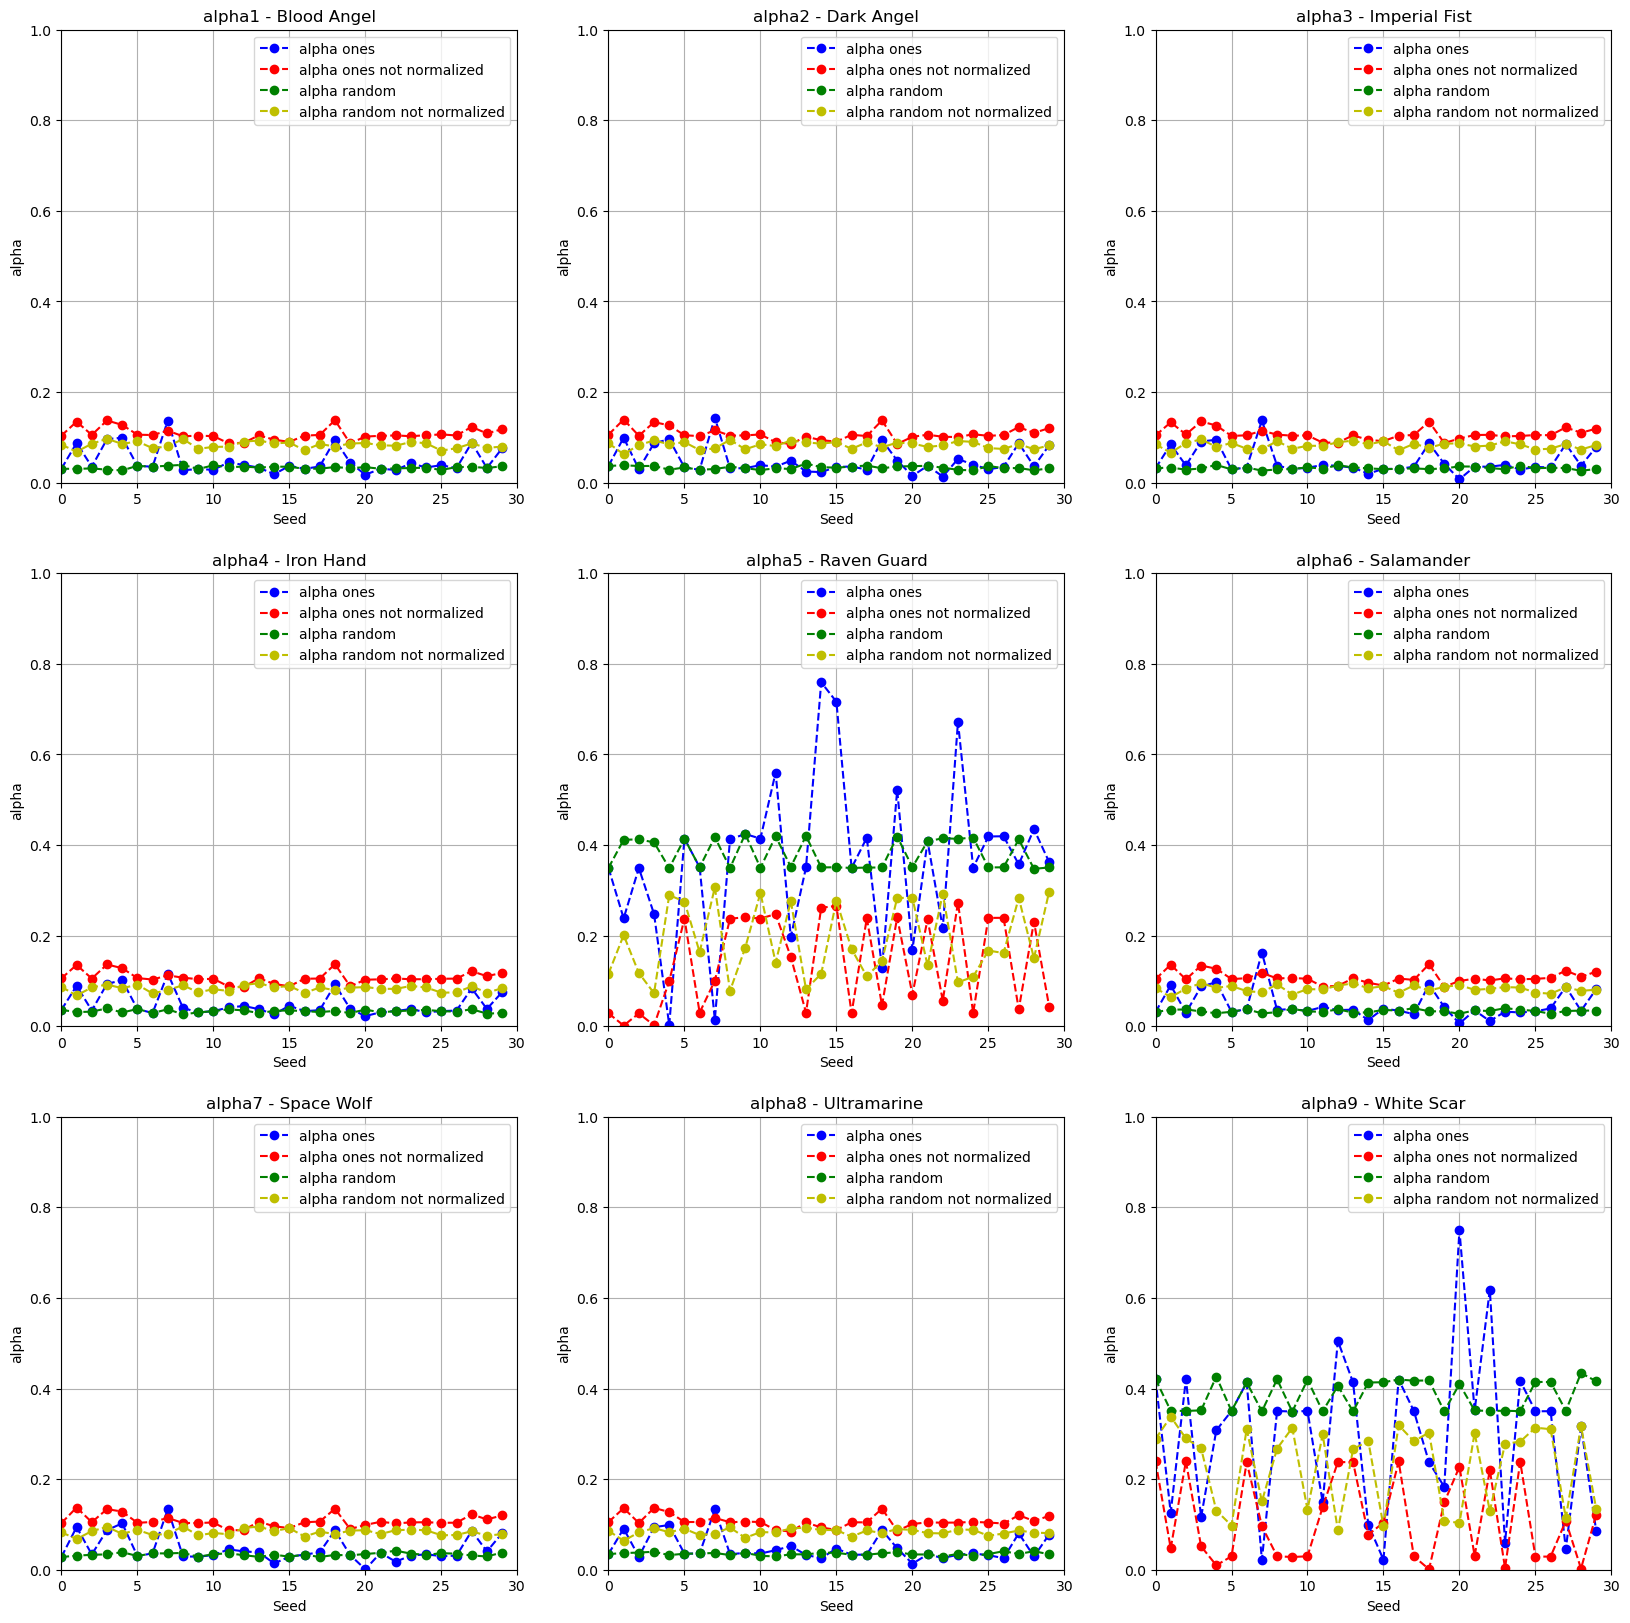

In [86]:
plot_coefficients_norm(results_norm, "alpha", warriors, "Seed")

Normalization makes the coefficients behave in a more interpretable way: the ones relative to non correlated values are closer to 0, while the ones relative to correlated values are further from 0.

## 4. Betas plots (abs values)

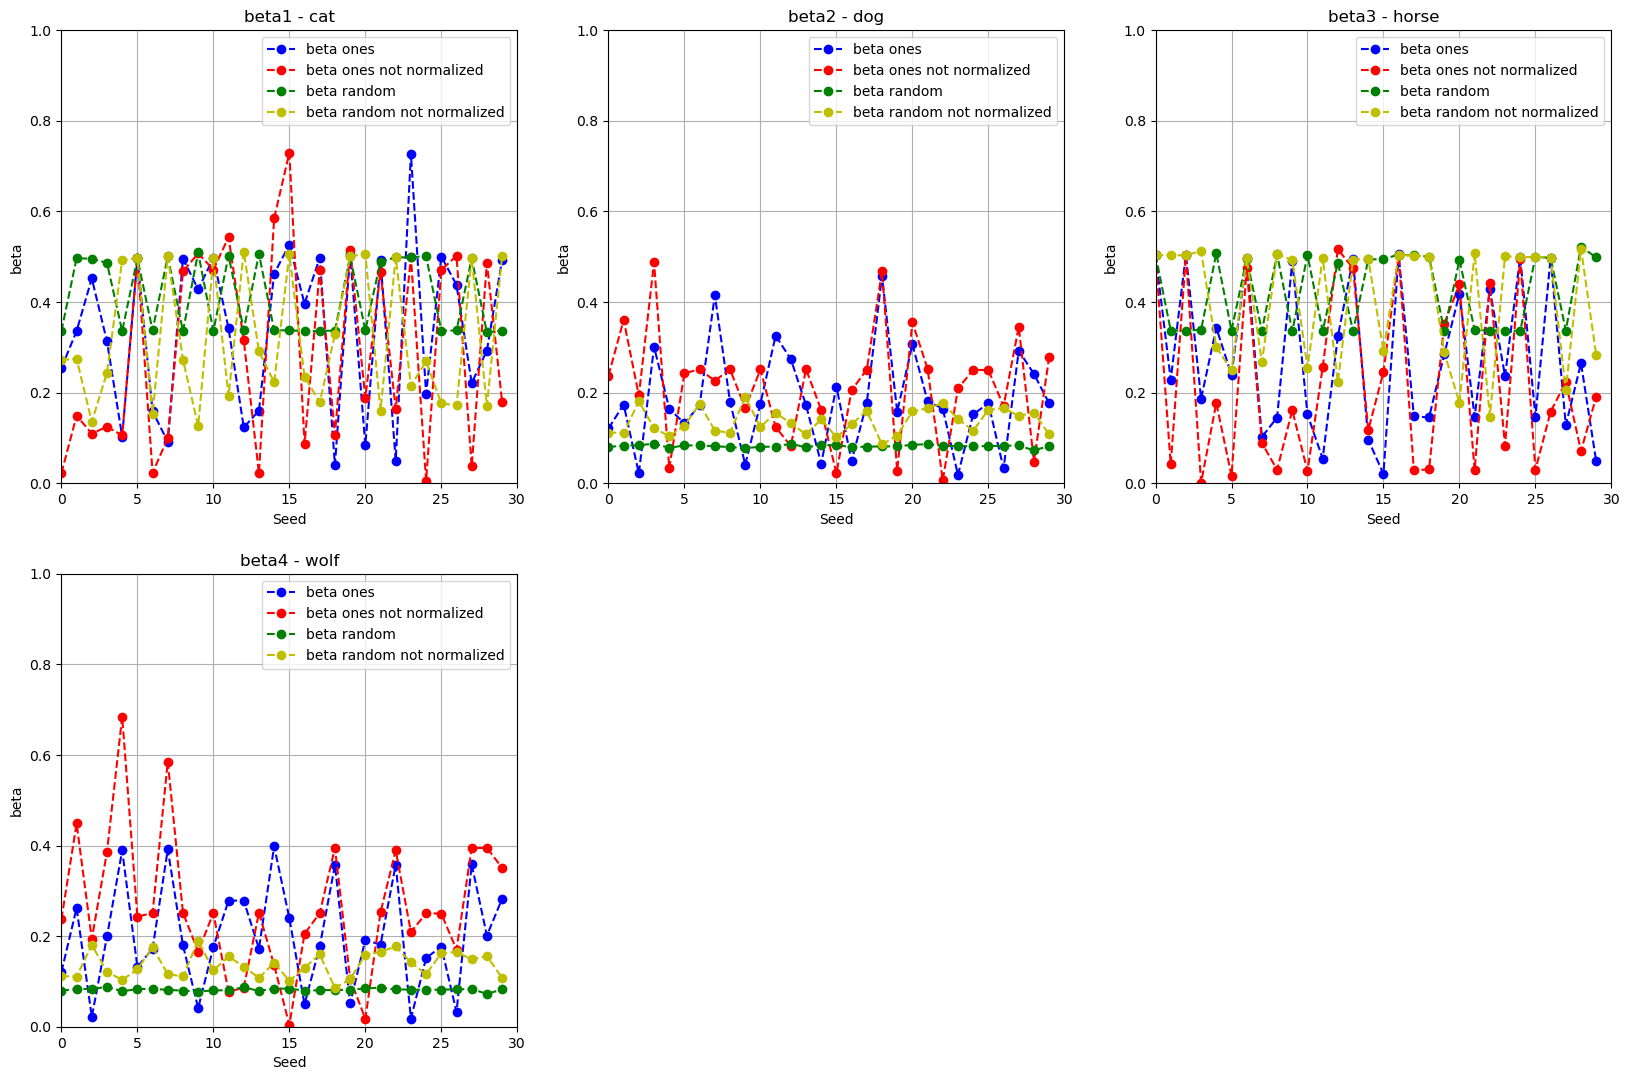

In [88]:
plot_coefficients_norm(results_norm, "beta", animals, "Seed")

# 0.3 Using Delta to stabilize the computation

From the previous experiments i noticed how when the values of the initial coefficient vector are all equal (this happens with the initializations "None" and "all ones"), the computation is unstable. This is probably due to the fact that with one-hot kernels one column can always be reconstructed by the other ones, and so **there is always a linearly dependant column**. If we do not remove said column, the solutions are infinite and thus sometimes the algorithm gets "lost": sometimes it will take a lot of time in order to compute the "correct" value, while sometimes it will take less time but end up computing an apparently underestimated correlation.  
I also noted that this does not happen when we initialize with random values or with the relative frequency of the values in the dataset: probably this is due to the fact that in this way we are "biasing" the algorithm and so even if the solutions are indeed infinite, the starting point makes it consistently converge on the same correlation and coefficients values.  
I've run this experiment with the following initializations, eliminating the last column for all of them.

1. **None**: I've chosen this to represent the unstable initializations because i wanted to check if by using delta the coefficients would move away from their initial value.
2. **Relative Frequency (rf)**: Since both random and rf initializations had virtually the same behaviour, i've chosen this to represent them both.

## Dataset Description

The dataset is the same used in experiment 0.1 and 0.2.

In [50]:
results_delta = experiment_delta(create_dataset, my_kernel_one_hot_with_delta)

## 1. Correlations plots

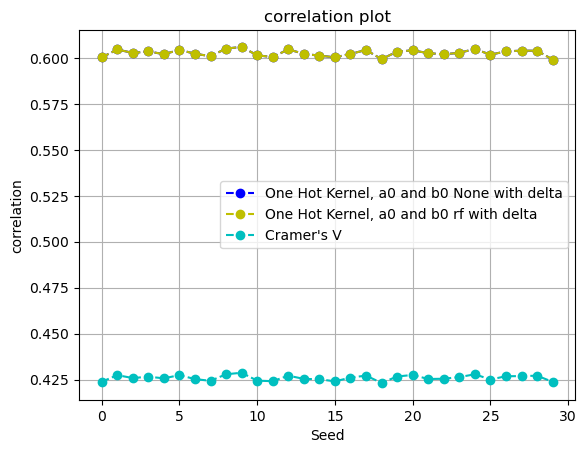

In [75]:
plot_results_delta(results_delta, "correlation", "Seed")

The "None" initialization is now finally stable, and it consistently computes the same value as "rf".

## 2. Execution times

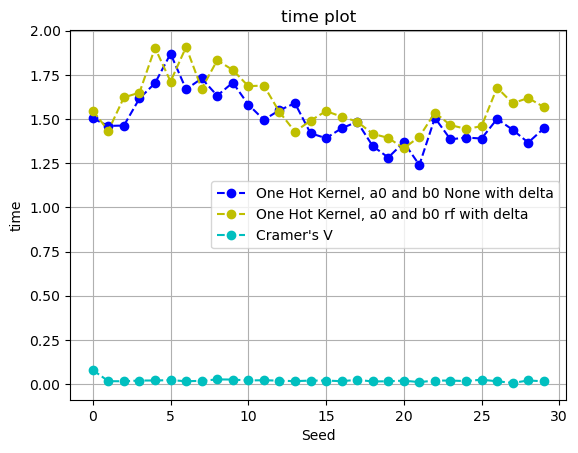

In [67]:
plot_results_delta(results_delta, "time", "Seed")

The computation time is a lot more stable now for "None": thanks to the removal of the linear dependant column now the solution is just one, and thus the algorithm can "focus" on that one, instead of being sometimes baited by other, sometimes apparently sub-optimal, solutions.

## 3. Alphas plots

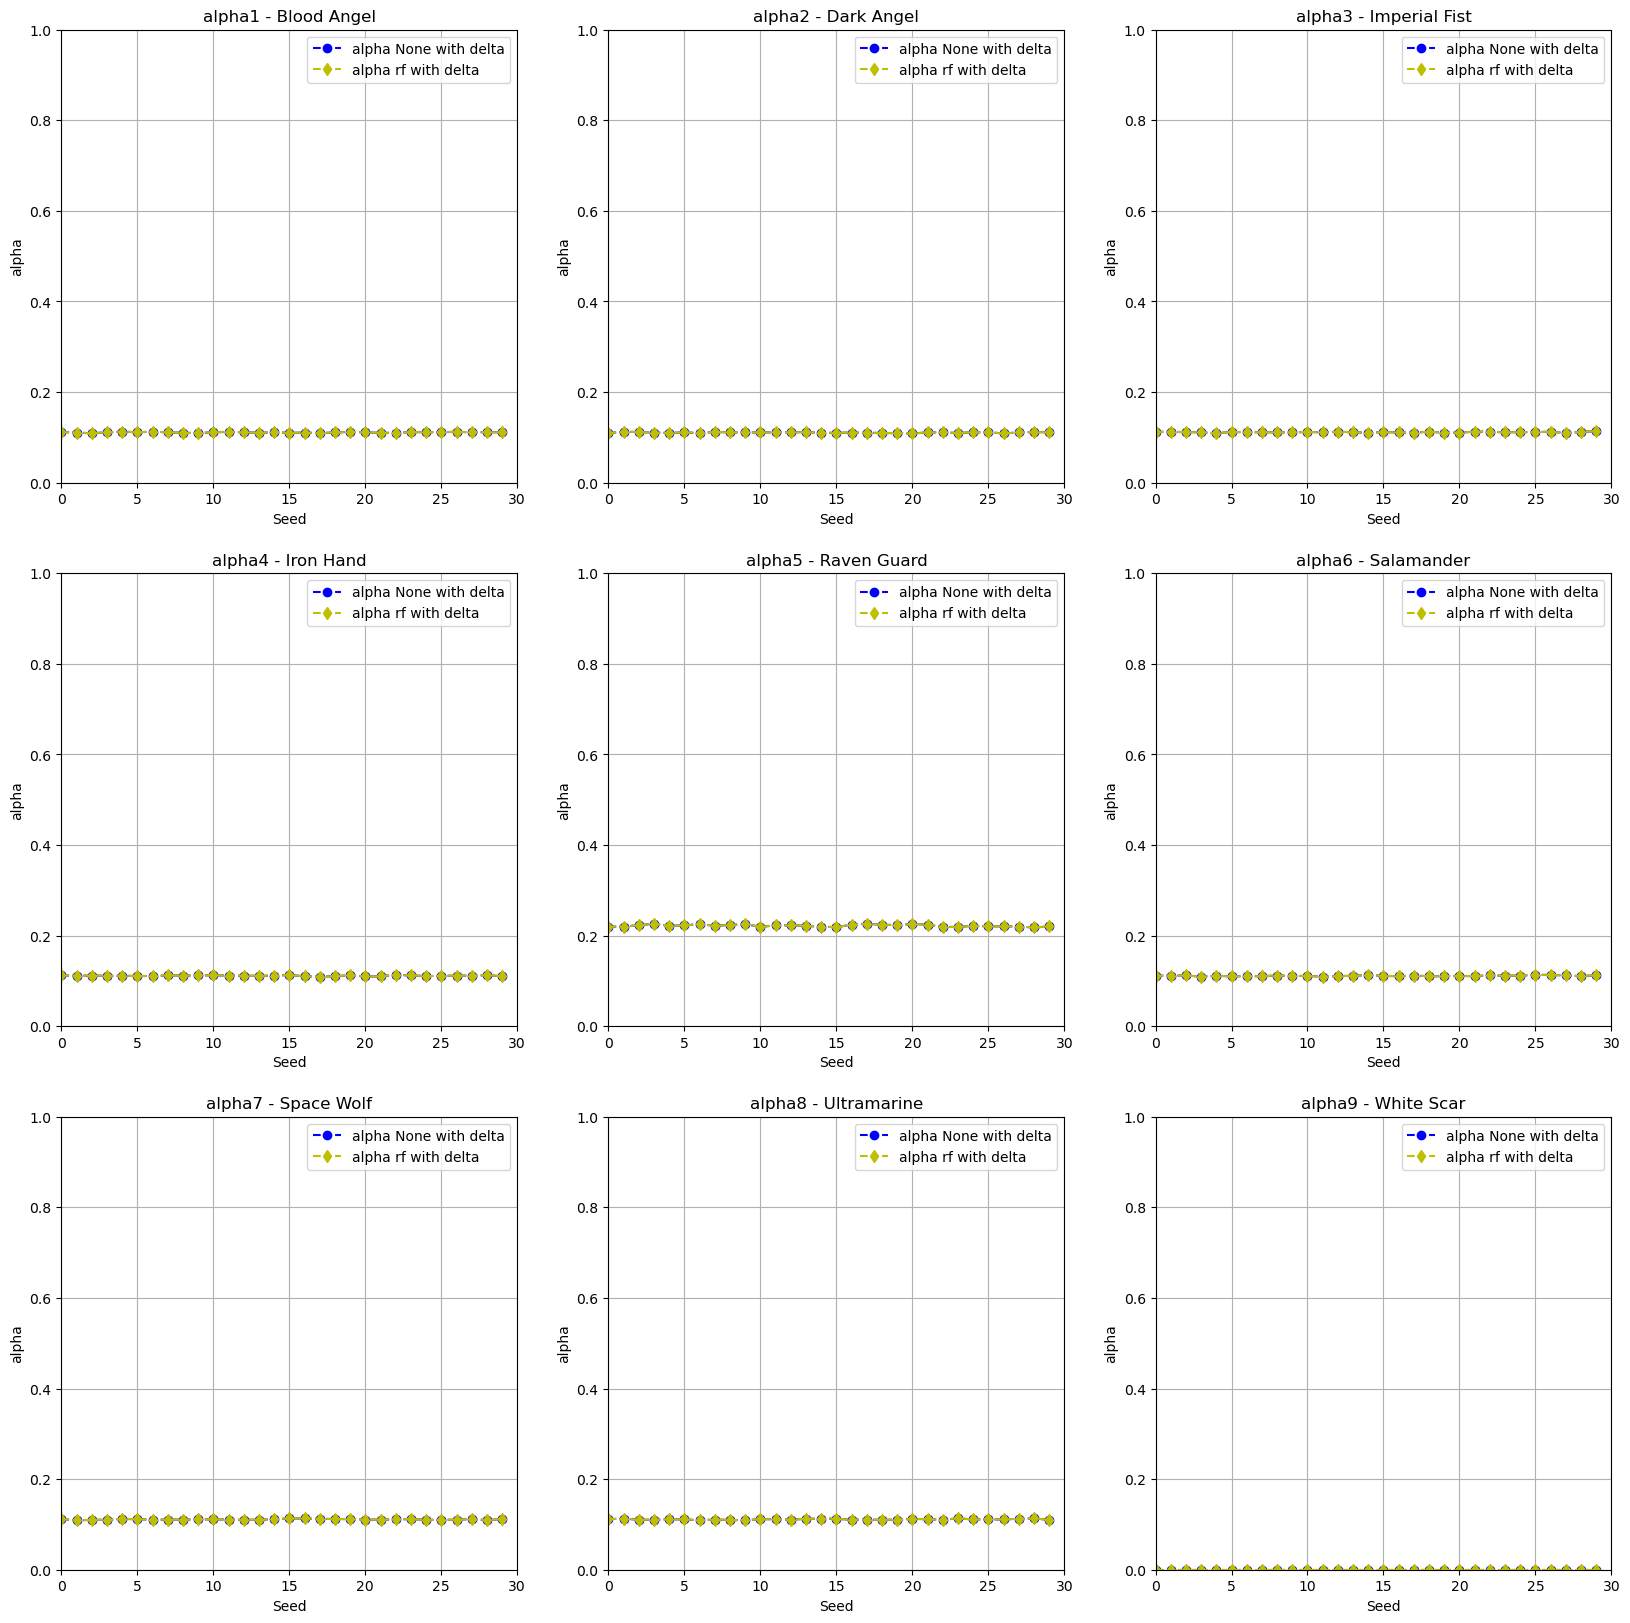

In [76]:
plot_coefficients_delta(results_delta, "alpha", warriors, "Seed")

Let's zoom in a bit:

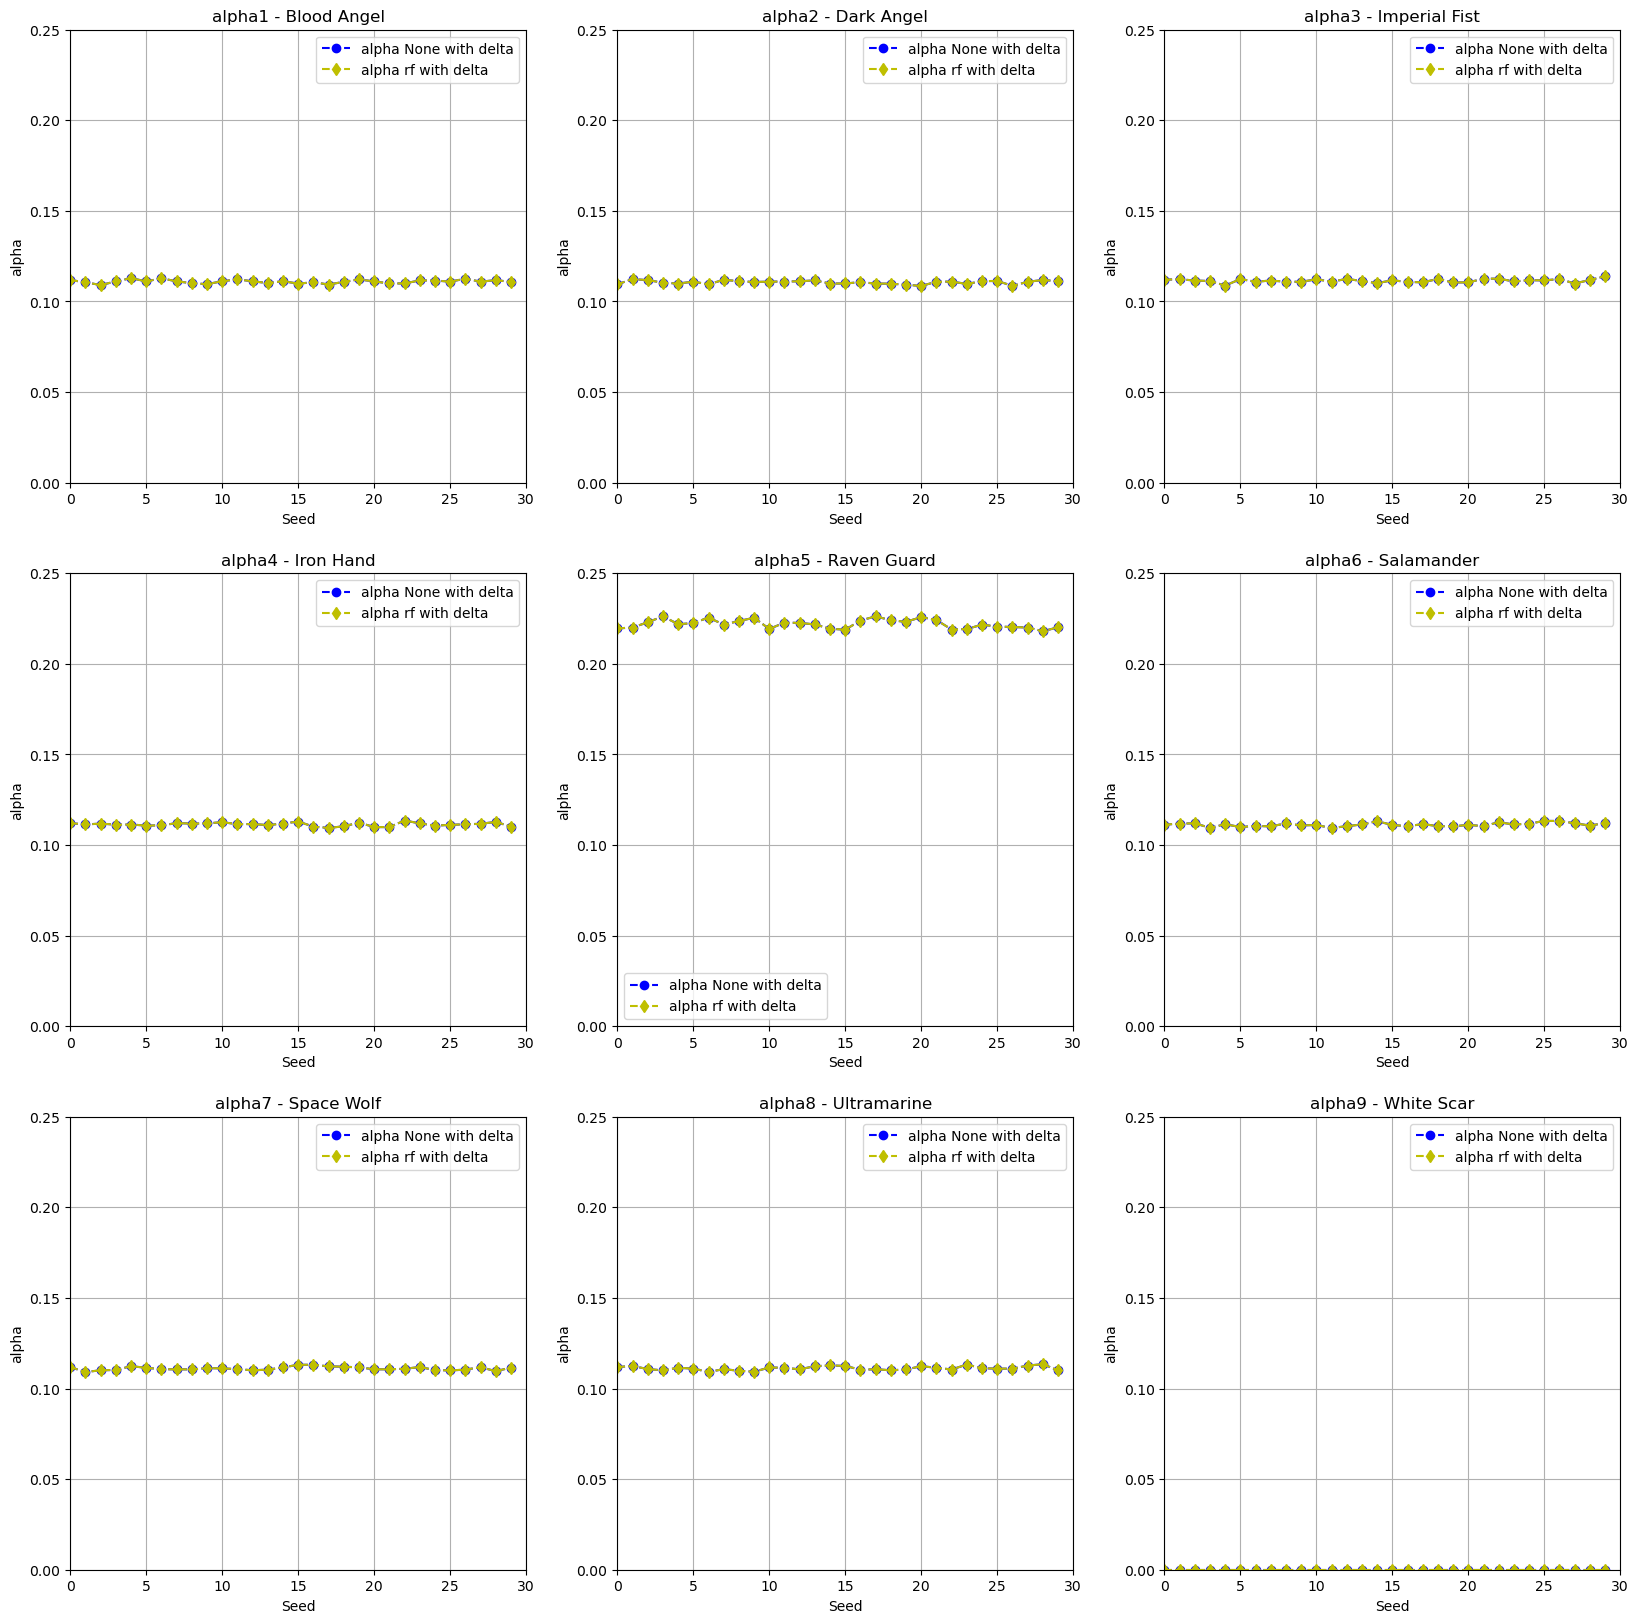

In [ ]:
plot_coefficients_delta(results_delta, "alpha", warriors, "Seed", zoom = 0.25)

Two things to highlight here:

1. Finally the "None"-initialized coefficients are moving, and not only that: they have the same behavior as the "rf" ones. This is due to the fact that, as already said, now there is just one solution: **the algorithm is more robust**.
2. There is a big drawback for what concernes the interpretability though: since the last column is ignored (it is always the last one because when the kernels are polynomial ones it makes sense to drop the higher coefficient in order to reduce overfitting, but in this case it is just an arbitrary decision), the last coefficient is always at 0.
Note that in this case the "zeroed" coefficient is linked to a value that, by dataset construction, we know to be strongly (deterministically!) correlated with a specific value of the other feature: when this happens, the result is that the coefficients of non-correlated values are bigger than they would be if we hadn't dropped the last column, and the coefficients of the other correlated values (in this case, "alpha5") are smaller than they should be. This makes the visible coefficients harder to interpret since they are "closer", and makes the last one all but useless, since it is not informative at all. **The algorithm is less interpretable**.

## 4. Betas plots

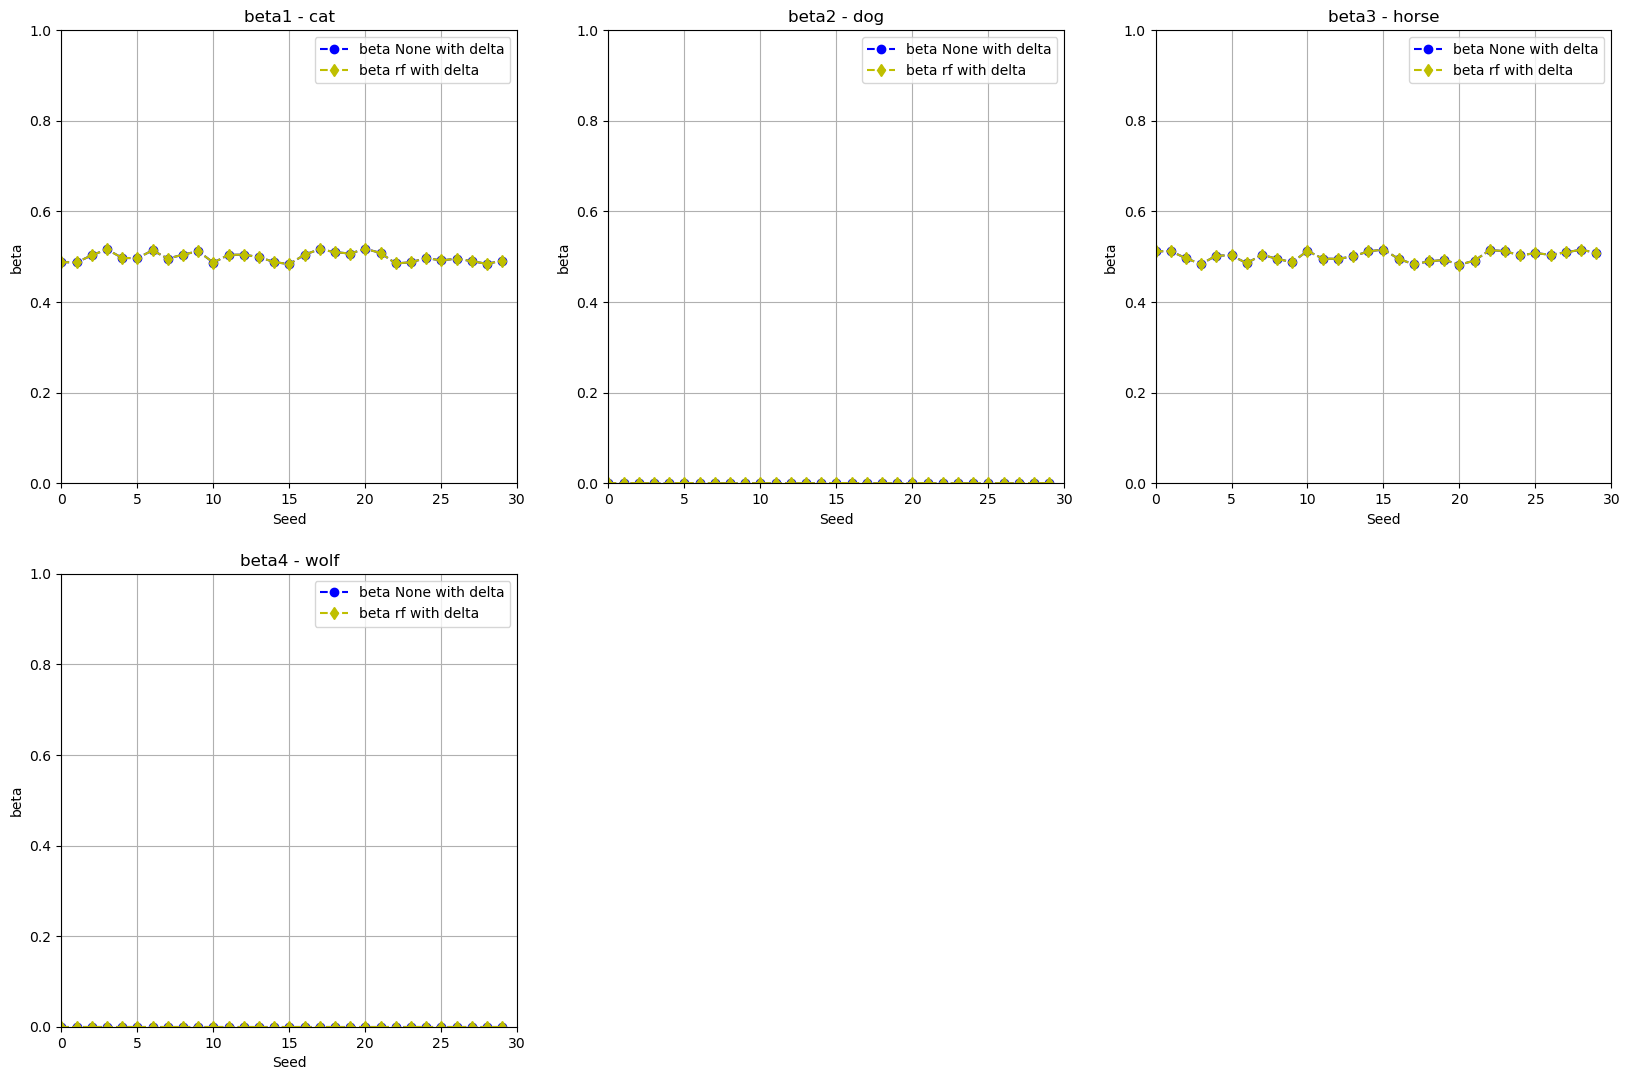

In [79]:
plot_coefficients_delta(results_delta, "beta", animals, "Seed")

We were luckier here, since the dropped coefficient is not linked with a correlated value, and so we can see the positive sides of dropping the last column: the coefficients are a lot more easy to interpret, with the "non-correlated" one (beta2) being almost zero, while the two, equally correlated ones are really big.

# 1. The distribution shifts towards a correlated value

In this experiment i wanted to check how the behavior of the coefficients changes as the dataset distribution becomes more and more skewed towards a heavily correlated value.  
From now on, i'll use the following kernel set-ups:

1. a0, b0: None; last column dropped
2. a0, b0: rf (relative frequency); last column not dropped

I've decided to use these two to compare a robust model that suffers from a potential loss of interpretability (the first one) with a model which is more interpretable but less stable (the second).

## Dataset description

This dataset is different from the one i've used so far. In particular:

1. In order to see how a kernel that uses delta to drop the last column works when we are lucky, i've made it so that one of the two heavily correlated values is no more the last one, but the second to last (i'm cheating a bit)
2. I'll still generate 30 dataset, but this time their distributions will change. In particular, at the beginning we will have a dataset whose values are uniformly distributed, while in the end we'll have a dataset where the distribution is dominated by a particular (highly correlated) value.  

In [87]:
def create_dataset_dist_shift(iteration):

    war_i = []
    ani_i = []

    for j in range(50000):
        
        if j >= (50000/30) * (iteration):    # There is i and not i+1 because i want a bit of variability even on the last run

            warrior=sample(warriors)

        else:

            warrior = "Ultramarine"

        war_i.append(warrior)

        if warrior == "Ultramarine":
            anim = "horse"
        elif warrior == "Raven Guard":
            anim="cat"
        else:
            anim = sample(animals)

        ani_i.append(anim)

    return war_i, ani_i

In [89]:
results_to_correlated = experiment_general(create_dataset_dist_shift, my_kernel_one_hot_with_delta, my_kernel_one_hot)

## 1. Correlations plots

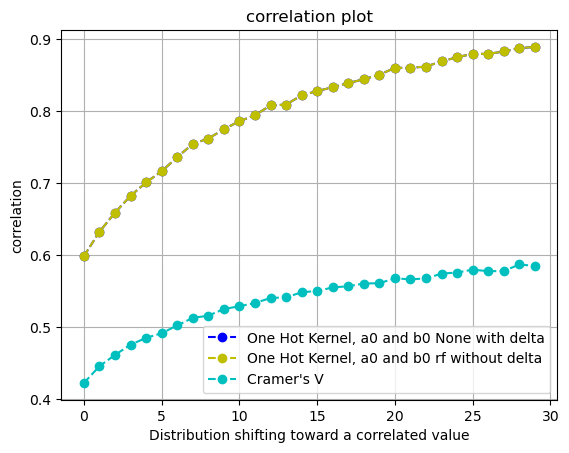

In [94]:
plot_results_general(results_to_correlated, "correlation", "Distribution shifting toward a correlated value")

As we could have expected, the more a correlated value becomes predominant, the more the computed correlation increases.

## 2. Execution times

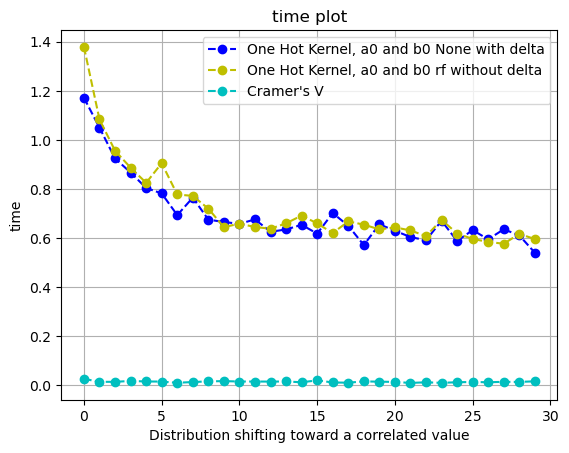

In [95]:
plot_results_general(results_to_correlated, "time", "Distribution shifting toward a correlated value")

Intuitively, the more pronounced is the correlation the less it takes the algorithm to compute it.

## 3. Alphas plots (abs values)

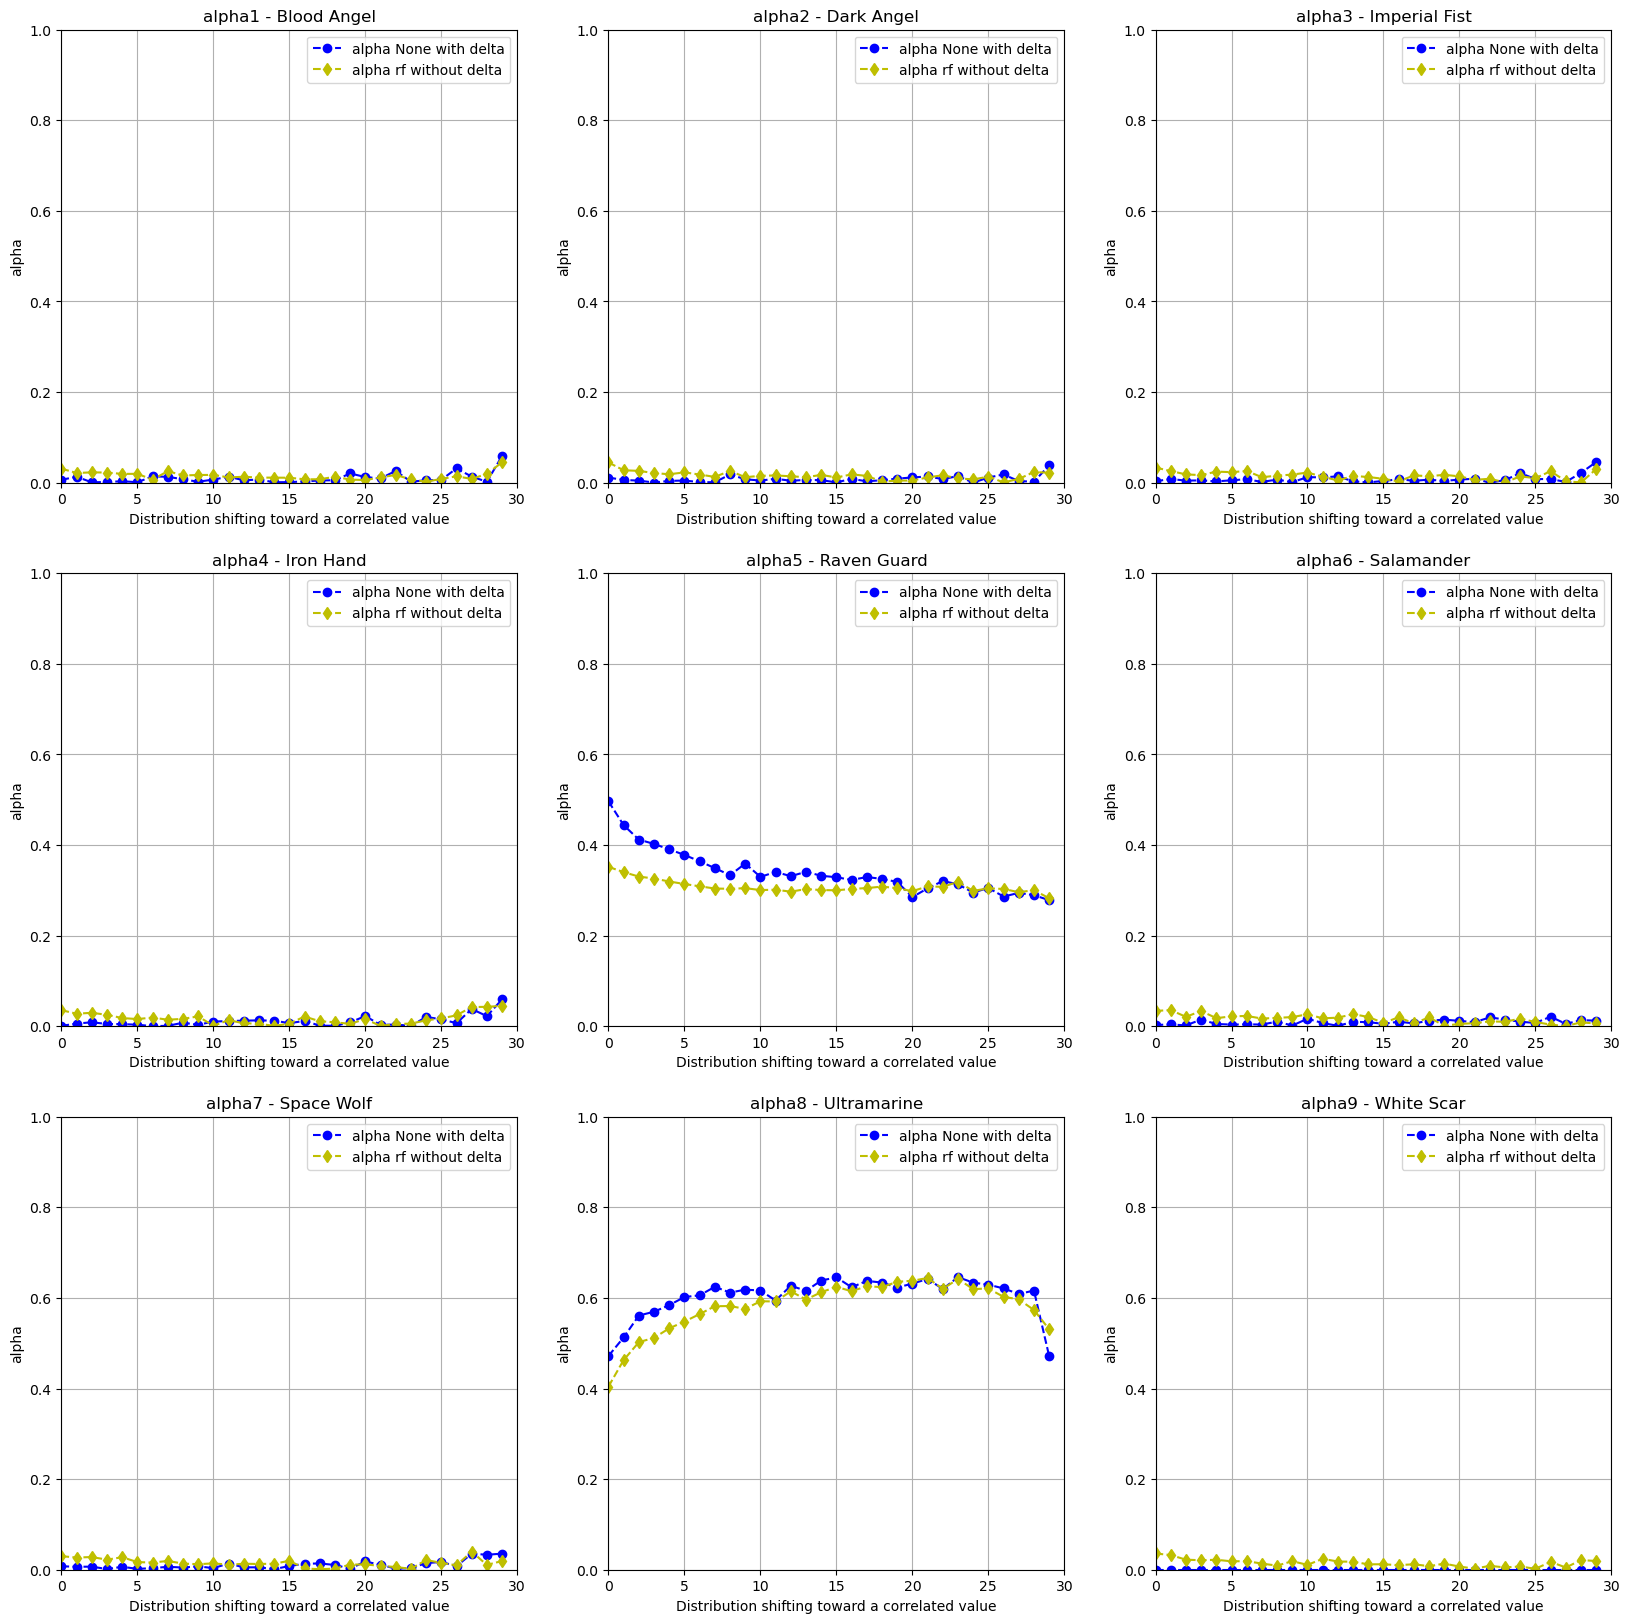

In [96]:
plot_coefficients_general(results_to_correlated, "alpha", warriors, "Distribution shifting toward a correlated value")

Let's zoom in a bit:

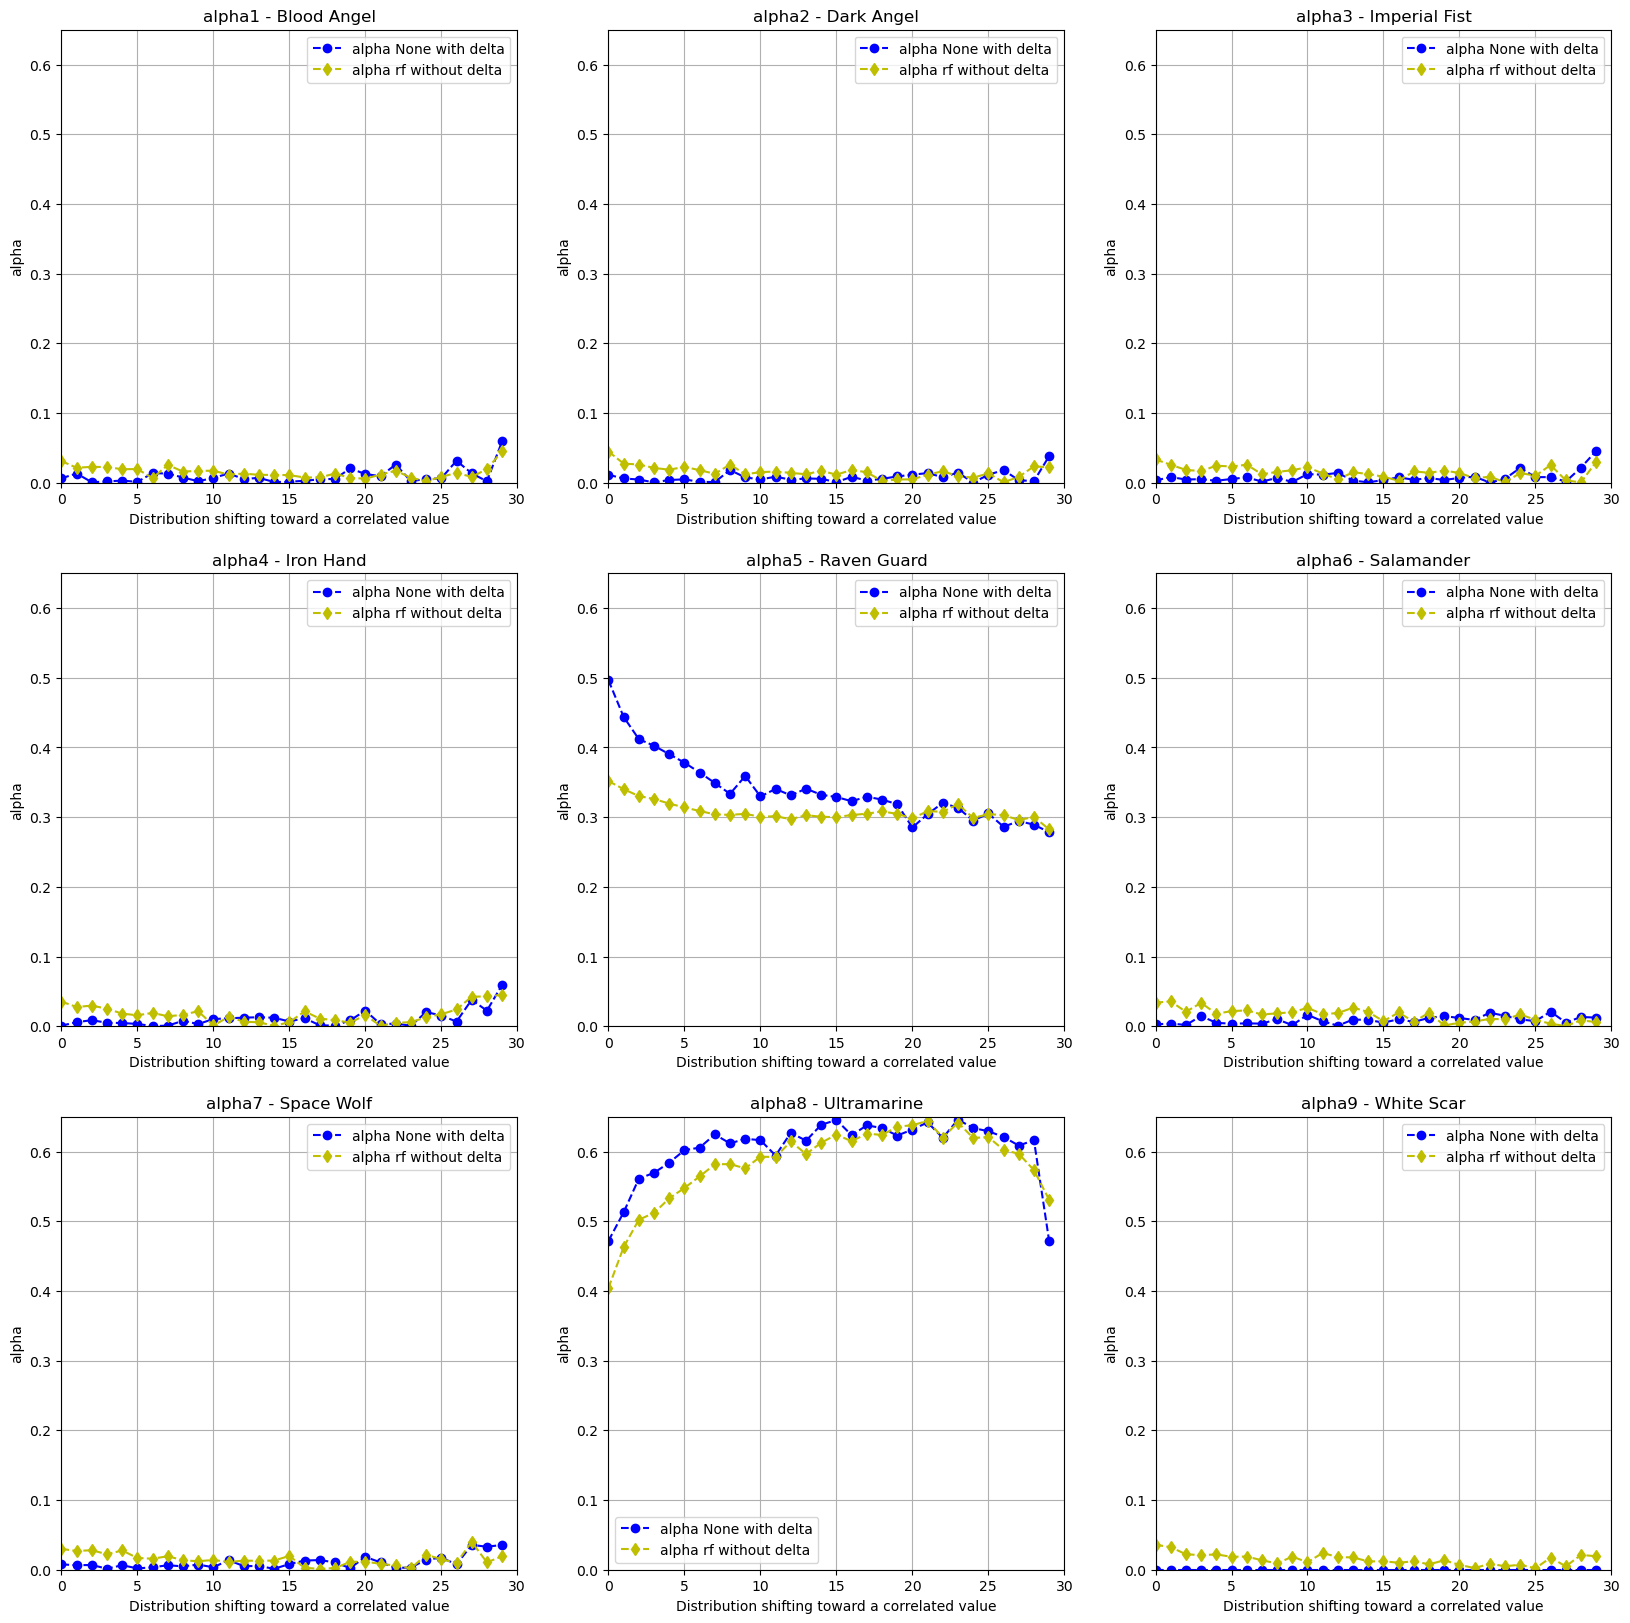

In [97]:
plot_coefficients_general(results_to_correlated, "alpha", warriors, "Distribution shifting toward a correlated value", zoom = 0.65)

1. Non correlated coefficients start close to 0 (the ones relative to the kernel that drops the last column being closer) and, as the correlated value becomes predominant, they tend to decrease. At a certain point though, around the 25-th dataset, they become bigger.

2. The coefficient of the value that is getting predominant (alpha8) increases as the relative frequency of the corresponding value increases. This happens until dataset number ~23: after that, the coefficient's value drops quite sensibly.

3. For what concernes the correlated but not-getting-predominant value's coefficient (alpha5), it decreases and then stabilizes around 0.3. This makes sense: the strenght of its correlation remains the same, but its relative frequency in the dataset diminishes, and along it its absolute value.

## 4. Betas plots (abs values)

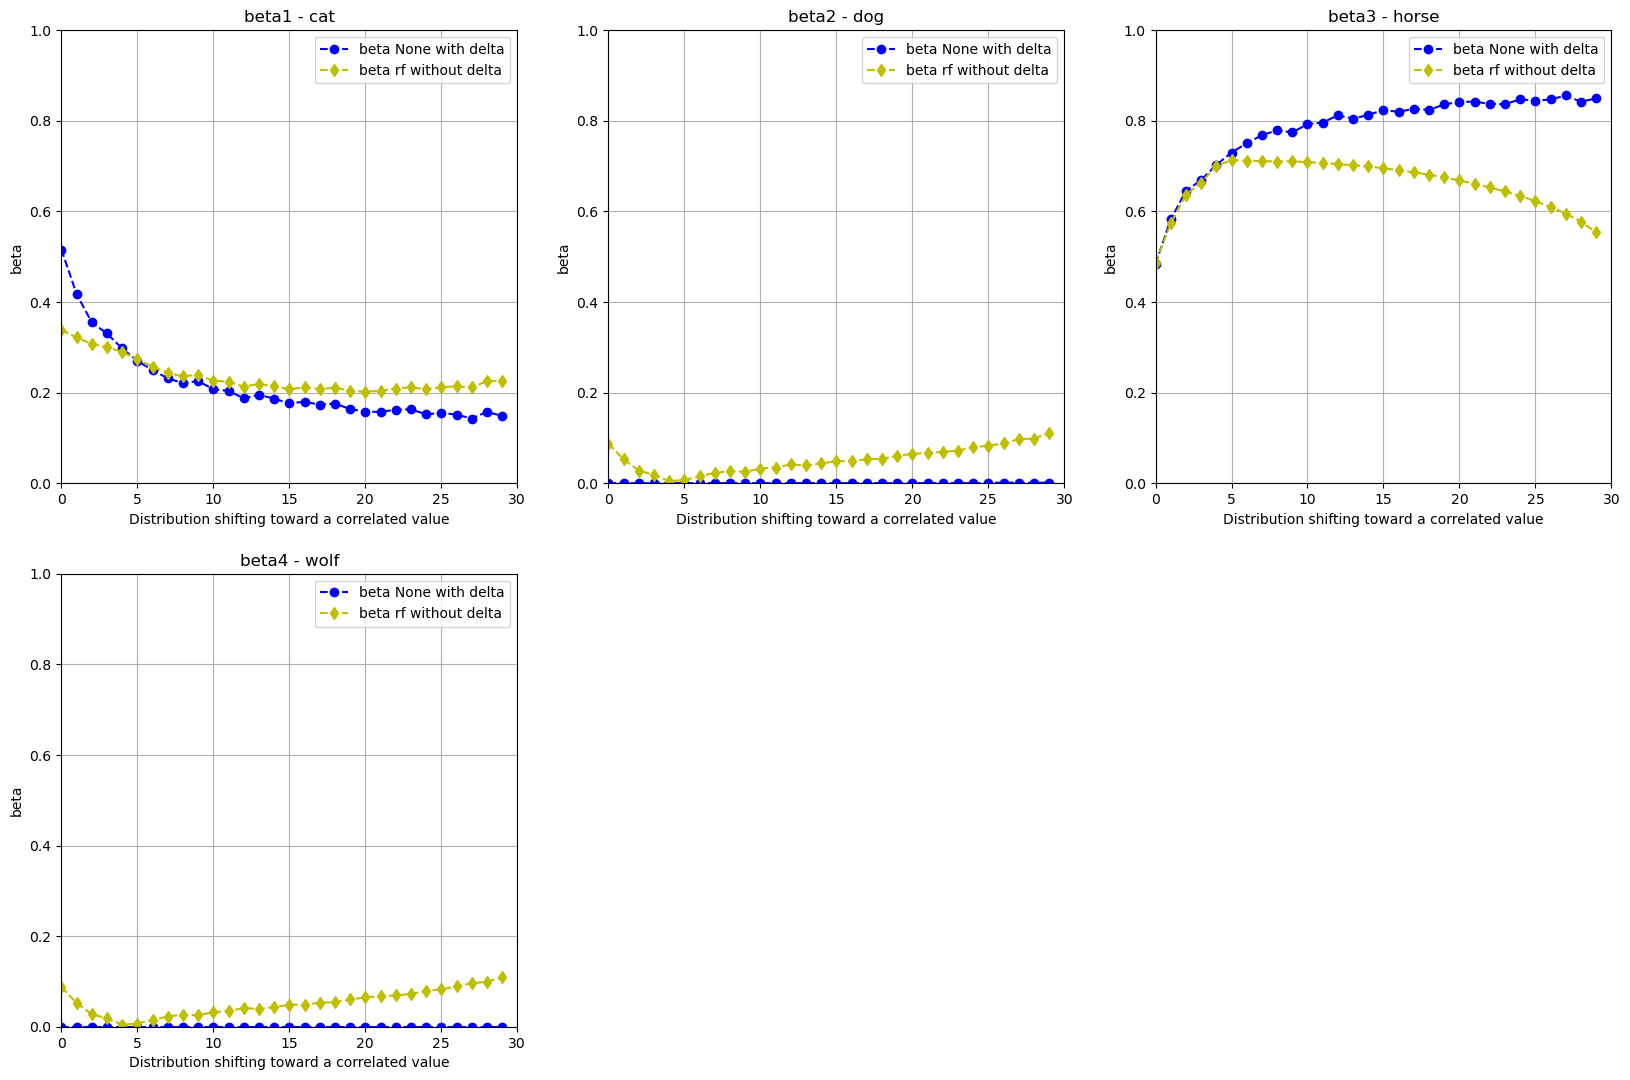

In [99]:
plot_coefficients_general(results_to_correlated, "beta", animals, "Distribution shifting toward a correlated value")

The behavior of the kernel which drops the last column aligns more with what i was expecting:  
1. The coefficient of the non correlated values stays at 0 (for the last one it is due to the last column being dropped), and it makes sense since it is not correlated with any particular value of the other feature. 

2. The coefficient of the value that is getting predominant (beta3) keeps increasing as the value gets more predominant.

3. The coefficient of the correlated but relatively shrinking in frequency value (beta1) decreases as its presence in the dataset diminishes.

# 2. The distribution shifts towards a NON-correlated value 

This experiment is very similar to the previous one, since its aim is still to investigate how the coefficients change according to the dataset distribution. In this case though, i've increased the frequence of a non correlated value too see how this affects the correlation and the coefficients of the correlated ones.

## Dataset description

It is very similar to the one i've used for the previous experiment. The only difference is that this time it is a non-correlated value that becomes more and more frequent.

In [101]:
def create_dataset_dist_shift_no_corr(iteration):

    war_i = []
    ani_i = []

    for j in range(50000):
        
        if j >= (50000/30) * (iteration):    # There is i and not i+1 because i want a bit of variability even on the last run

            warrior=sample(warriors)

        else:

            warrior = "Iron Hand"

        war_i.append(warrior)

        if warrior == "Ultramarine":
            anim = "horse"
        elif warrior == "Raven Guard":
            anim="cat"
        else:
            anim = sample(animals)

        ani_i.append(anim)

    return war_i, ani_i

In [102]:
results_to_non_correlated = experiment_general(create_dataset_dist_shift_no_corr, my_kernel_one_hot_with_delta, my_kernel_one_hot)

## 1. Correlations plots

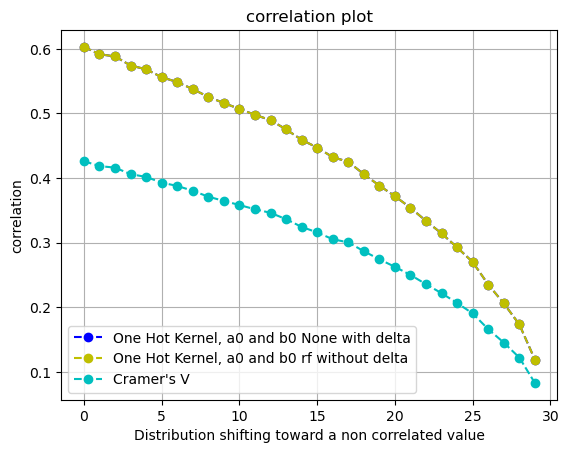

In [103]:
plot_results_general(results_to_non_correlated, "correlation", "Distribution shifting toward a non correlated value")

As i expected, the correlation decreases as the correlated values are less and less frequent.

## 2. Execution times

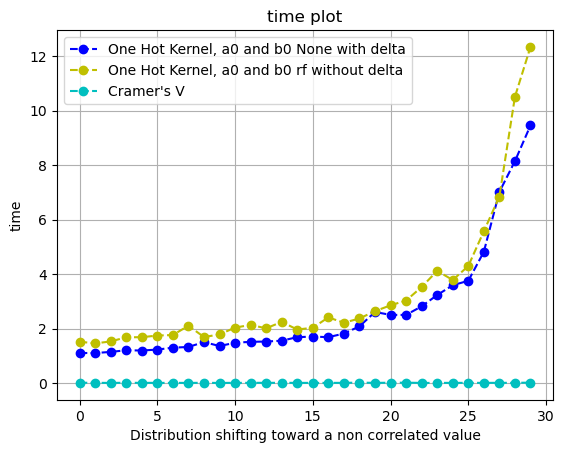

In [104]:
plot_results_general(results_to_non_correlated, "time", "Distribution shifting toward a non correlated value")

Intuitively, as the dataset becomes dominated by non correlated values, it takes more time to compute the correlation. The kernel that does not drop the last column takes slightly more time to converge since it is more unstable.

## 3. Alphas plots (abs values)

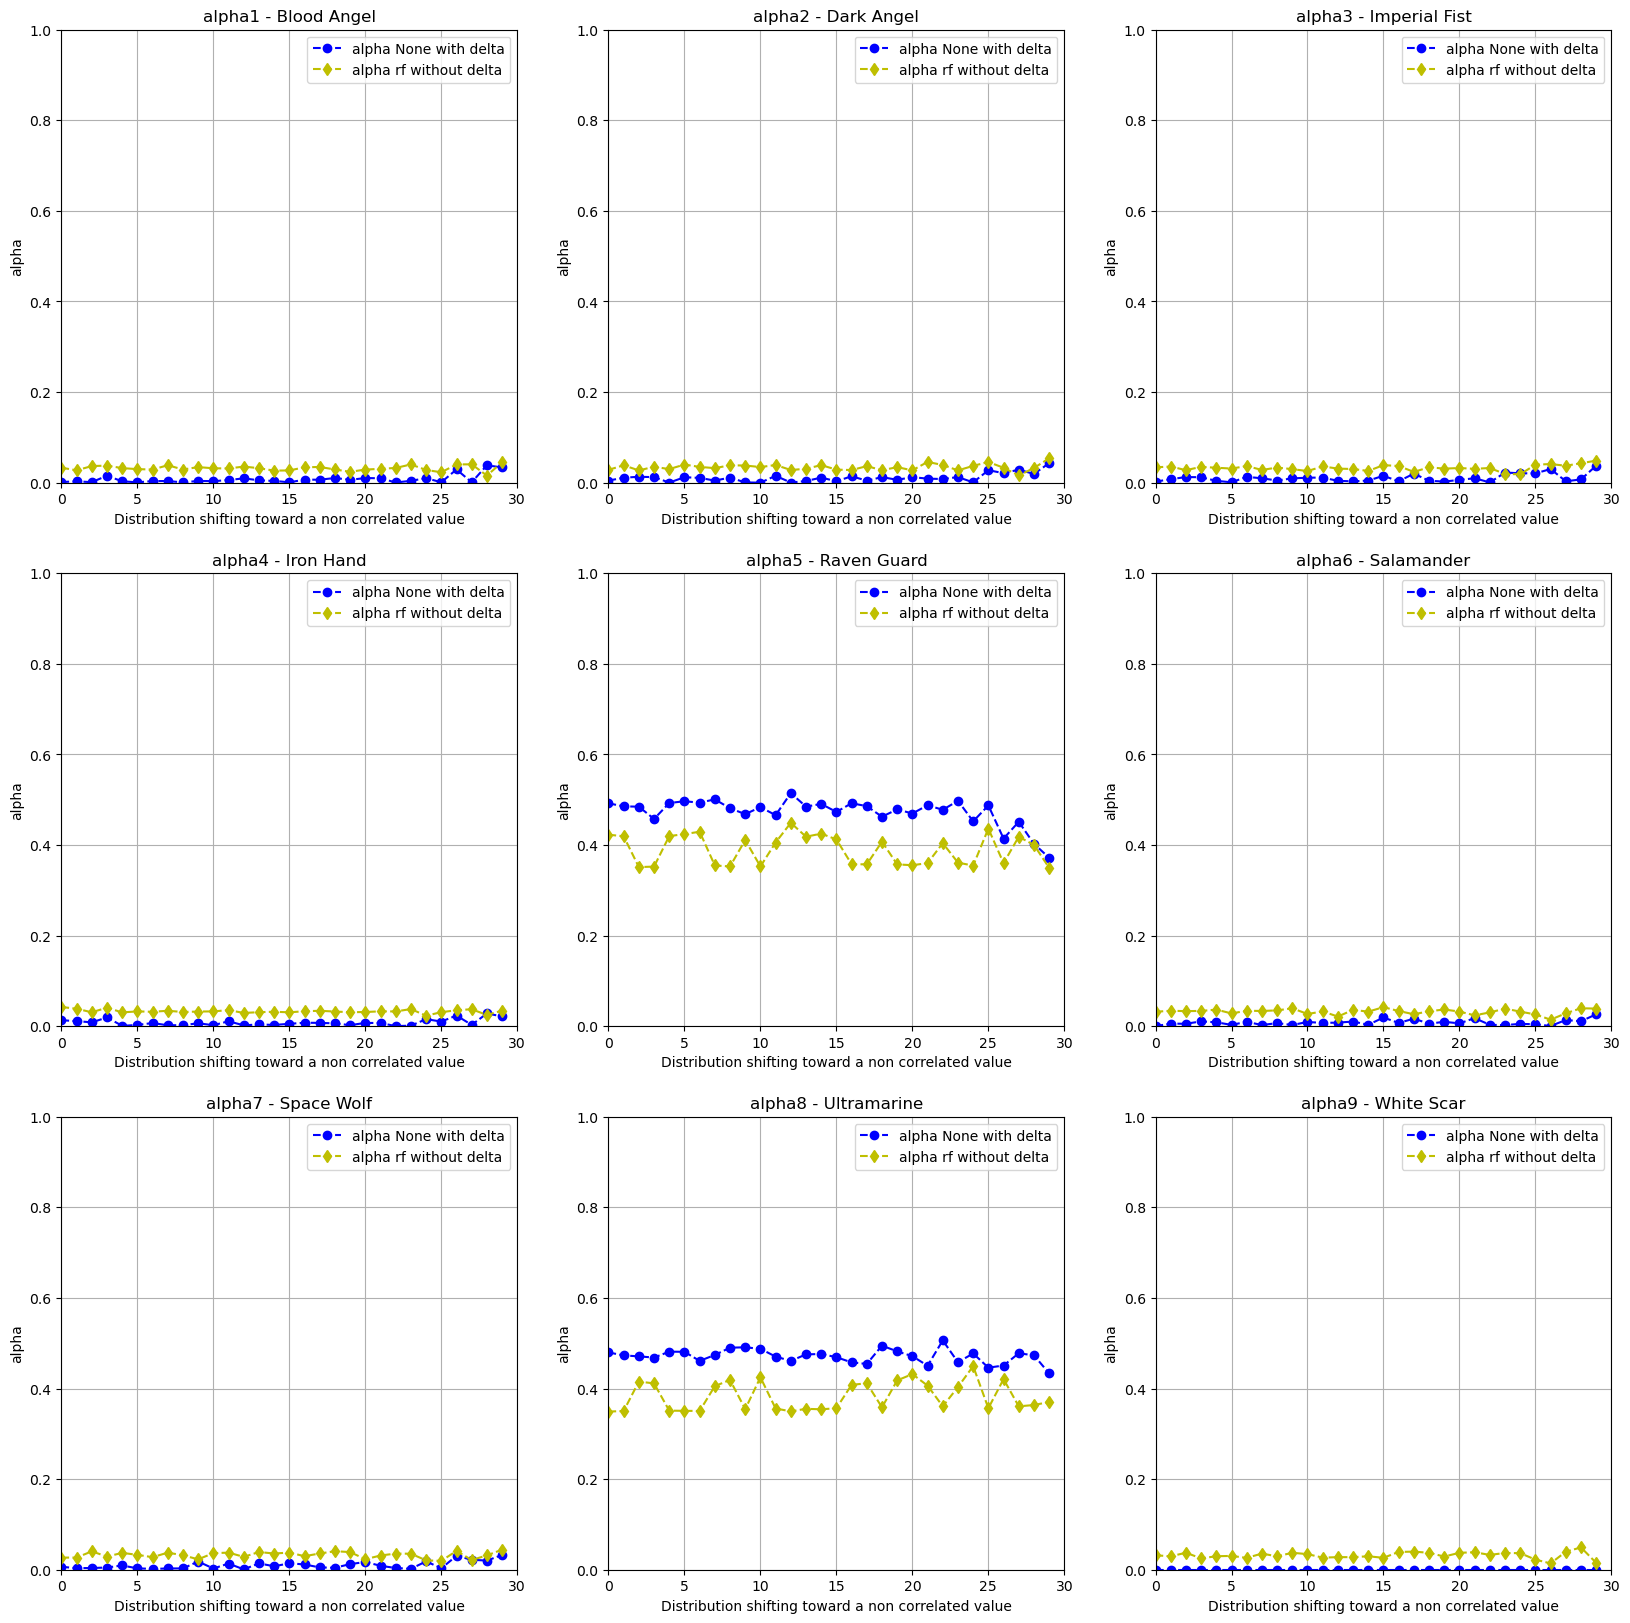

In [107]:
plot_coefficients_general(results_to_non_correlated, "alpha", warriors, "Distribution shifting toward a non correlated value")

Let's zoom in a bit:

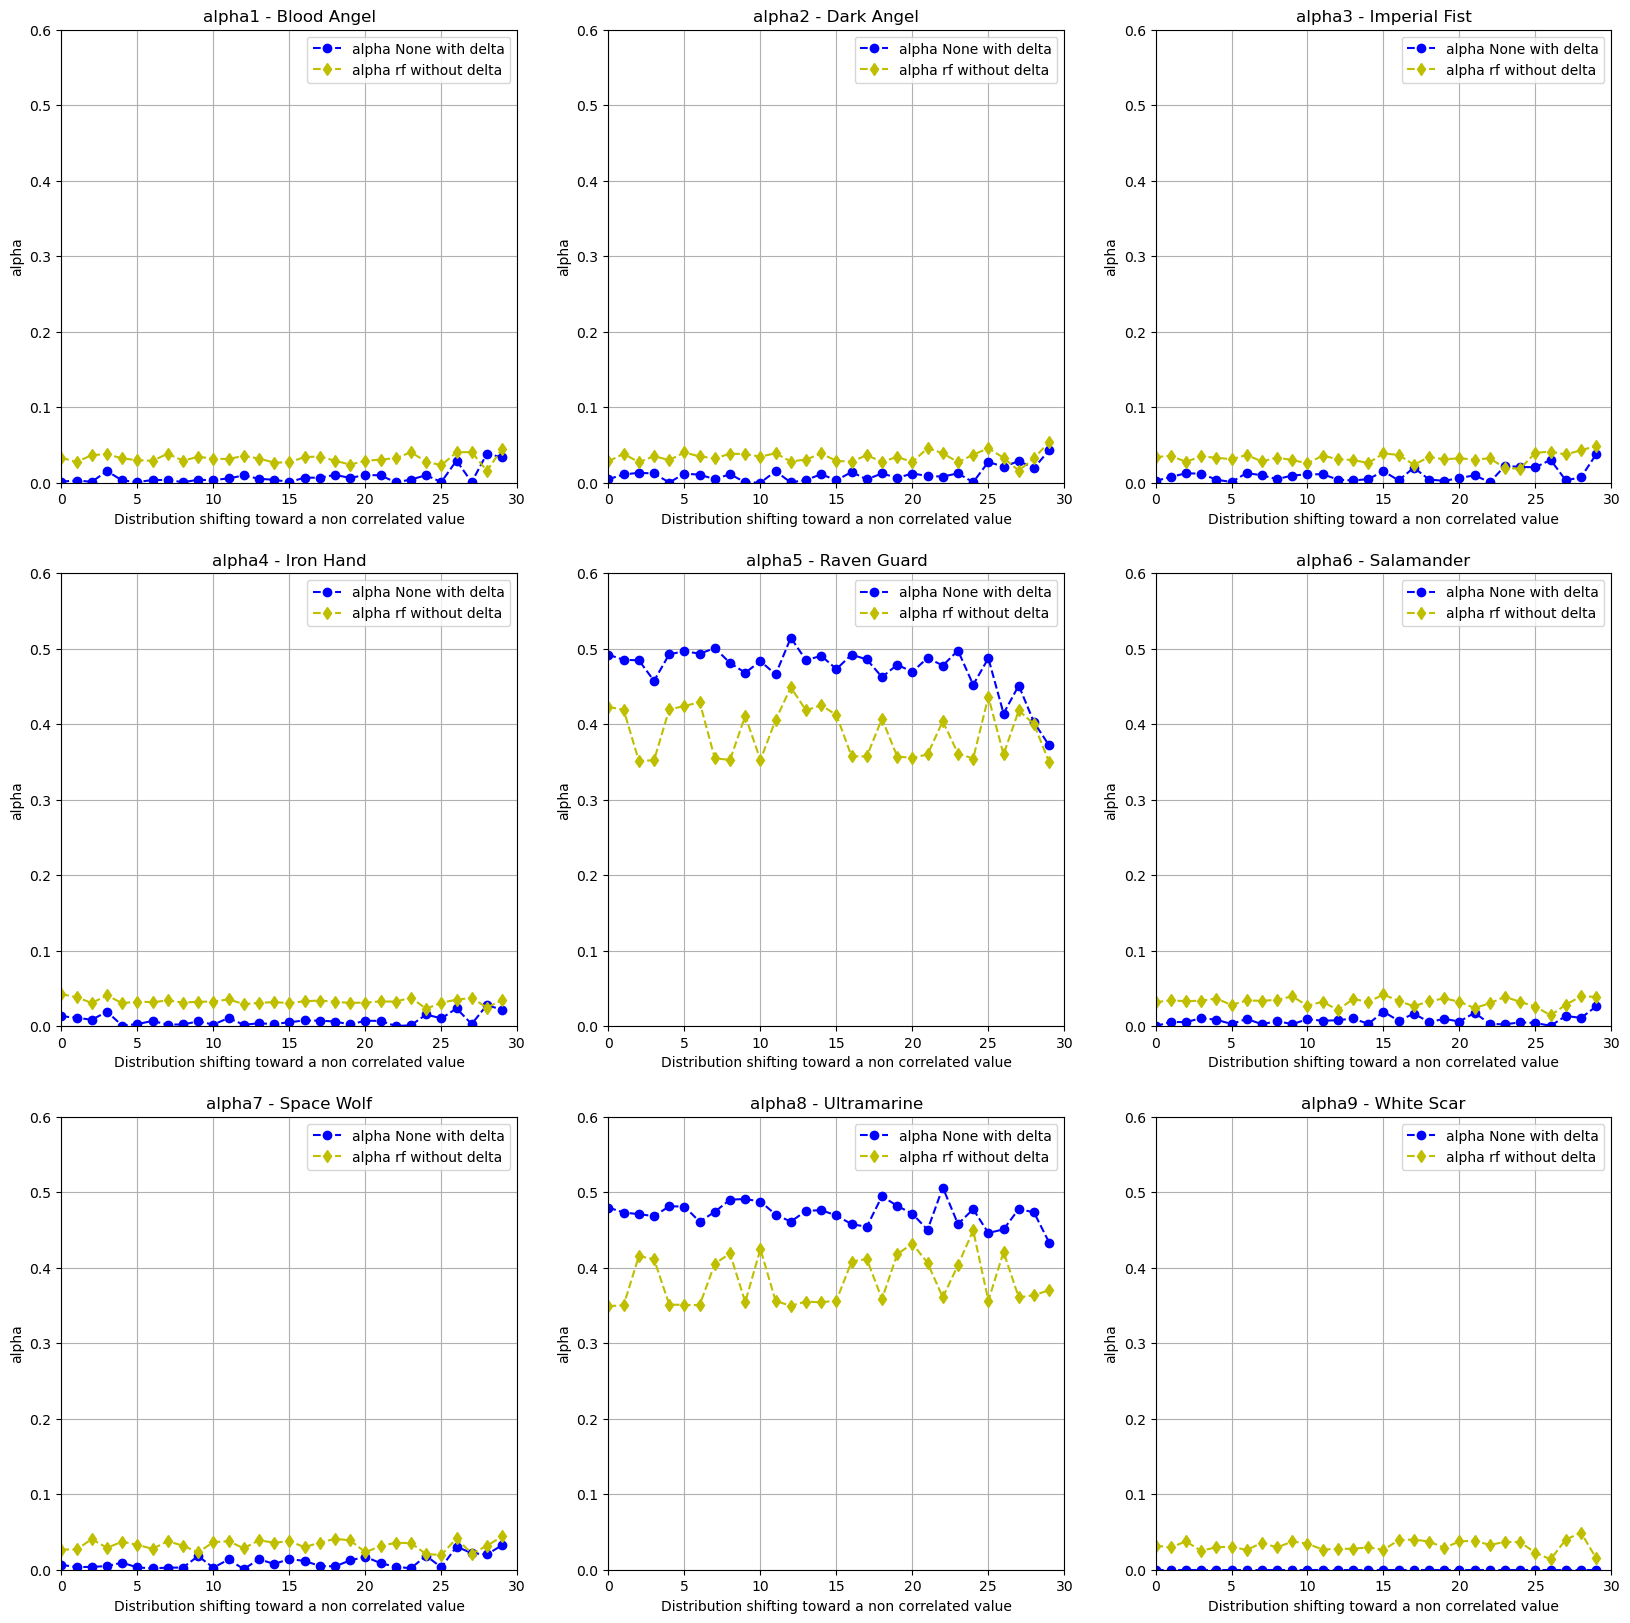

In [108]:
plot_coefficients_general(results_to_non_correlated, "alpha", warriors, "Distribution shifting toward a non correlated value", zoom = 0.6)

## 4. Betas plots (abs values)

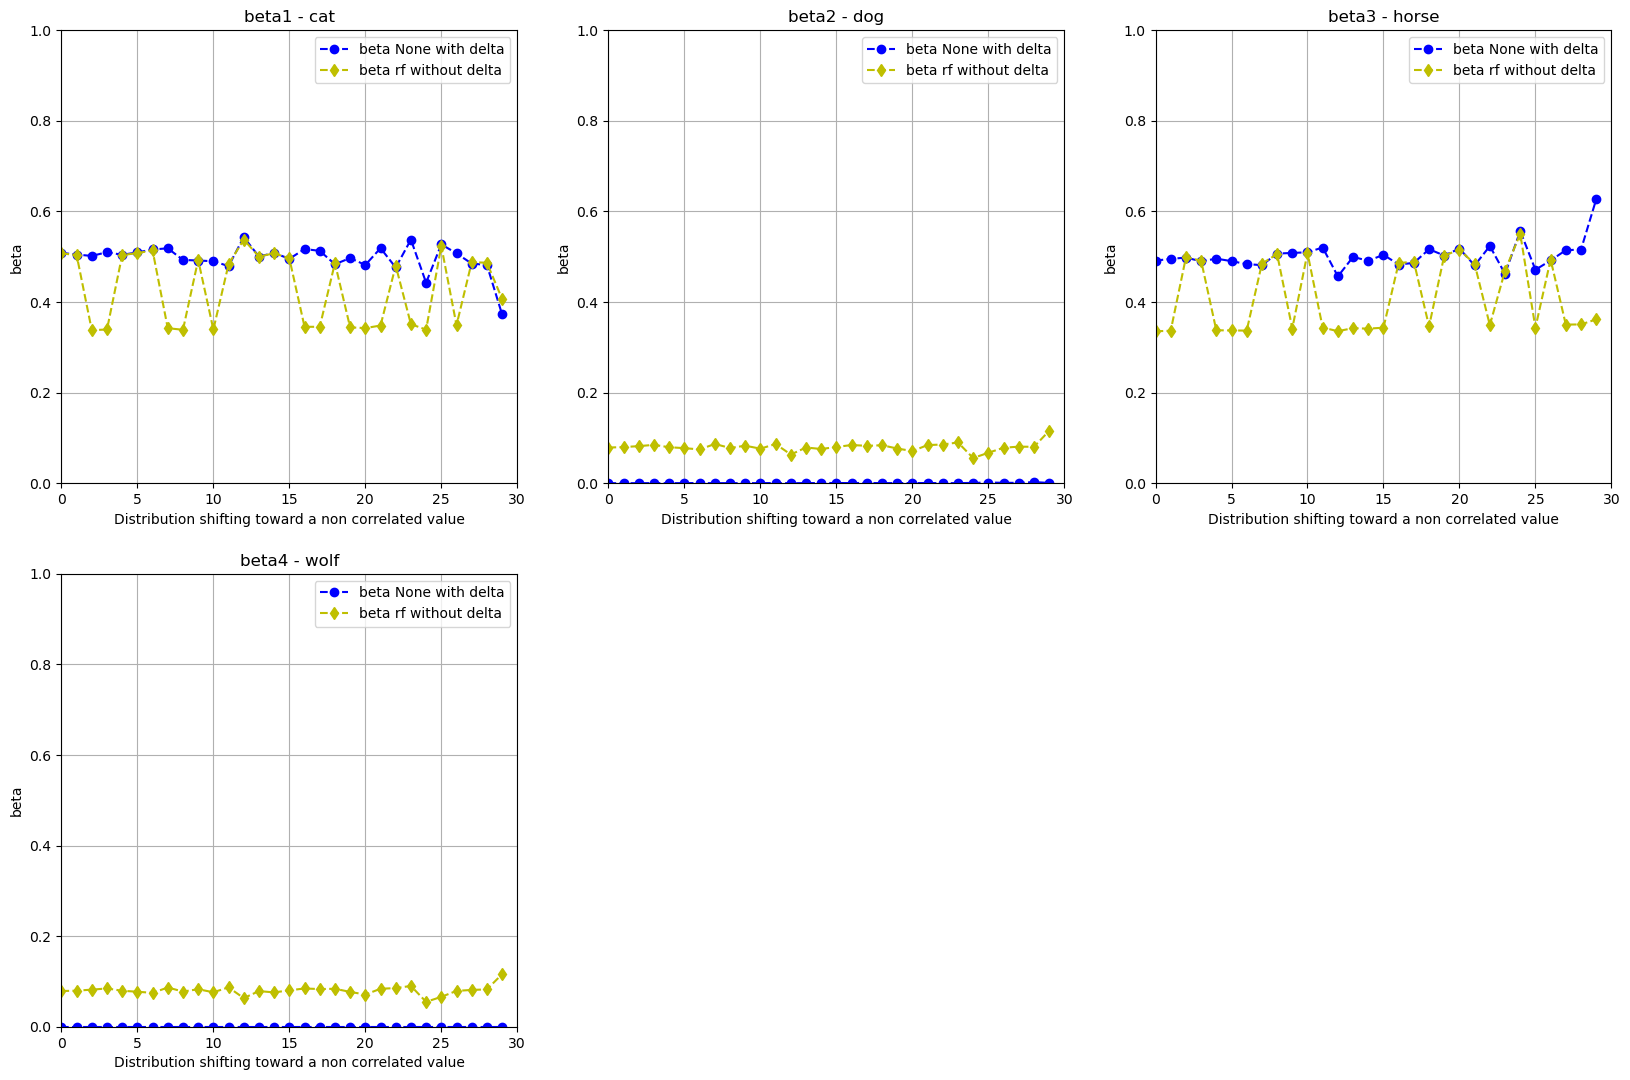

In [112]:
plot_coefficients_general(results_to_non_correlated, "beta", animals, "Distribution shifting toward a non correlated value")

# 3. The correlation increases

So far we've seen what happens to the correlation and the coefficients when it is the dataset distribution that changes. In this experiment i've studied what happens to them as the strenght of the correlation increases, while the distribution stays the same.

## Dataset description

I will start from a completely random dataset, and then i will make two couples of values more and more correlated, until they became deterministically linked.

In [113]:
def create_dataset_increasing_corr(iteration):

    war_i = []
    ani_i = []

    for j in range(50000):
        
        warrior=sample(warriors)

        war_i.append(warrior)

        if warrior == "Ultramarine":
            if rn.randint(1,29) > iteration:  
                anim = sample(animals)
            else:                  
                anim = "horse"
        elif warrior == "Raven Guard":
            if rn.randint(1,29) > iteration:  
                anim = sample(animals)
            else:     
                anim="cat"
        else:
            anim = sample(animals)

        ani_i.append(anim)

    return war_i, ani_i

In [114]:
results_increasing_corr = experiment_general(create_dataset_increasing_corr, my_kernel_one_hot_with_delta, my_kernel_one_hot)

## 1. Correlations plots

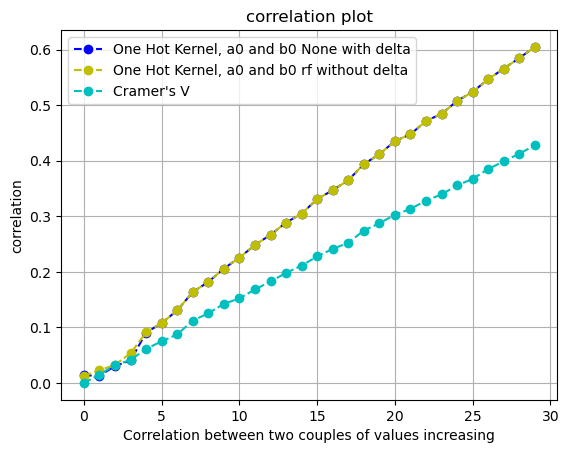

In [115]:
plot_results_general(results_increasing_corr, "correlation", "Correlation between two couples of values increasing")

## 2. Execution times

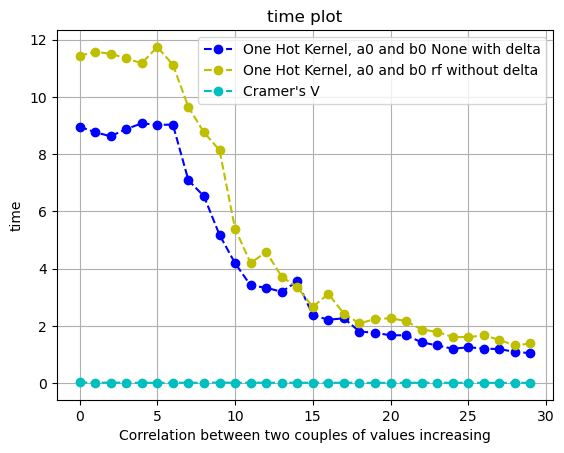

In [116]:
plot_results_general(results_increasing_corr, "time", "Correlation between two couples of values increasing")

As we've already seen, as the correlation becomes more evident the time to compute it dwindles.

## 3. Alphas plots

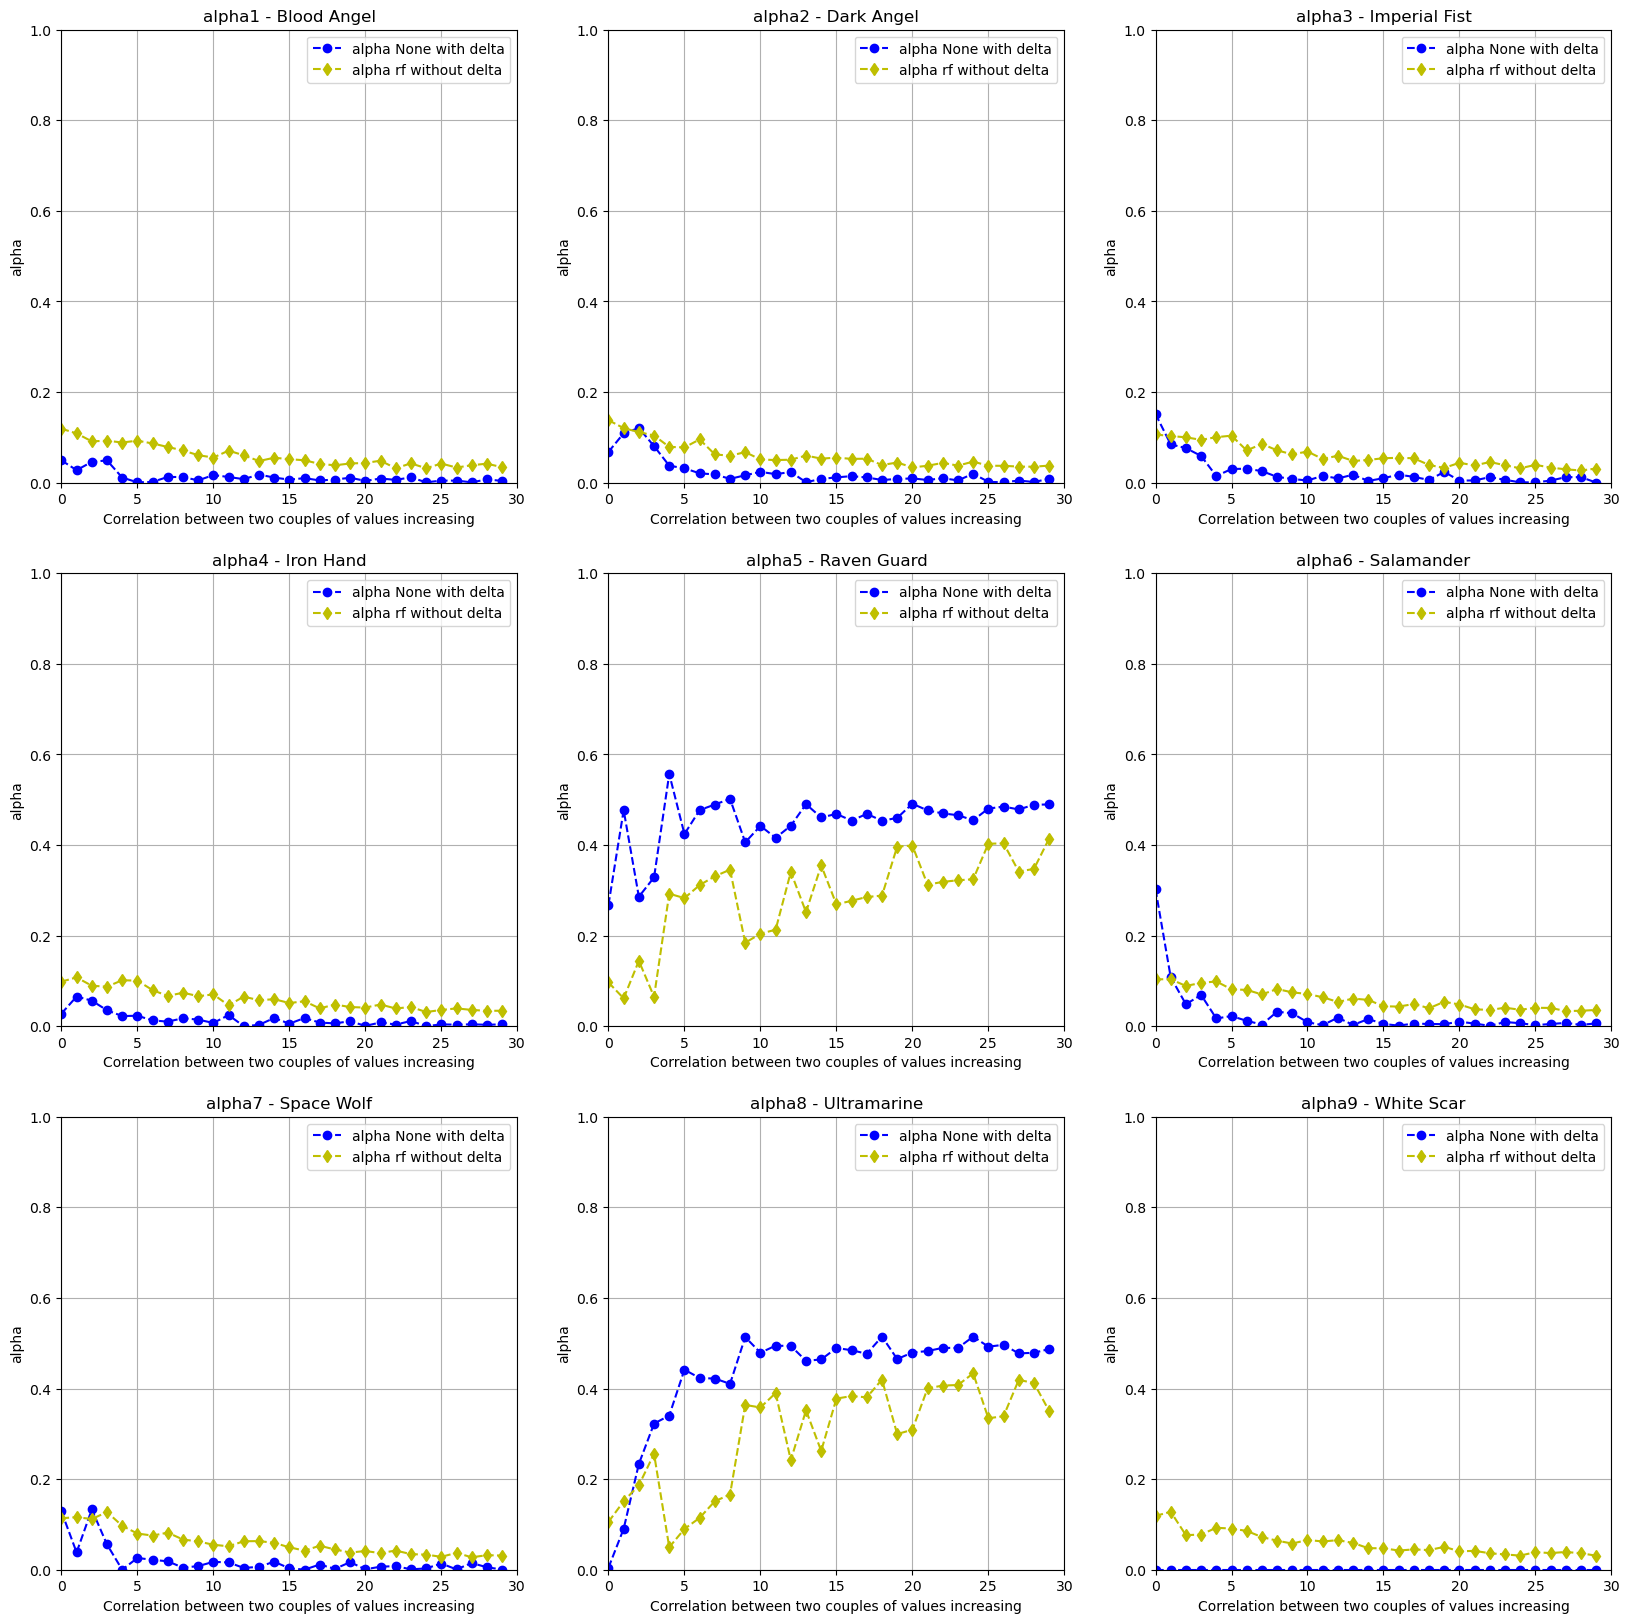

In [117]:
plot_coefficients_general(results_increasing_corr, "alpha", warriors, "Correlation between two couples of values increasing")

Let's zoom in a bit:

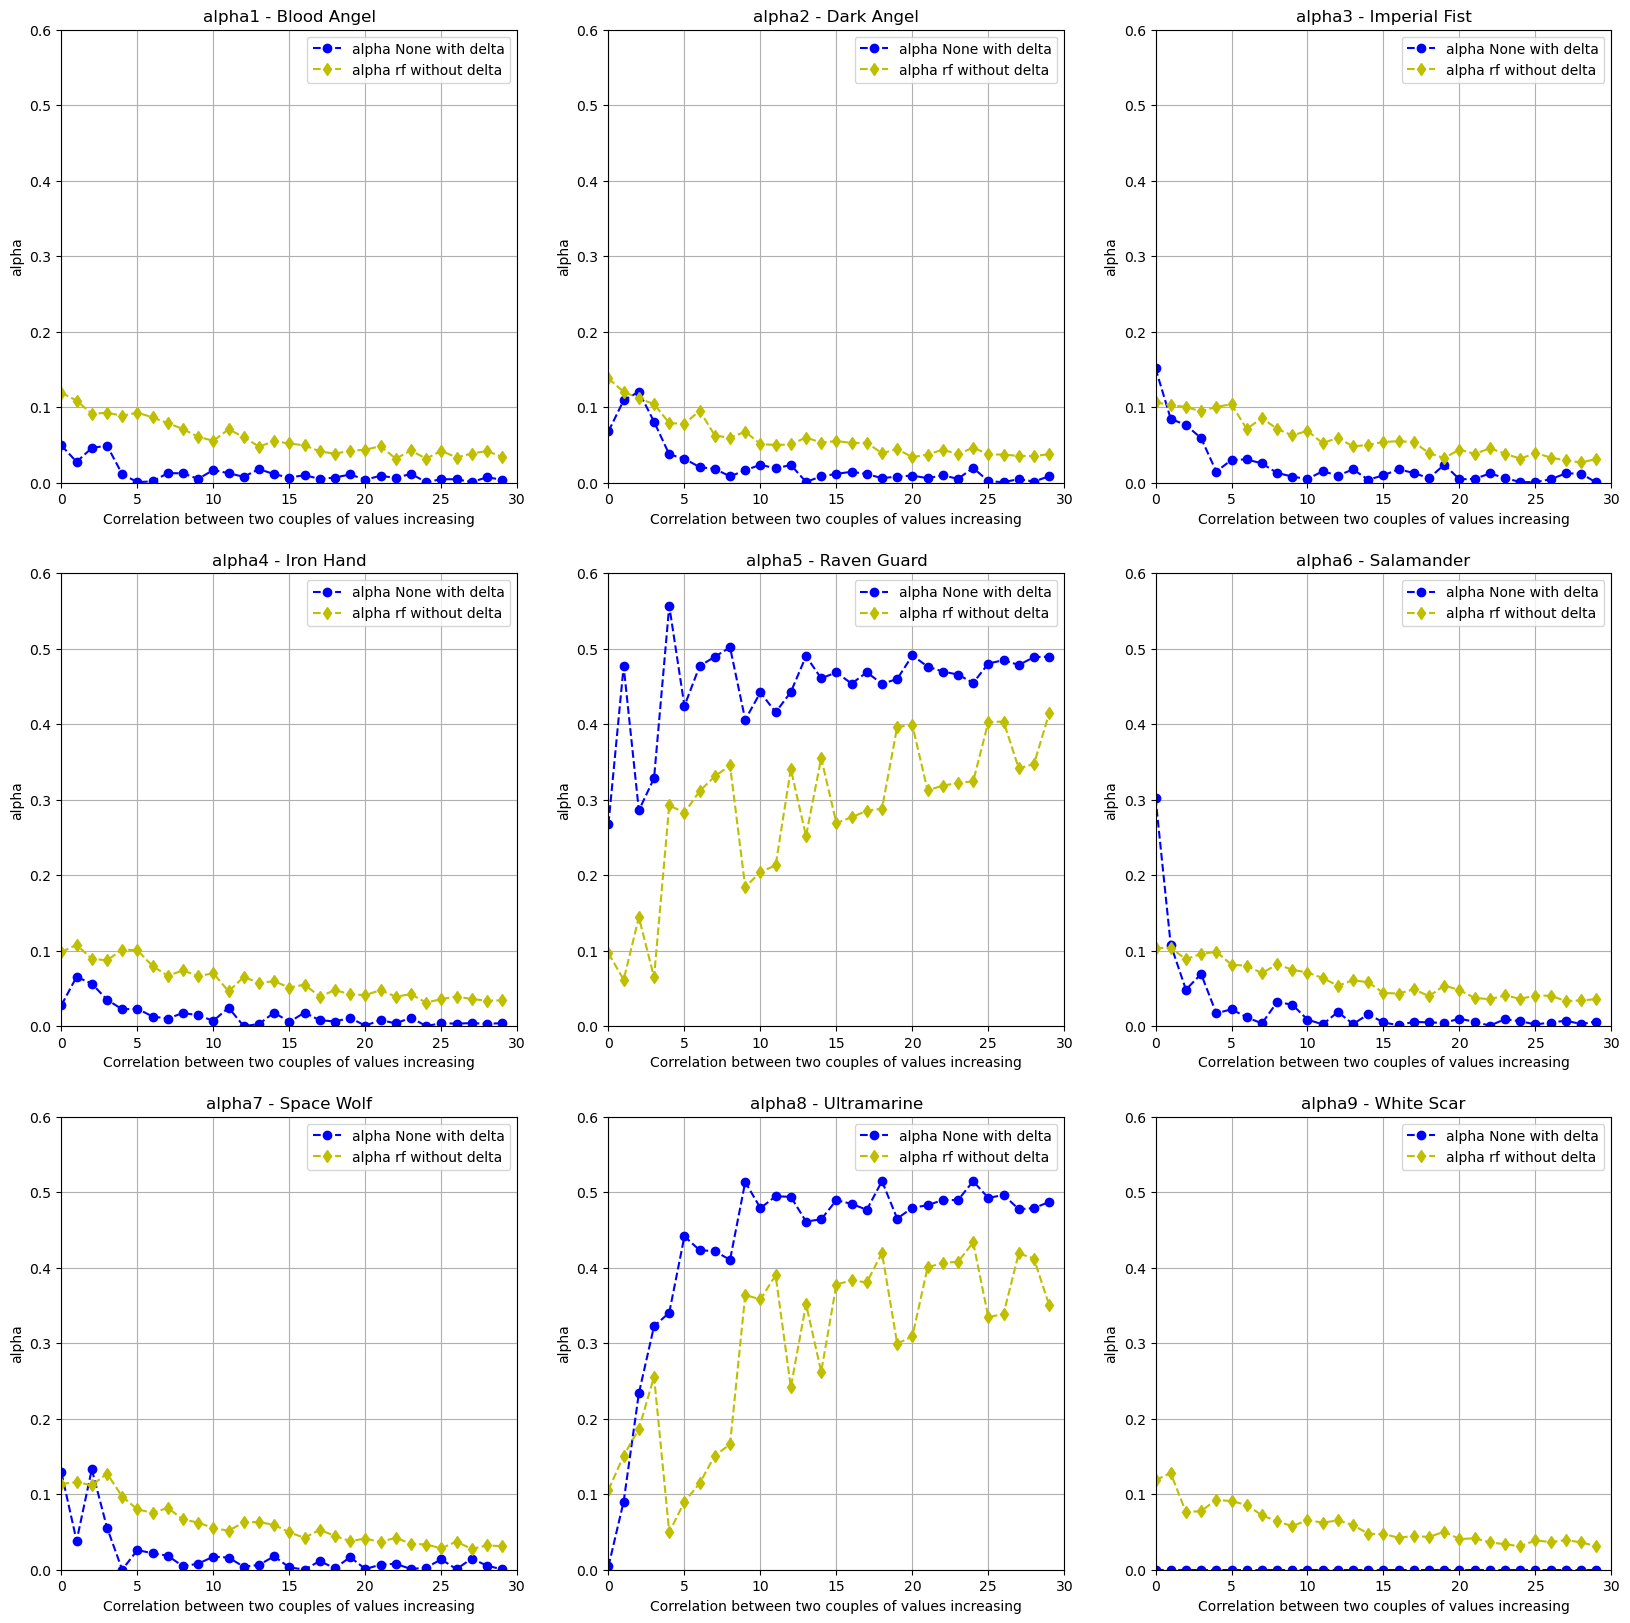

In [118]:
plot_coefficients_general(results_increasing_corr, "alpha", warriors, "Correlation between two couples of values increasing", zoom = 0.6)

## 4. Betas plots

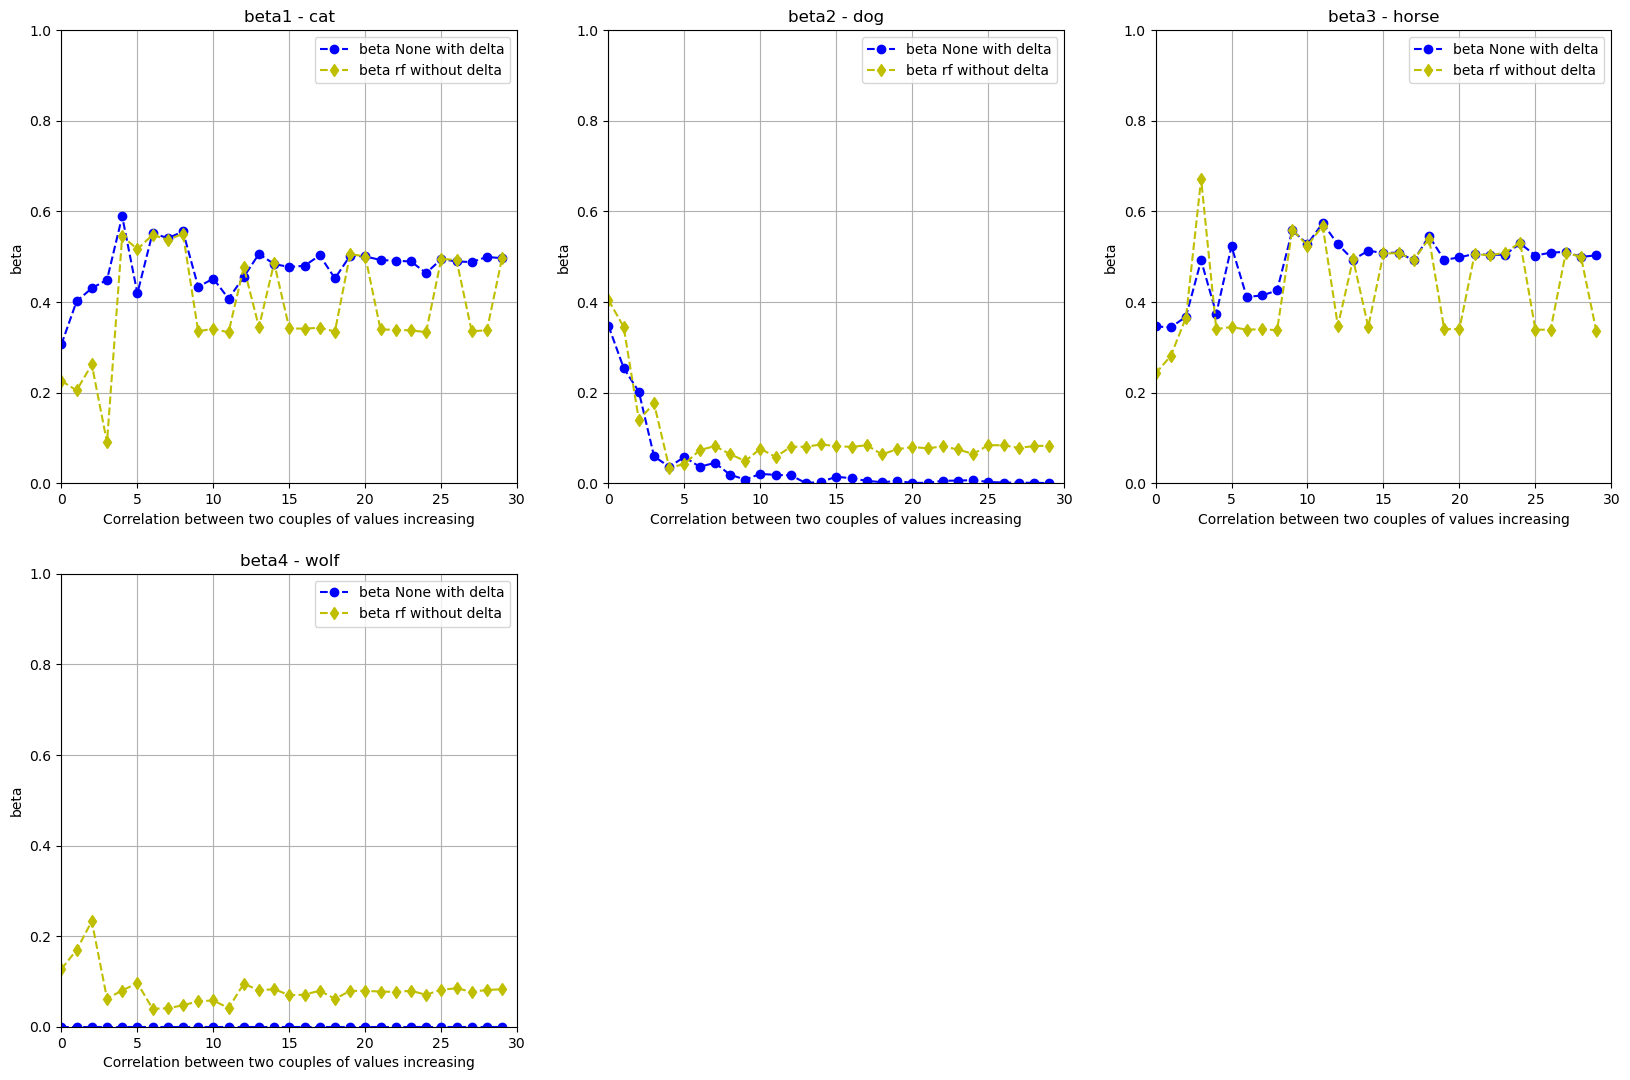

In [119]:
plot_coefficients_general(results_increasing_corr, "beta", animals, "Correlation between two couples of values increasing")

# 4. Correlation shift between two values

We've seen how the correlation and the coefficients vary when there are two couples of values with the same degree of correlation. In this experiment i tried to investigate how the coefficients interact when there are different values with different degrees of correlation.

## Dataset description

The datasets that i'll generate, similarly with those in experiment 3, will see the strenght of the correlations of two of its variables change. This time though, a value will start with a very strong (deterministic) correlation, while the other will be random. As the datasets generation will proceed, the two variables will slowly swap roles until, in the end, the one that was deterministic will be completely random, and viceversa.

In [120]:
def create_dataset_swapping_corr(iteration):

    war_i = []
    ani_i = []

    for j in range(50000):
        
        warrior=sample(warriors)

        war_i.append(warrior)

        if warrior == "Ultramarine":
            if rn.randint(1,29) > iteration:  
                anim = sample(animals)
            else:                  
                anim = "horse"
        elif warrior == "Raven Guard":
            if rn.randint(1,29) <= iteration:  
                anim = sample(animals)
            else:     
                anim="cat"
        else:
            anim = sample(animals)

        ani_i.append(anim)

    return war_i, ani_i

In [121]:
results_swapping_corr = experiment_general(create_dataset_swapping_corr, my_kernel_one_hot_with_delta, my_kernel_one_hot)

## 1. Correlations plots

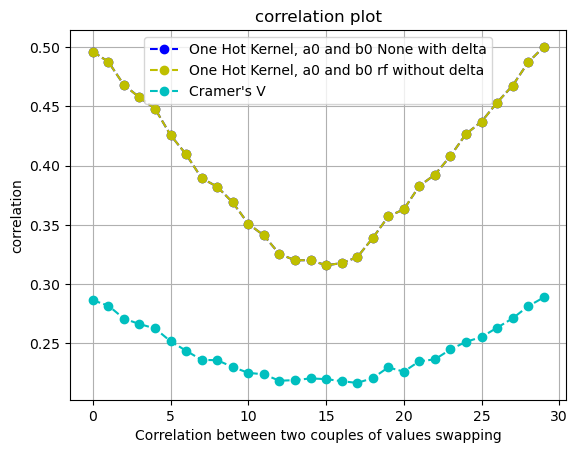

In [122]:
plot_results_general(results_swapping_corr, "correlation", "Correlation between two couples of values swapping")

It makes sense. In the middle both the correlated values are in a 50/50 zone: they are both at the same level, but still their respective correlation are not THAT strong. In the extrema, one of the values is no more correlated, while one of them stands at its maximum correlation: it makes sense that in these points the correlation boasts its maximum value, since there is a couple of values deterministically linked together.

## 2. Execution times

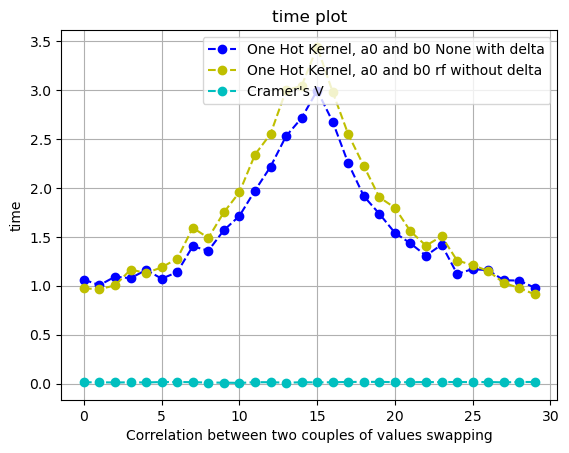

In [123]:
plot_results_general(results_swapping_corr, "time", "Correlation between two couples of values swapping")

## 3. Alphas plots

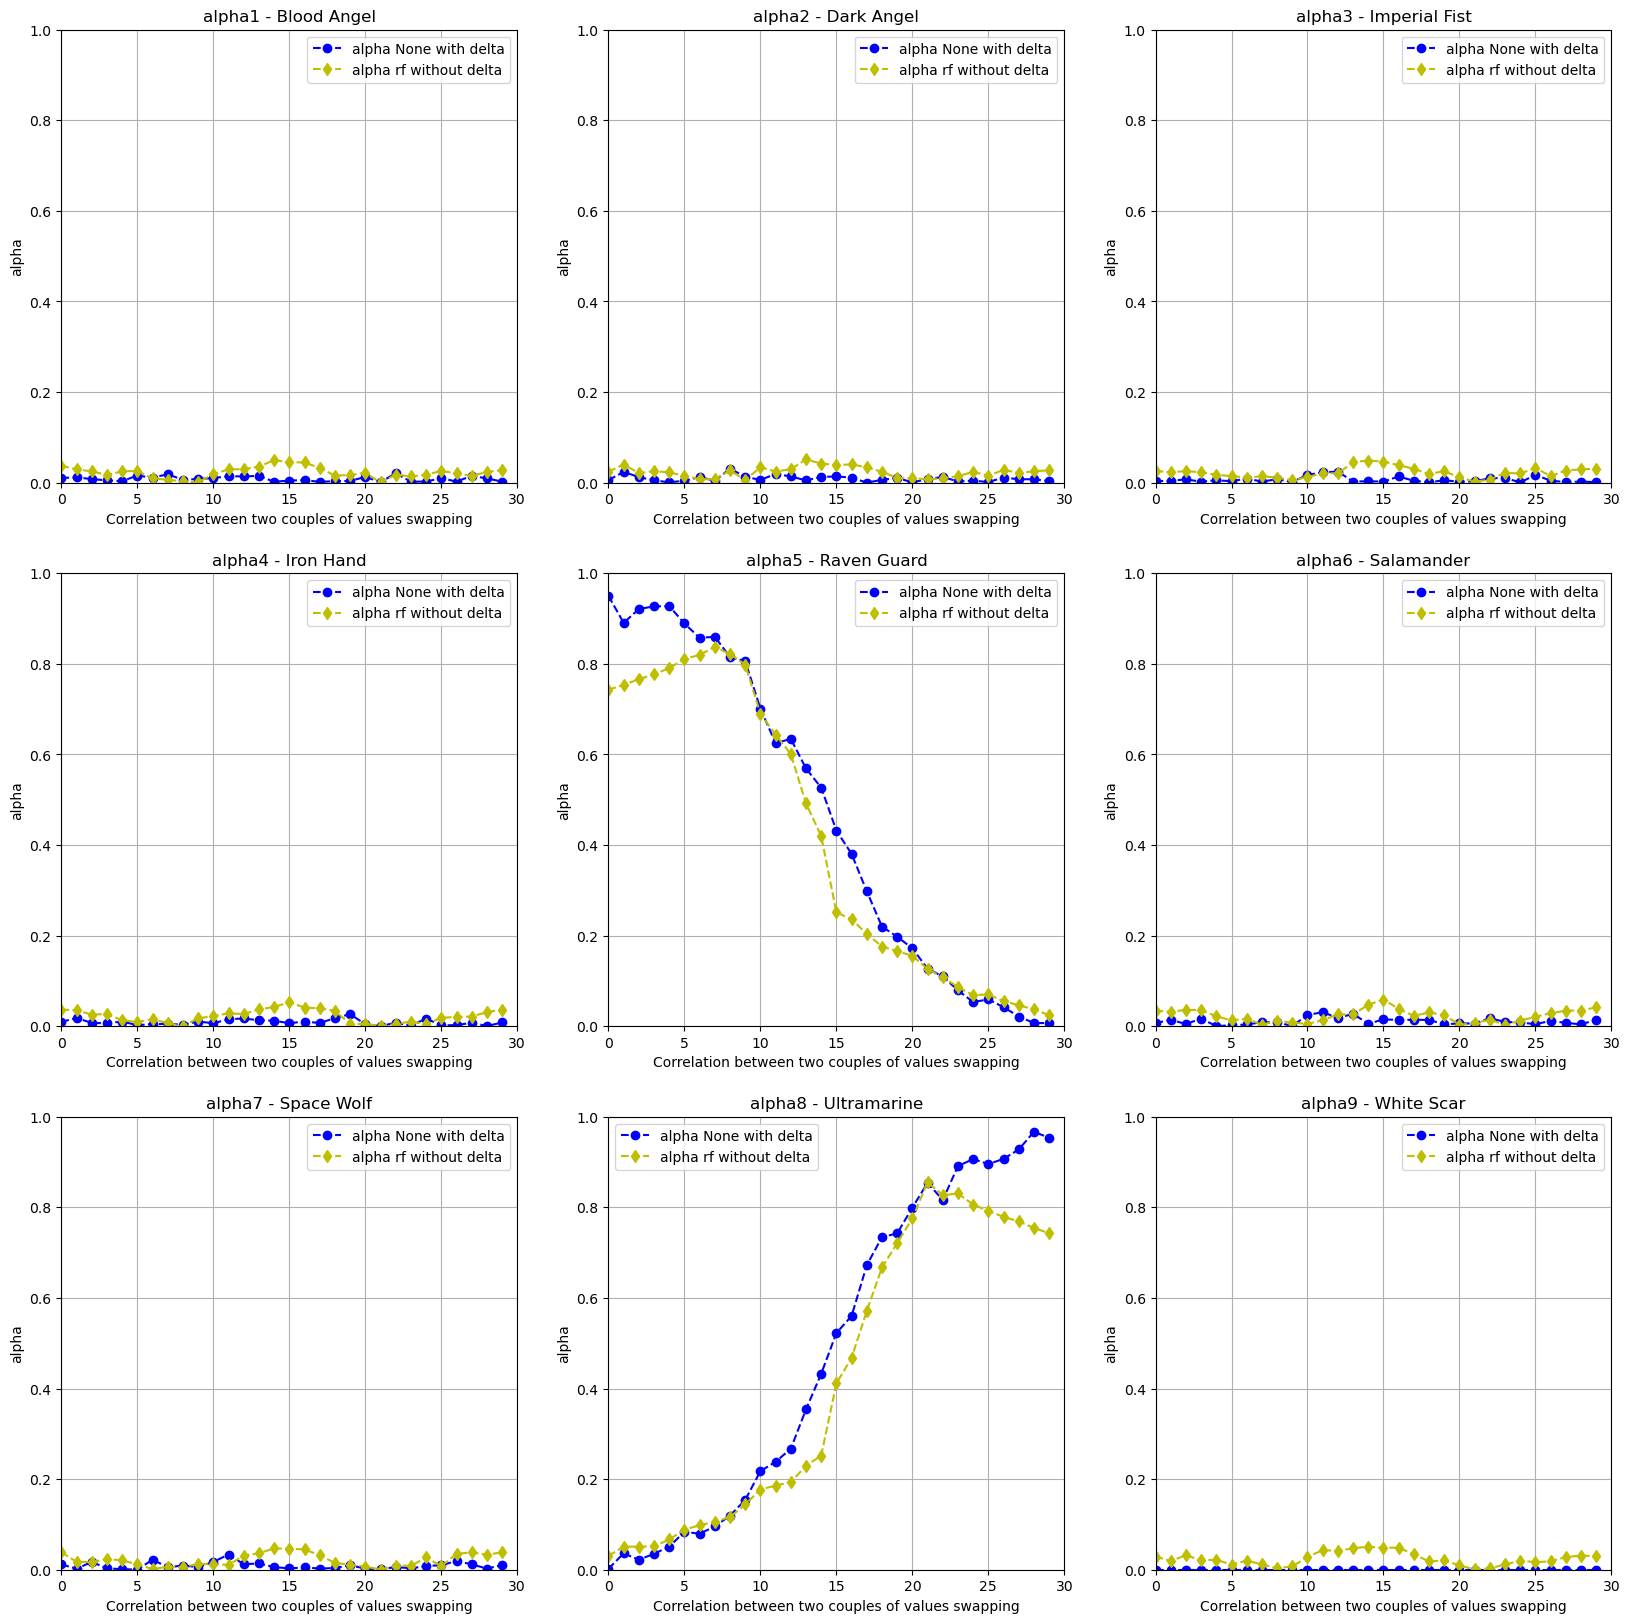

In [124]:
plot_coefficients_general(results_swapping_corr, "alpha", warriors, "Correlation between two couples of values swapping")

As the correlation becomes less strong (in the middle), the alphas of non correlated values tend to go up, while alphas of correlated values follow the strenghtening (or weakening) of the respective correlations (with the delta-using kernel behaving visibly in a more consistent way).

## 4. Betas plots

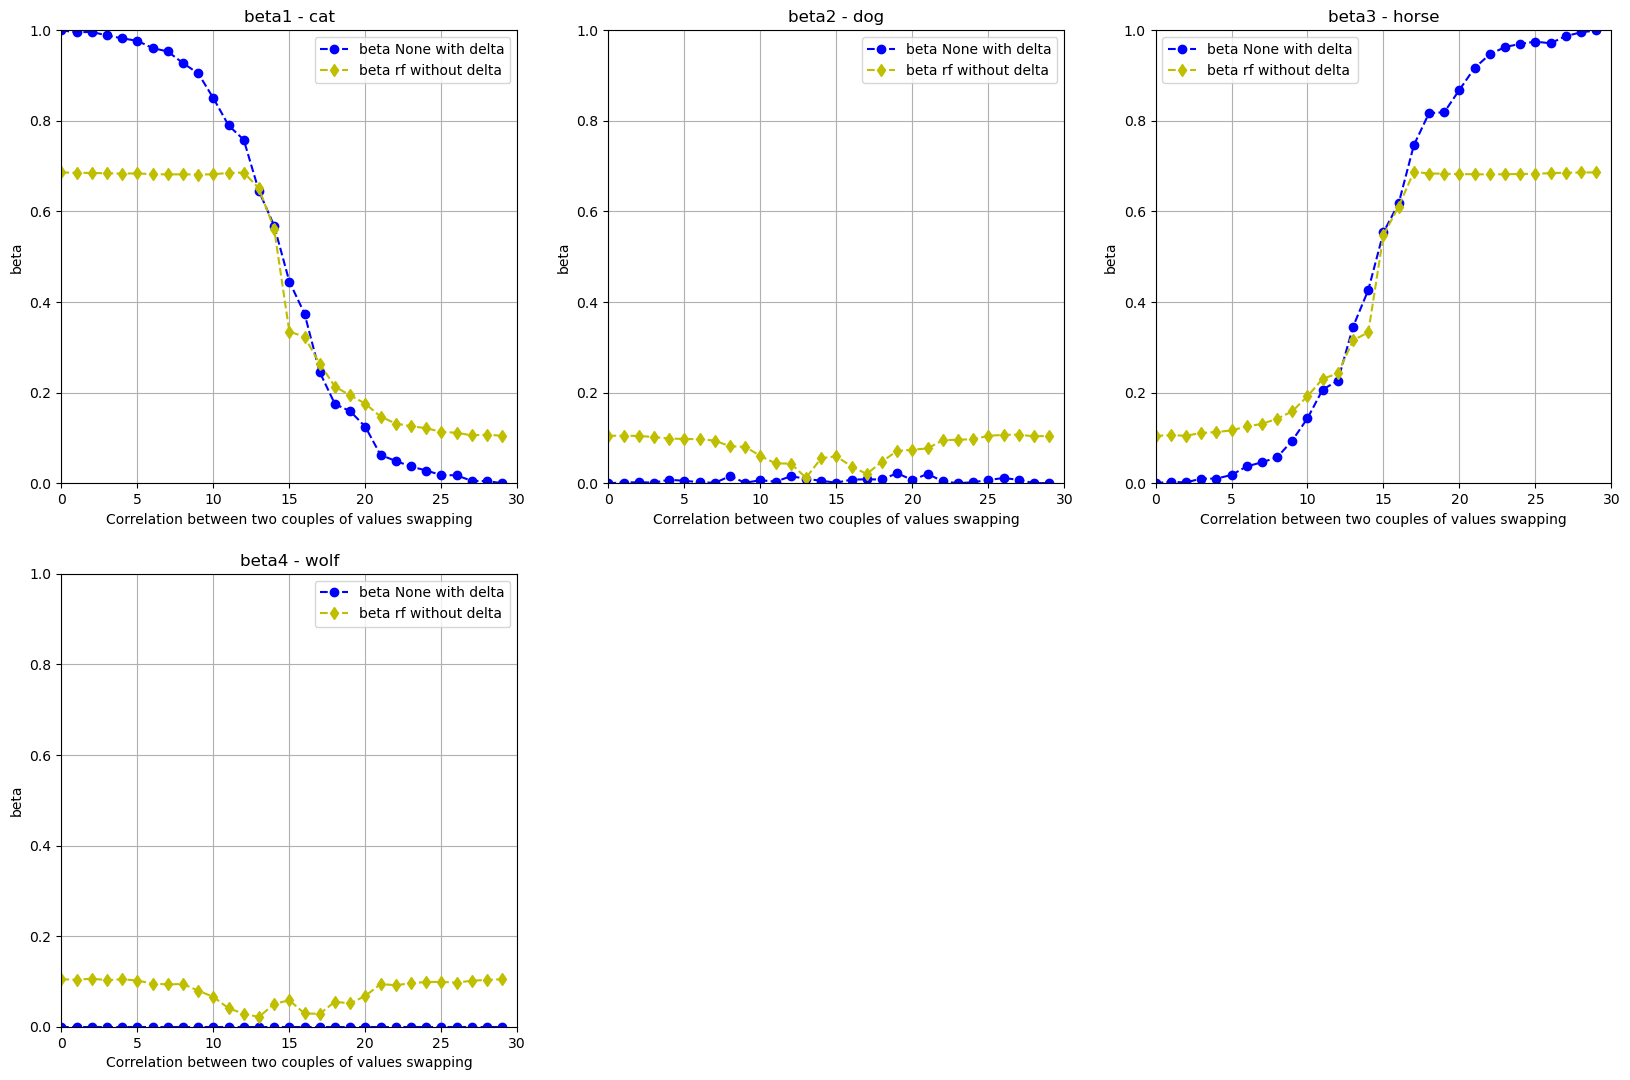

In [125]:
plot_coefficients_general(results_swapping_corr, "beta", animals, "Correlation between two couples of values swapping")

# 5. From totally random to completely deterministic

In this experiment i wanted to check two things:  

1. First, i wanted to be sure that a fully deterministic dataset would result in a correlation equal to 1
2. Second, i wanted to see how the coefficients would change between values with correlations of the same strenght but shared among a different number of values 

## Dataset description

The datasets that i'll generate, similarly with those in experiment 3, will see the strenght of the correlations of its variables change. This time though, all values will see their correlations increased, not just two as in the previous experiments.

In [127]:
def create_dataset_rand_det(iteration):

    war_i = []
    ani_i = []

    for j in range(50000):
        
        warrior=sample(warriors)

        war_i.append(warrior)

        if rn.randint(1,29) > iteration:  
            anim = sample(animals)
        elif warrior in ['Blood Angel', 'Dark Angel', 'Imperial Fist']:
            anim = "cat"
        elif warrior in ['Iron Hand', 'Raven Guard', 'Salamander']:
            anim = "dog"
        elif warrior in ['Space Wolf', 'Ultramarine']:
            anim = "horse"
        else: 
            anim = "wolf"

        ani_i.append(anim)

    return war_i, ani_i

In [128]:
results_rand_det = experiment_general(create_dataset_rand_det, my_kernel_one_hot_with_delta, my_kernel_one_hot)

## 1. Correlations plots

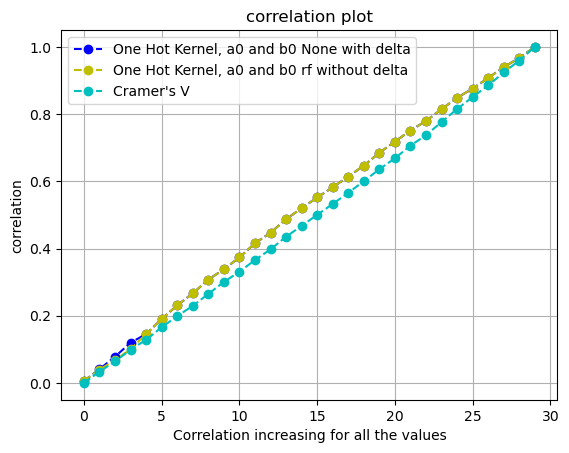

In [129]:
plot_results_general(results_rand_det, "correlation", "Correlation increasing for all the values")

## 2. Execution times

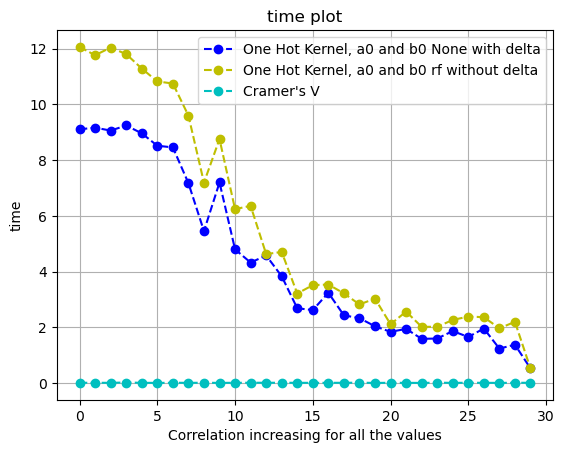

In [130]:
plot_results_general(results_rand_det, "time", "Correlation increasing for all the values")

As we've already seen, as the correlation becomes more evident the time to compute it dwindles.

## 3. Alphas plots

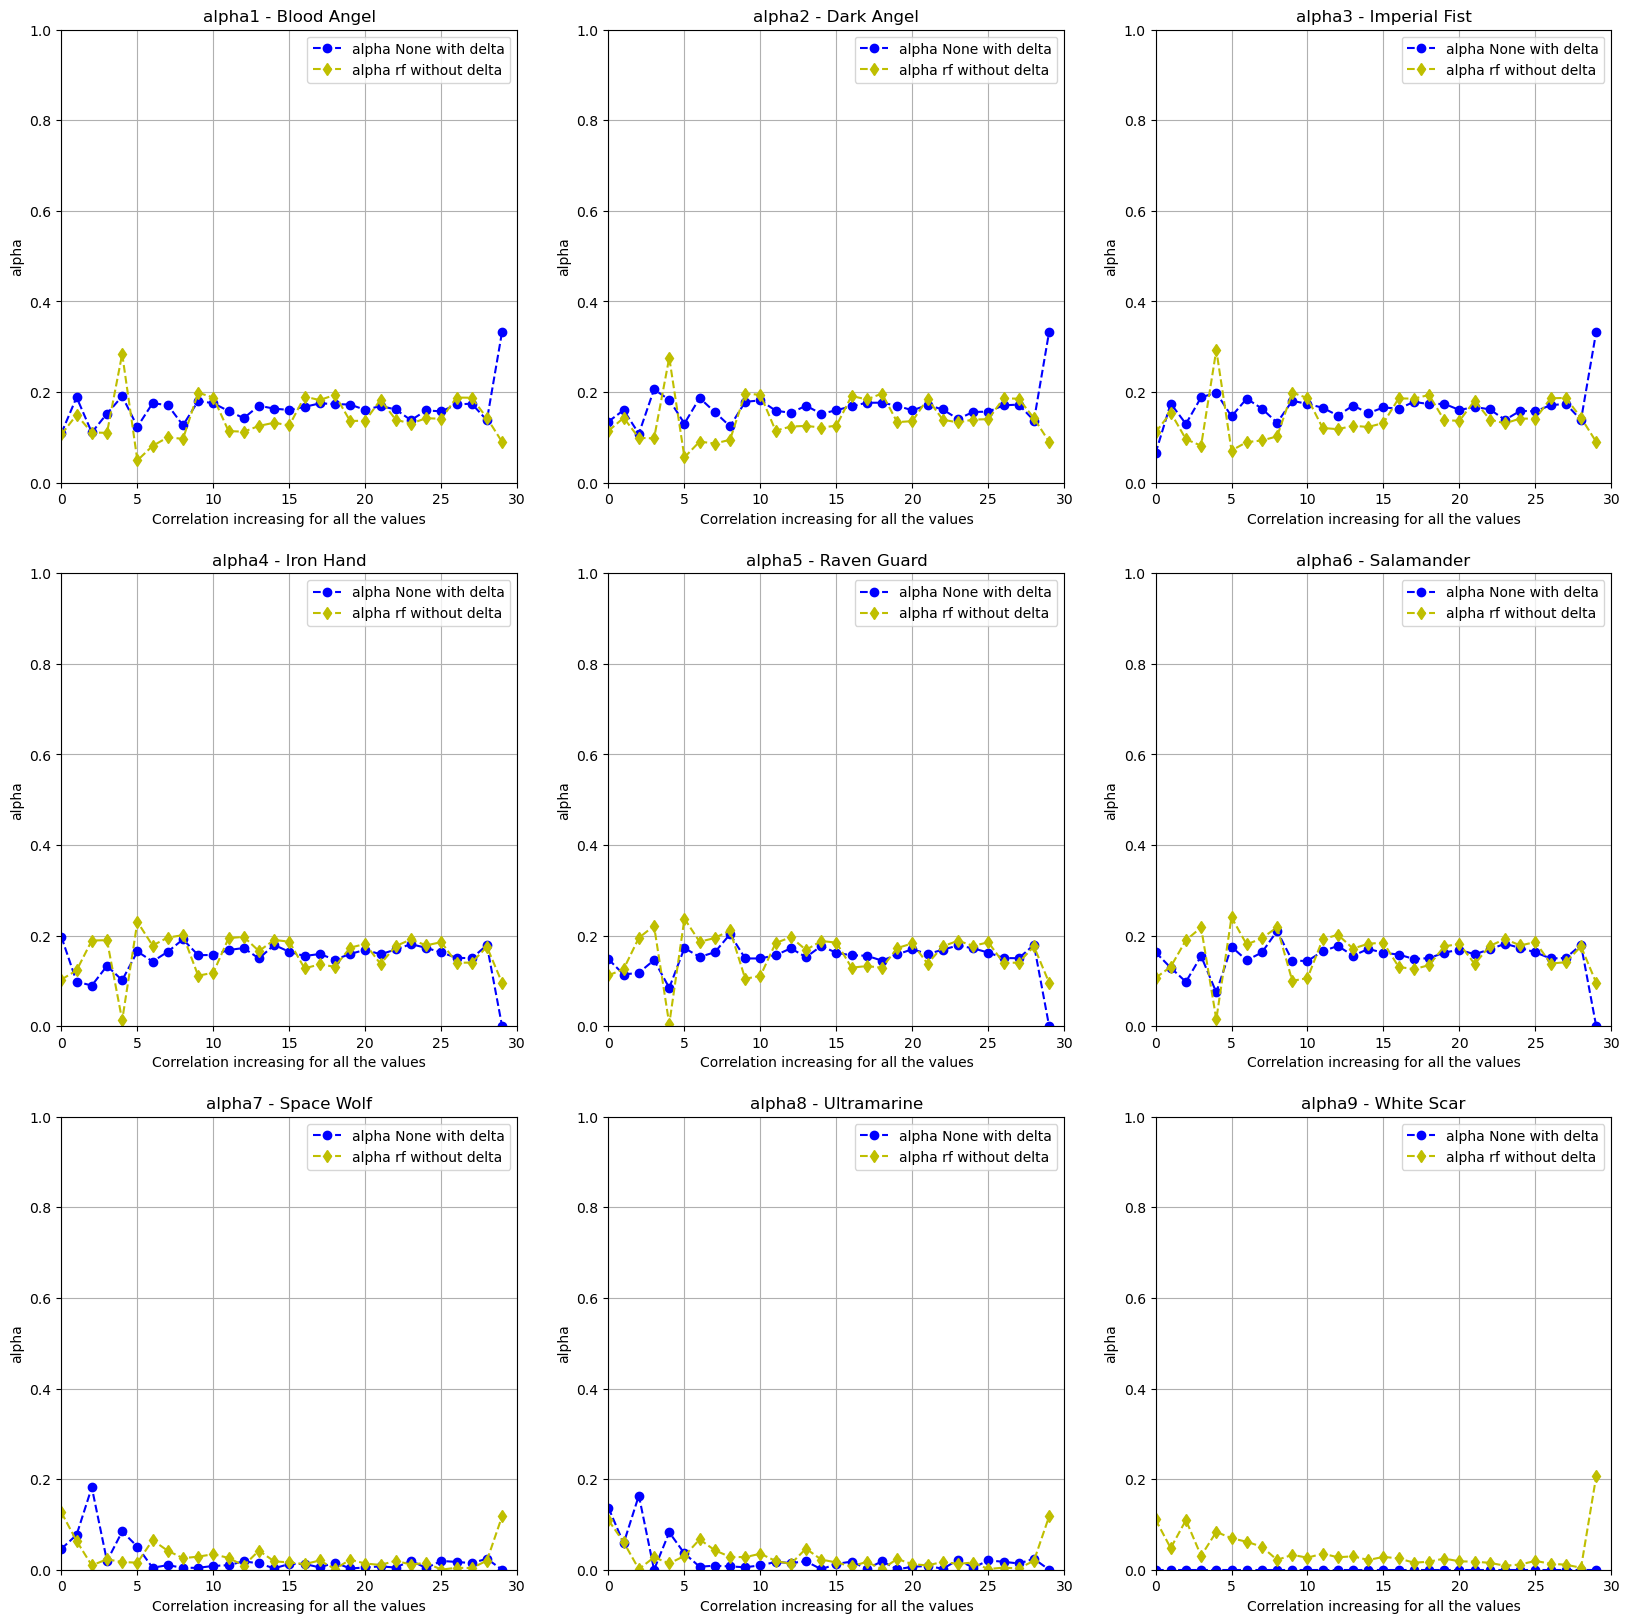

In [131]:
plot_coefficients_general(results_rand_det, "alpha", warriors, "Correlation increasing for all the values")

Let's zoom a bit:

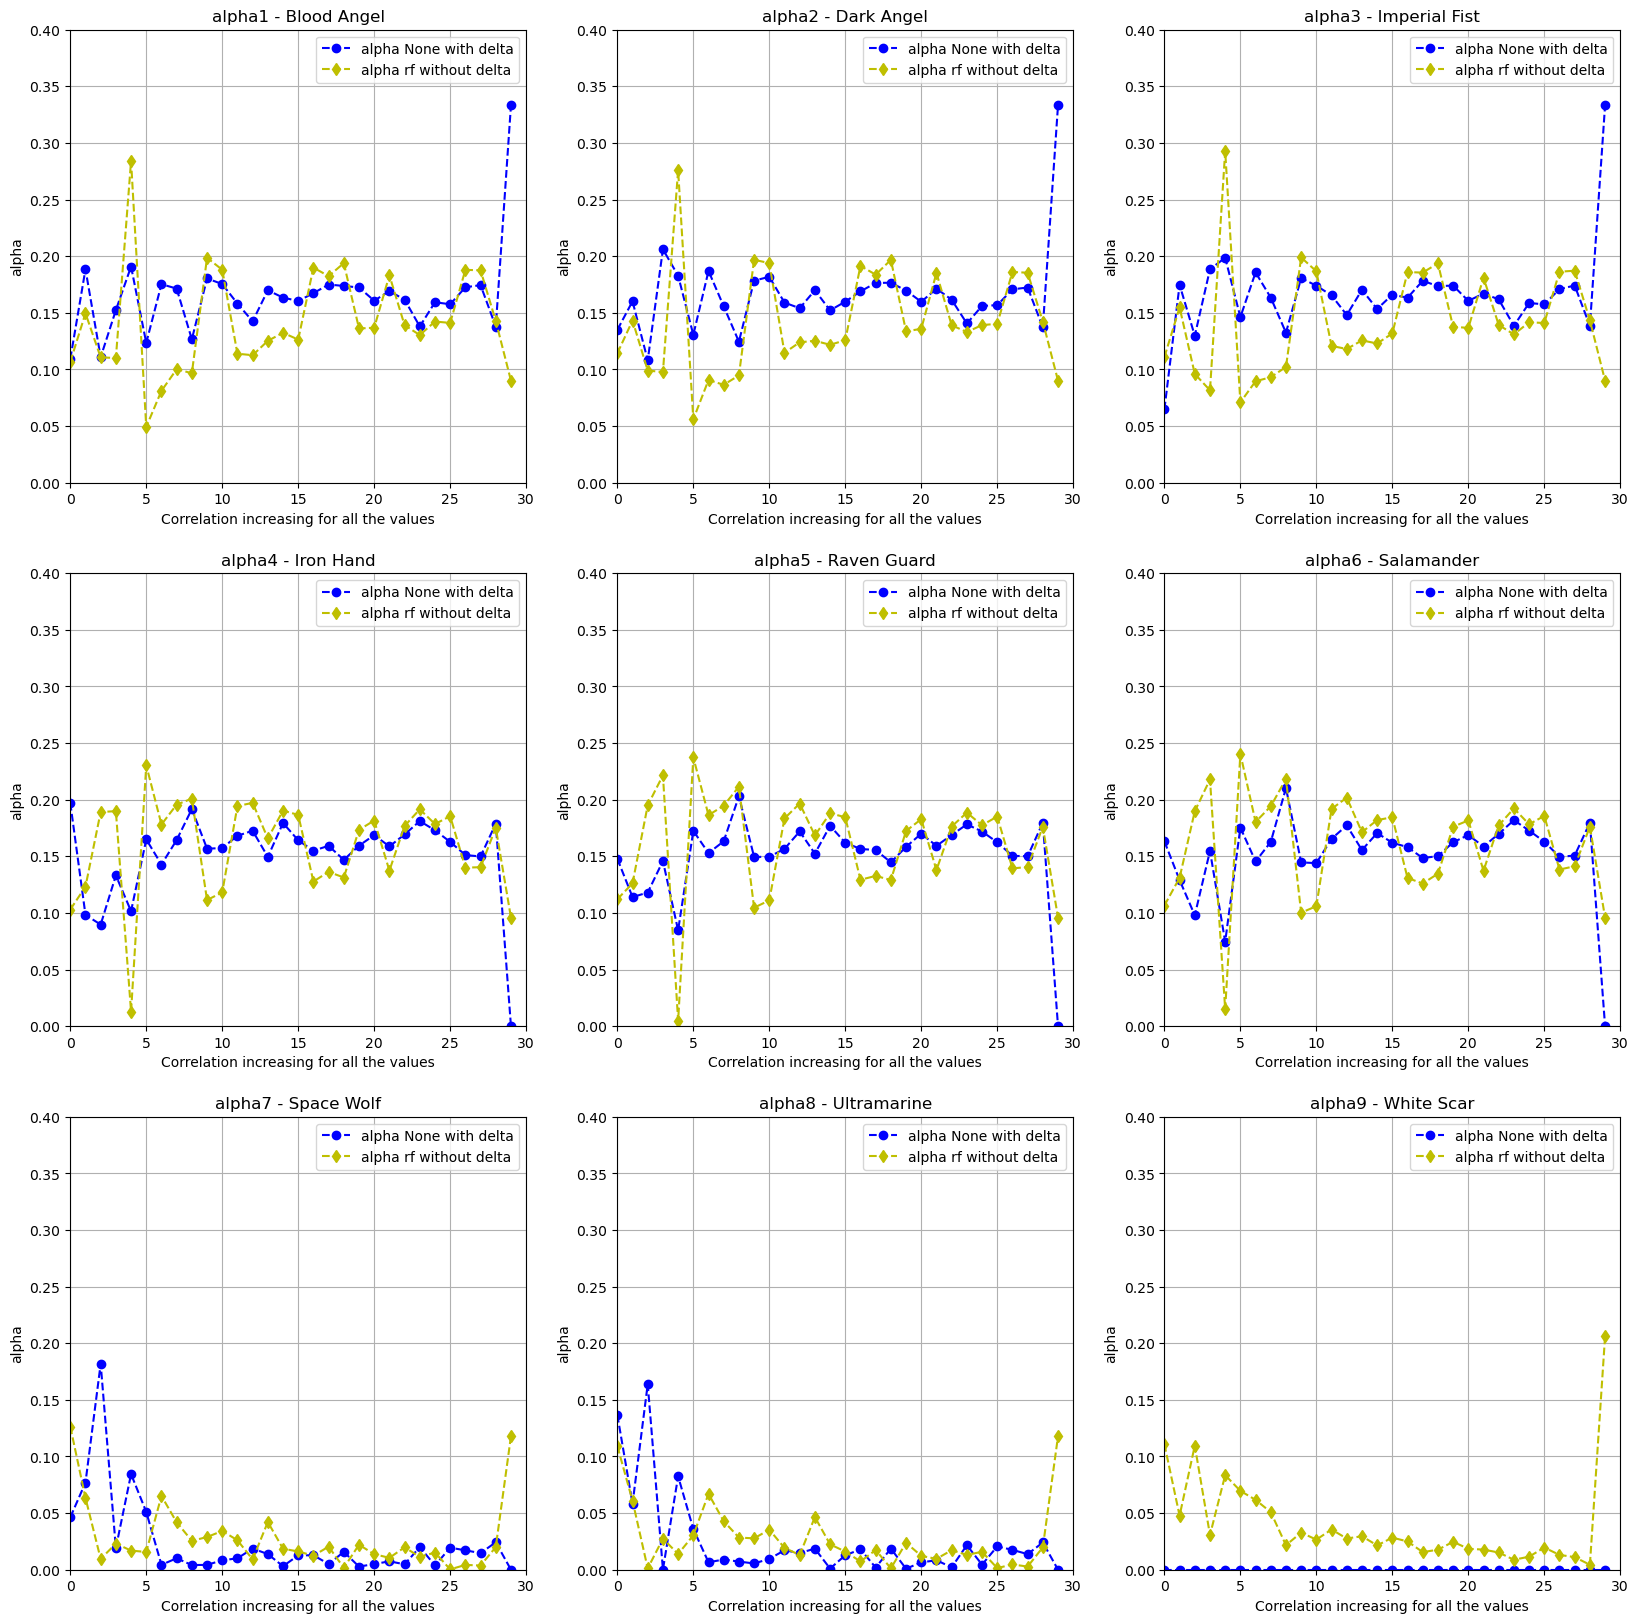

In [132]:
plot_coefficients_general(results_rand_det, "alpha", warriors, "Correlation increasing for all the values", zoom = 0.4)

1. The numbers of "rf" makes sense. For what concernes the first 6 coefficients, each of the corresponding value shares the corresponding correlated value with another 2 values. The third-to-last and second-to-last share the same correlated value, while the last one is the only one correlated to its specific correlated value. That's why the first 6 coefficients are smaller, and they get bigger as the correlated value is shared between less values.

2. We can also note that from step 28 to step 29 (fully deterministic) the last 3 alphas "jump" from being really close to 0 to be further than it (especially the last alpha, the more correlated since it alone is correlated with the value "wolf")

**NOTE**: the values have more or less the same frequency, so the differences in the coefficients are due only to the different strenght of their correlations

## 4. Betas plots

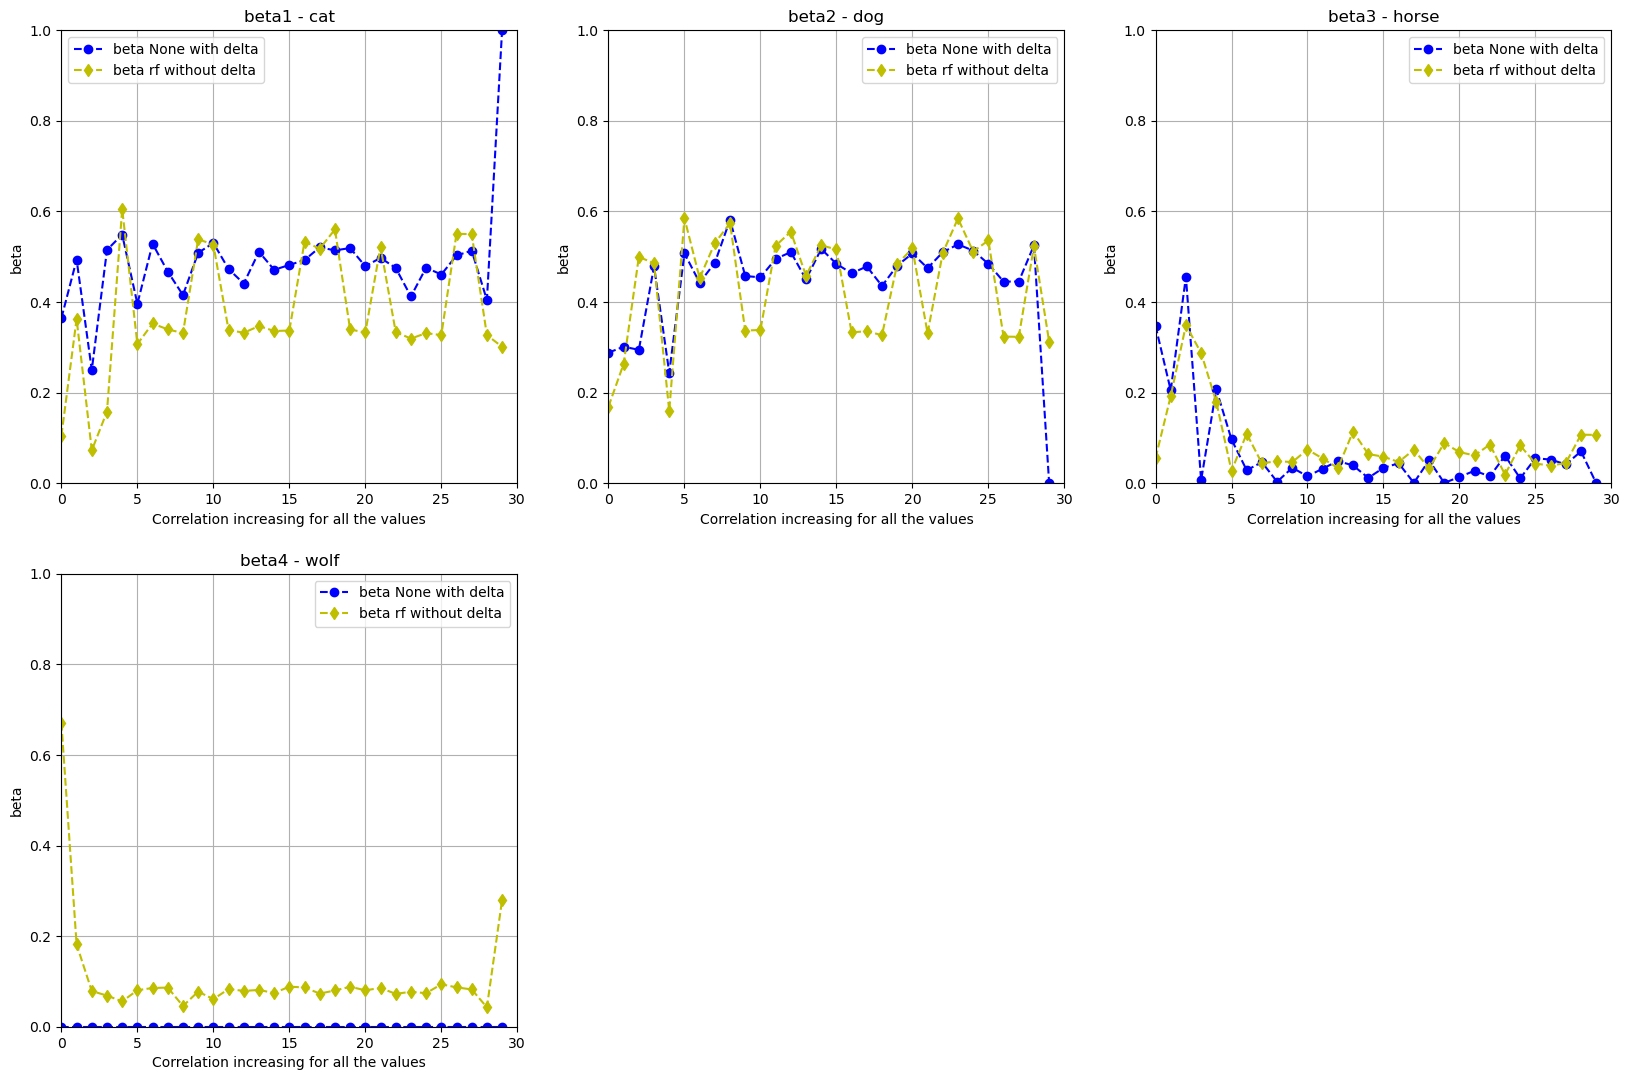

In [133]:
plot_coefficients_general(results_rand_det, "beta", animals, "Correlation increasing for all the values")

("rf") Again there is a visible change in the values of the betas from step 28 to step 29: they jump, especially the last one and the second to last.  
For what concernes their values, i was at first a bit baffled: i would have expected the first two to be smaller, the second in the middle ground and the last to be the biggest one.
We should keep in mind though that the first two values are more frequent than the third and in turn, the third is a lot more frequent than the last one.   
So, going from left to right frequency decreases, while the strenght of the correlation increases. We note that the absolute value of the first two variables and that of the last one are roughly the same: we could think that the lower frequency of the last value is made up by the bigger correlation it has. The reason behind the third coefficient being ~0.1 is harder to grasp.

**NOTE**: in this case the values does NOT have the same frequency, so their coefficient's values are due both to their frequency AND to the strenght of their correlations.

# 6. Kernel one-hot VS Polynomial Kernel

When categories are integer numbers we can still use polynomial kernels. To compare their performance with one hot kernels, i've changed the categories used so far into integer numbers. For what concernes the kernels, i've compared a one hot kernel initialized with "rf" and no delta with a polynomial kernel of degrees 9 and 4 initialized with "None" and with delta.

## Dataset description

The dataset has te same characteristics of the one used in experiment 0.1, that is: two couples of values are very correlated, while all others are random. The only difference is that now, instead of categories, we have integer numbers.

In [148]:
def create_dataset_hot_poly():

    war_i = []
    ani_i = []

    for j in range(50000):
        
        warrior=sample(list(range(1,10)))

        war_i.append(warrior)

        if warrior == 9:
            anim = 3
        elif warrior == 5:
            anim = 1
        else:
            anim = sample(list(range(1,5)))

        ani_i.append(anim)

    return war_i, ani_i

In [149]:
results_hot_poly = experiment_hot_poly(create_dataset_hot_poly, polynomial_kernel, my_kernel_one_hot)

## 1. Correlations plots

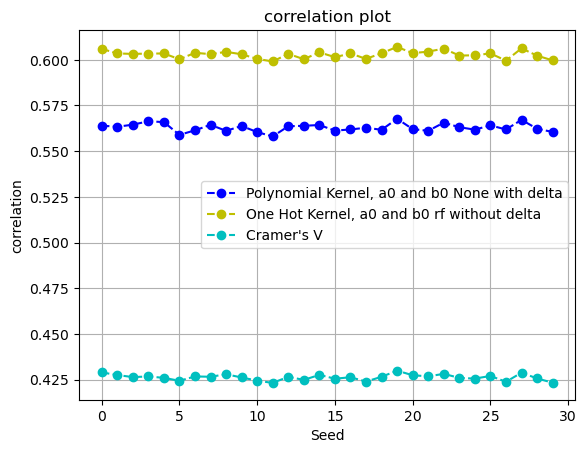

In [151]:
plot_results_hot_poly(results_hot_poly, "correlation", "Seed")

## 2. Execution times

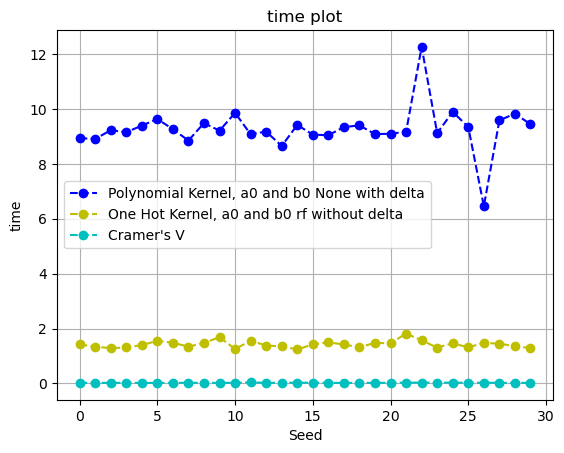

In [152]:
plot_results_hot_poly(results_hot_poly, "time", "Seed")

## 3. Alphas plots

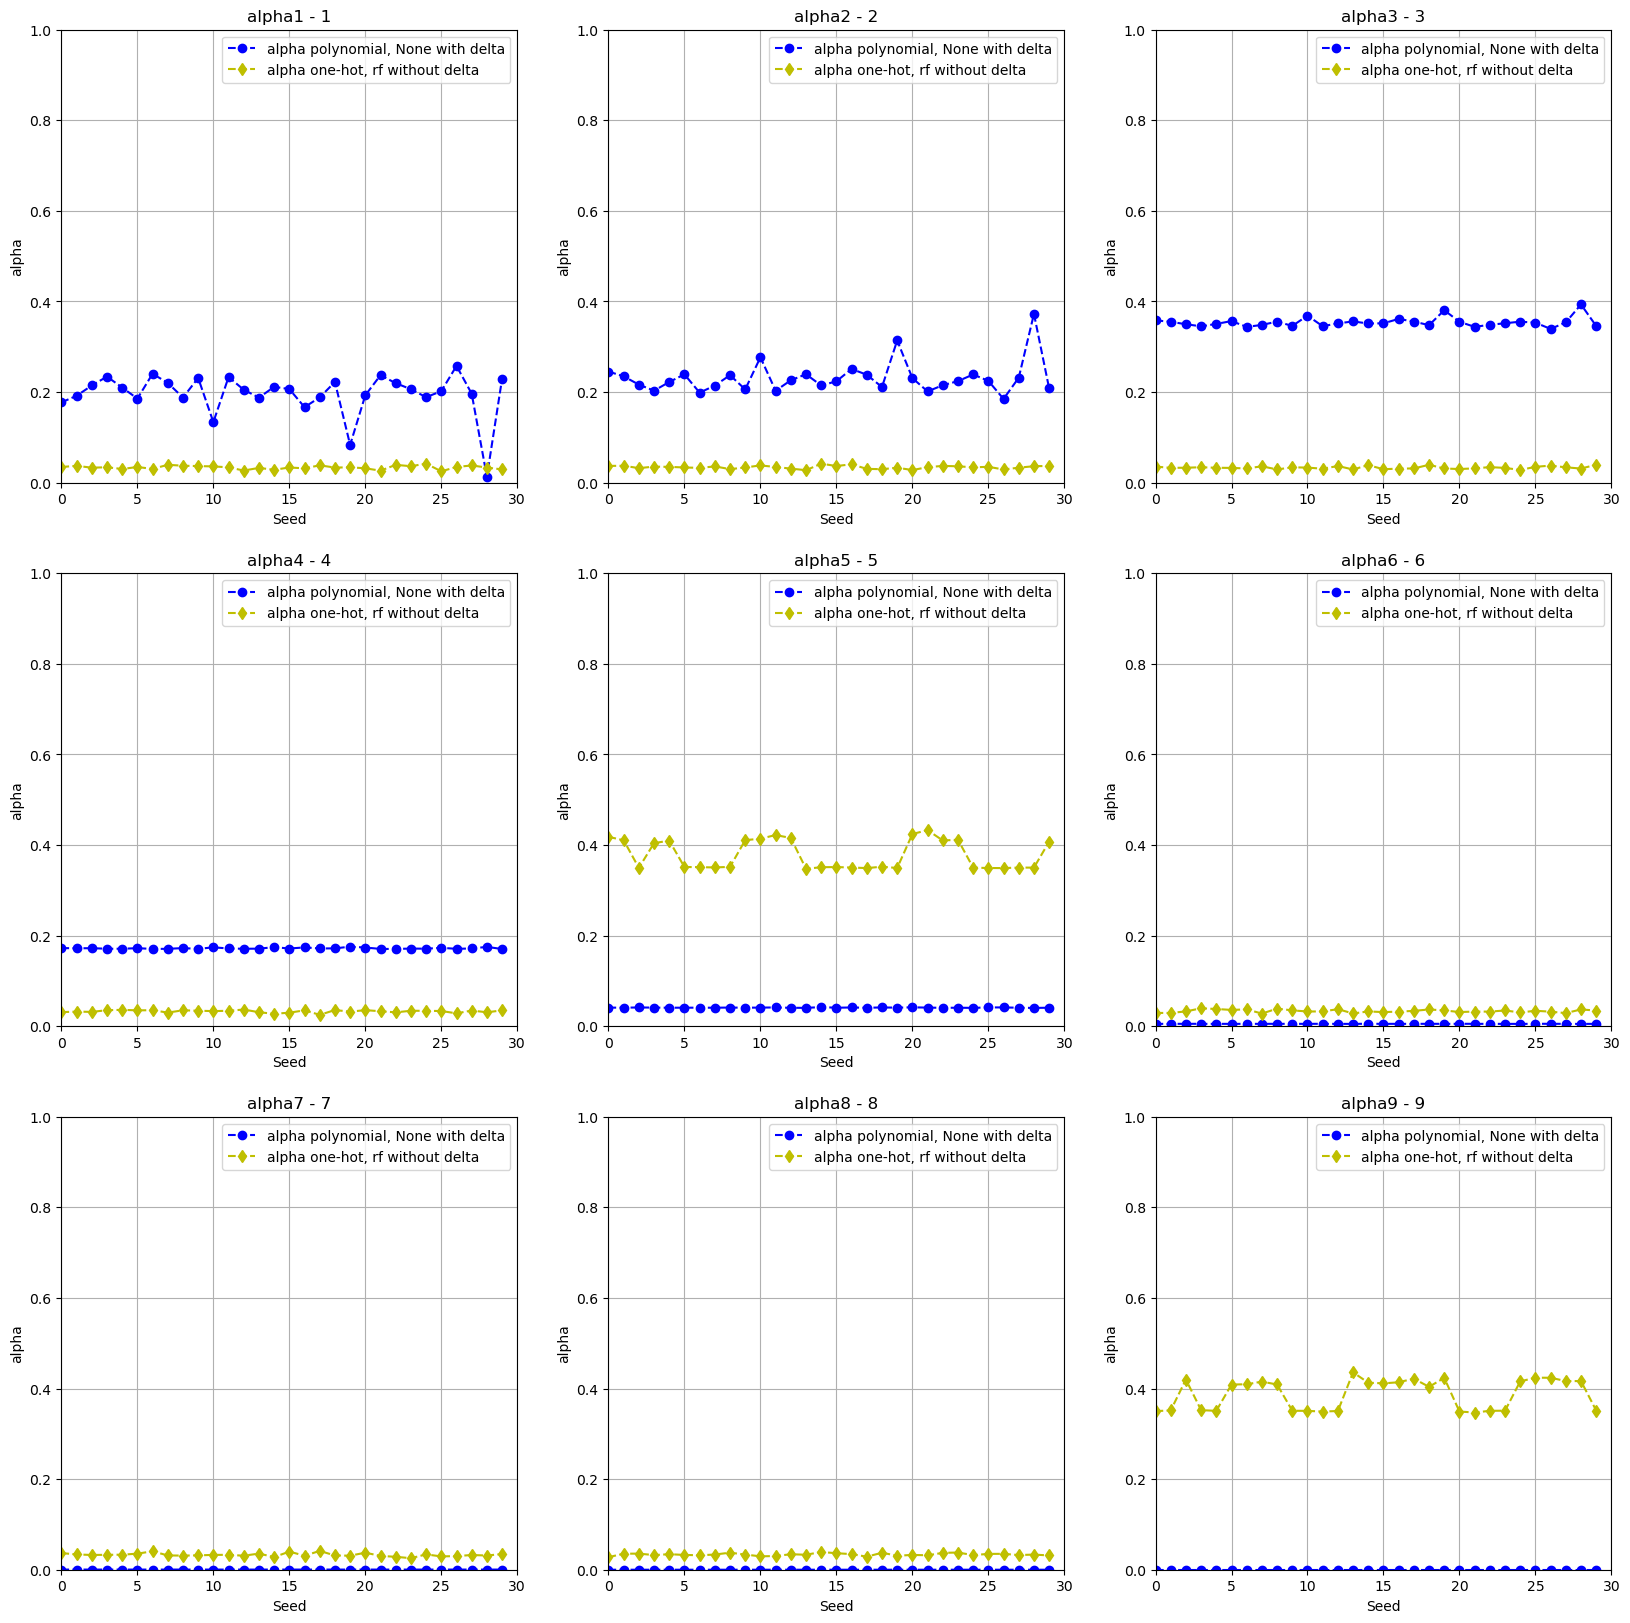

In [155]:
plot_coefficients_hot_poly(results_hot_poly, "alpha", list(range(1,10)), "Seed")

## 4. Betas plots

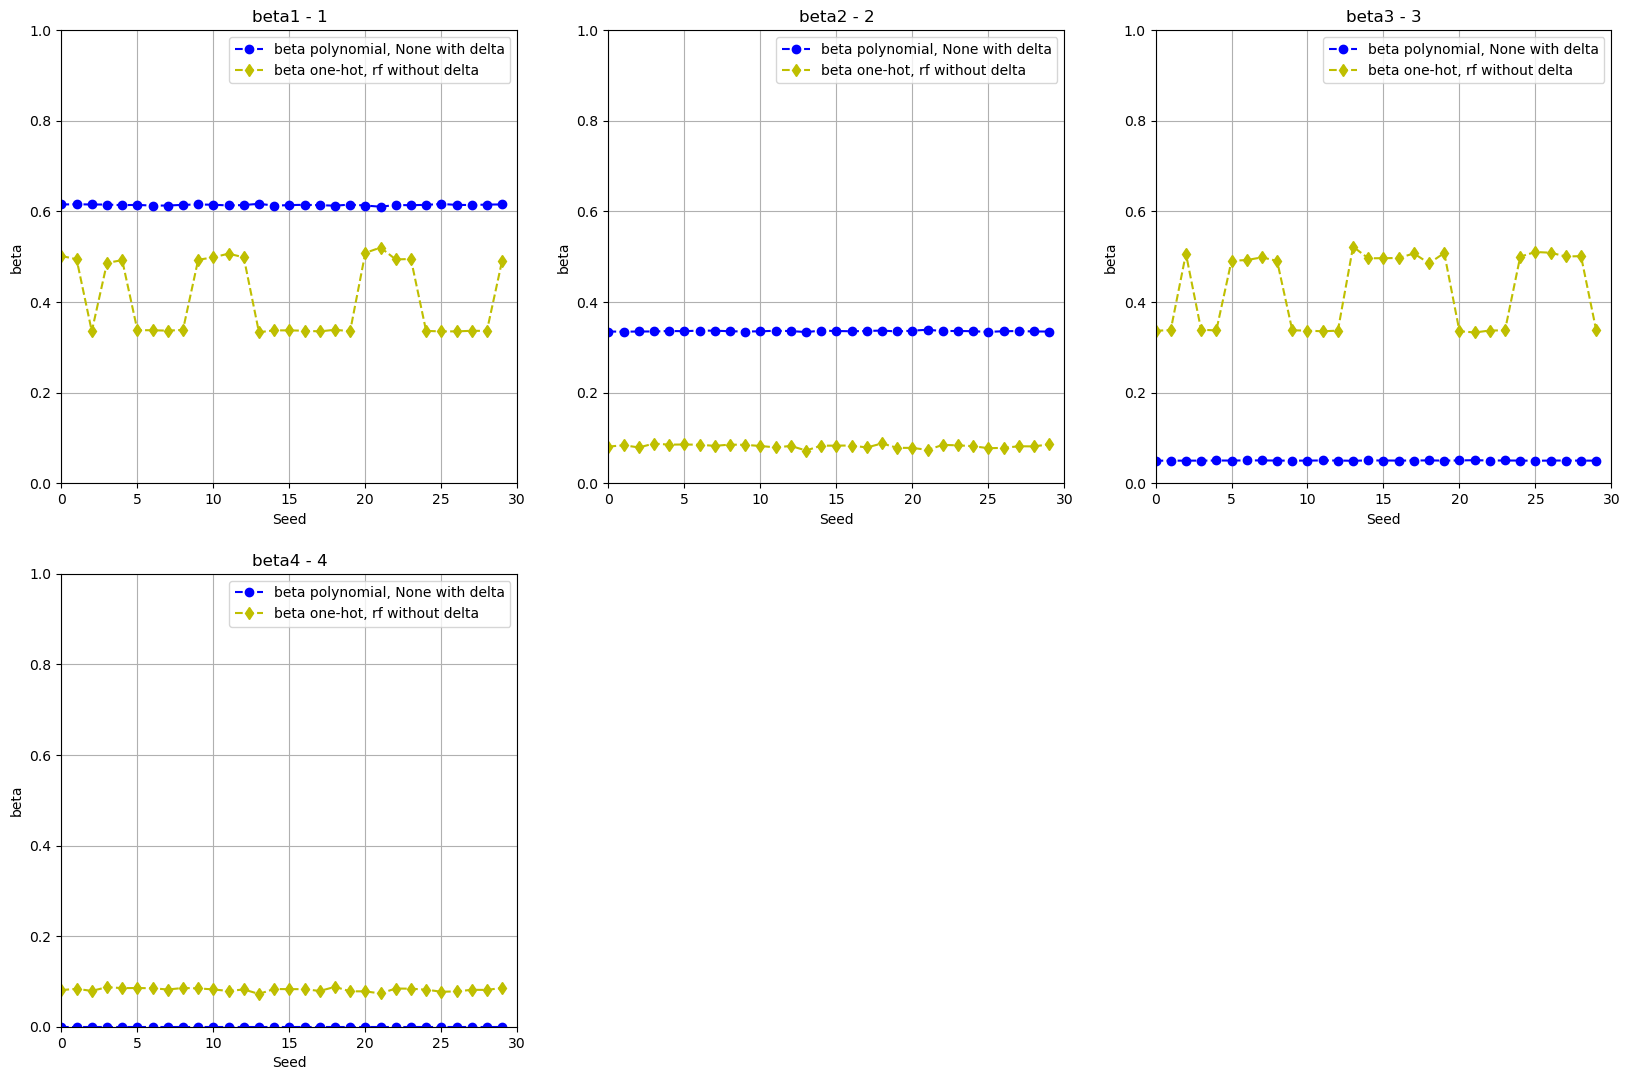

In [157]:
plot_coefficients_hot_poly(results_hot_poly, "beta", list(range(1,5)), "Seed")

One hot coefficients are more interpretable when it comes to categorical variables.

# 7. Real Data Example [REAL DATA]

In [159]:
adult = fetch_ucirepo(id=2) 
adult_features = adult.data.features.dropna() 
adult_features = adult_features[~adult_features.isin(['?']).any(axis=1)]

In [163]:
adult_features.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country  
0          2174             0              40  United-States  
1             0             0              13  United-States  
2             0             0              40  United-States  
3             0             0              40  United-States  
4             0             0              40           Cuba

## 8.1 Occupation and Education

In [164]:
sorted_occup = np.unique(adult_features["occupation"])
print(sorted_occup)

['Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transport-moving']


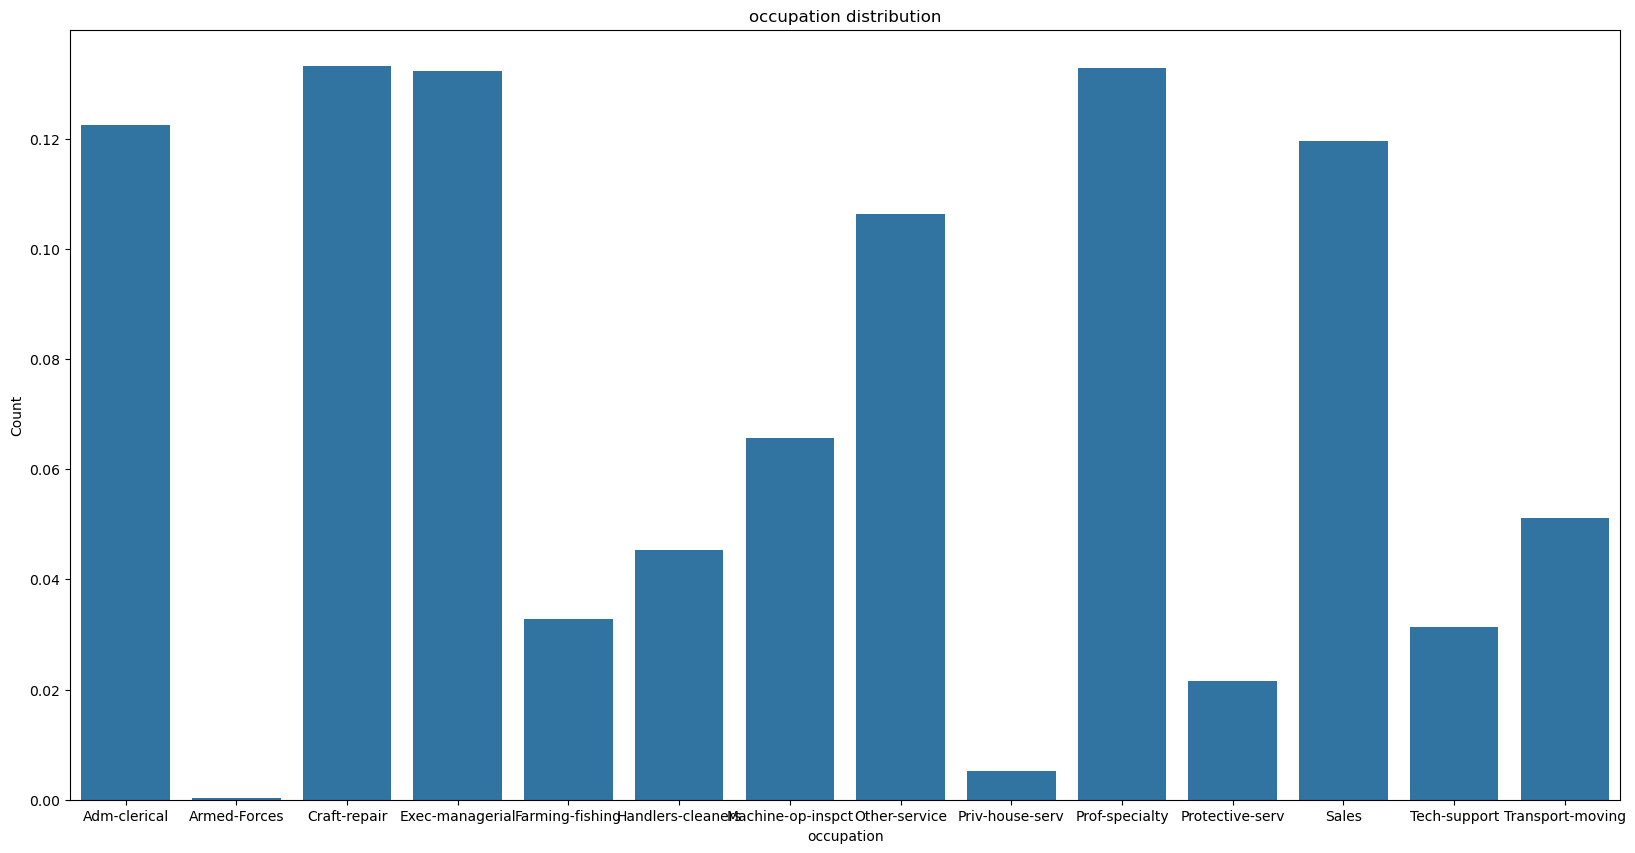

In [238]:
plot_hist(adult_features, "occupation")

In [166]:
sorted_edu = np.unique(adult_features["education"])
print(sorted_edu)

['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college']


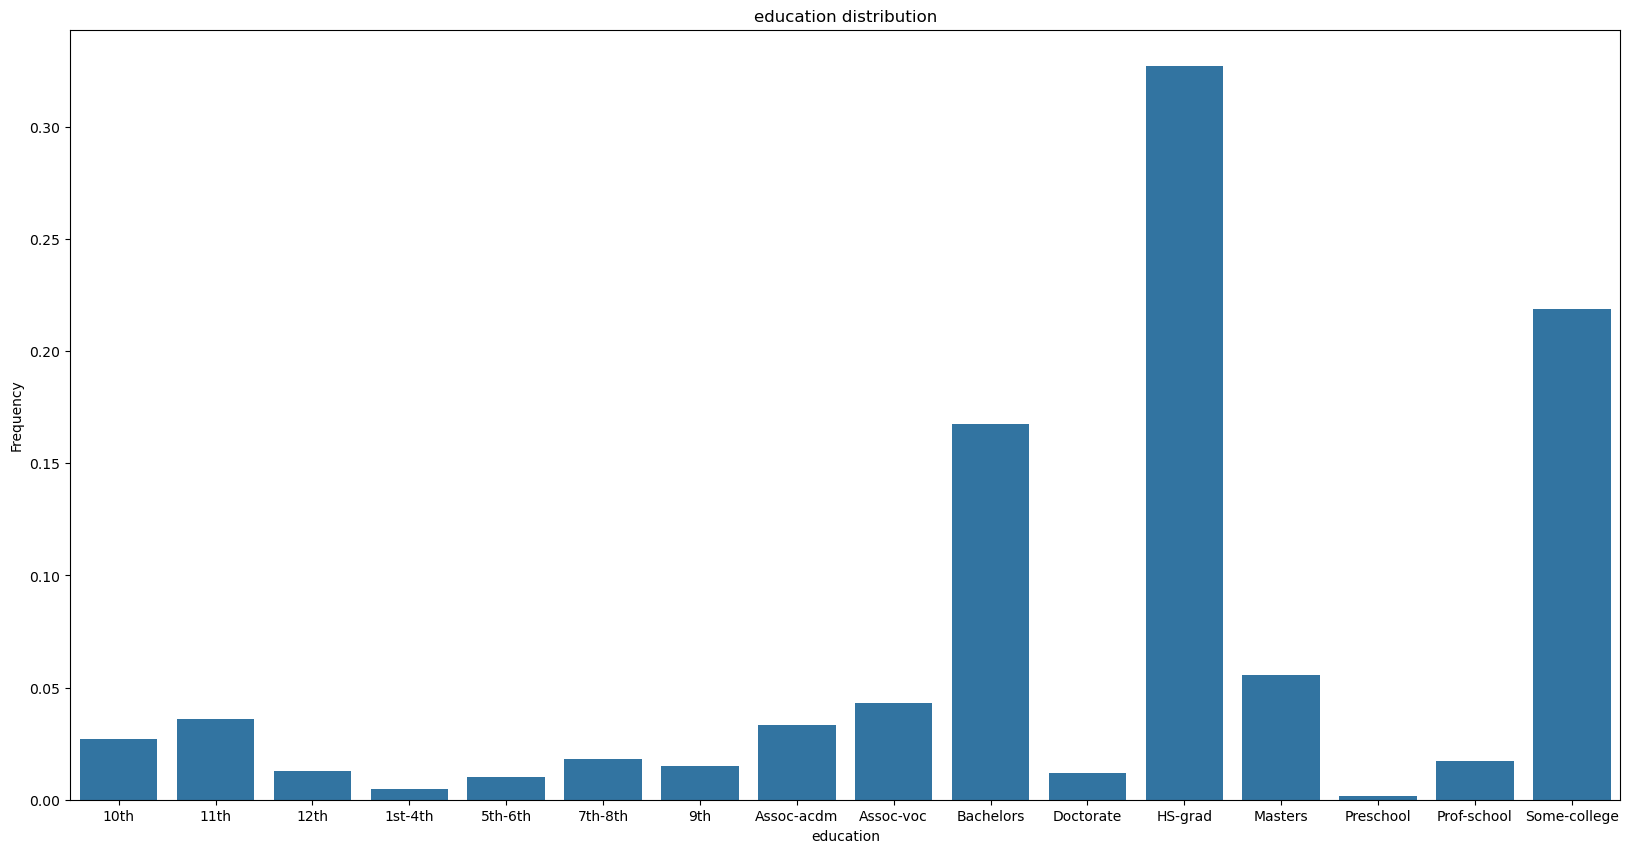

In [231]:
plot_hist(adult_features, "education")

### Computing the correlation

In [168]:
occupation_education = compute_correlation(adult_features, "occupation", "education", my_kernel_one_hot)

In [169]:
print(occupation_education.value)

0.6178333465853341


In [170]:
confusion_matrix = pd.crosstab(adult_features["occupation"], adult_features["education"])
cramer_occupation_education = cramers_v(confusion_matrix.values)

In [171]:
print(cramer_occupation_education)

0.19586519511682104


### Let's have a look at the alpha coefficients

In [172]:
print_coefficients_alphabetical(sorted_occup, occupation_education.alpha)

Adm-clerical      : 0.014201034969252836
Armed-Forces      : -0.04468201867529643
Craft-repair      : 0.06410268456008025
Exec-managerial   : -0.09423420983140636
Farming-fishing   : 0.06719682330421545
Handlers-cleaners : 0.08529645307520903
Machine-op-inspct : 0.08716737086354813
Other-service     : 0.07074675059621326
Priv-house-serv   : 0.10222262711508032
Prof-specialty    : -0.22207578851197518
Protective-serv   : 0.009281364212842105
Sales             : -0.013974999521733778
Tech-support      : -0.043404878104508535
Transport-moving  : 0.08141299665863838


In [229]:
print_coefficients(sorted_occup, occupation_education.alpha)

Prof-specialty    : -0.22207578851197518
Priv-house-serv   : 0.10222262711508032
Exec-managerial   : -0.09423420983140636
Machine-op-inspct : 0.08716737086354813
Handlers-cleaners : 0.08529645307520903
Transport-moving  : 0.08141299665863838
Other-service     : 0.07074675059621326
Farming-fishing   : 0.06719682330421545
Craft-repair      : 0.06410268456008025
Armed-Forces      : -0.04468201867529643
Tech-support      : -0.043404878104508535
Adm-clerical      : 0.014201034969252836
Sales             : -0.013974999521733778
Protective-serv   : 0.009281364212842105


#### Top three positive coefficients

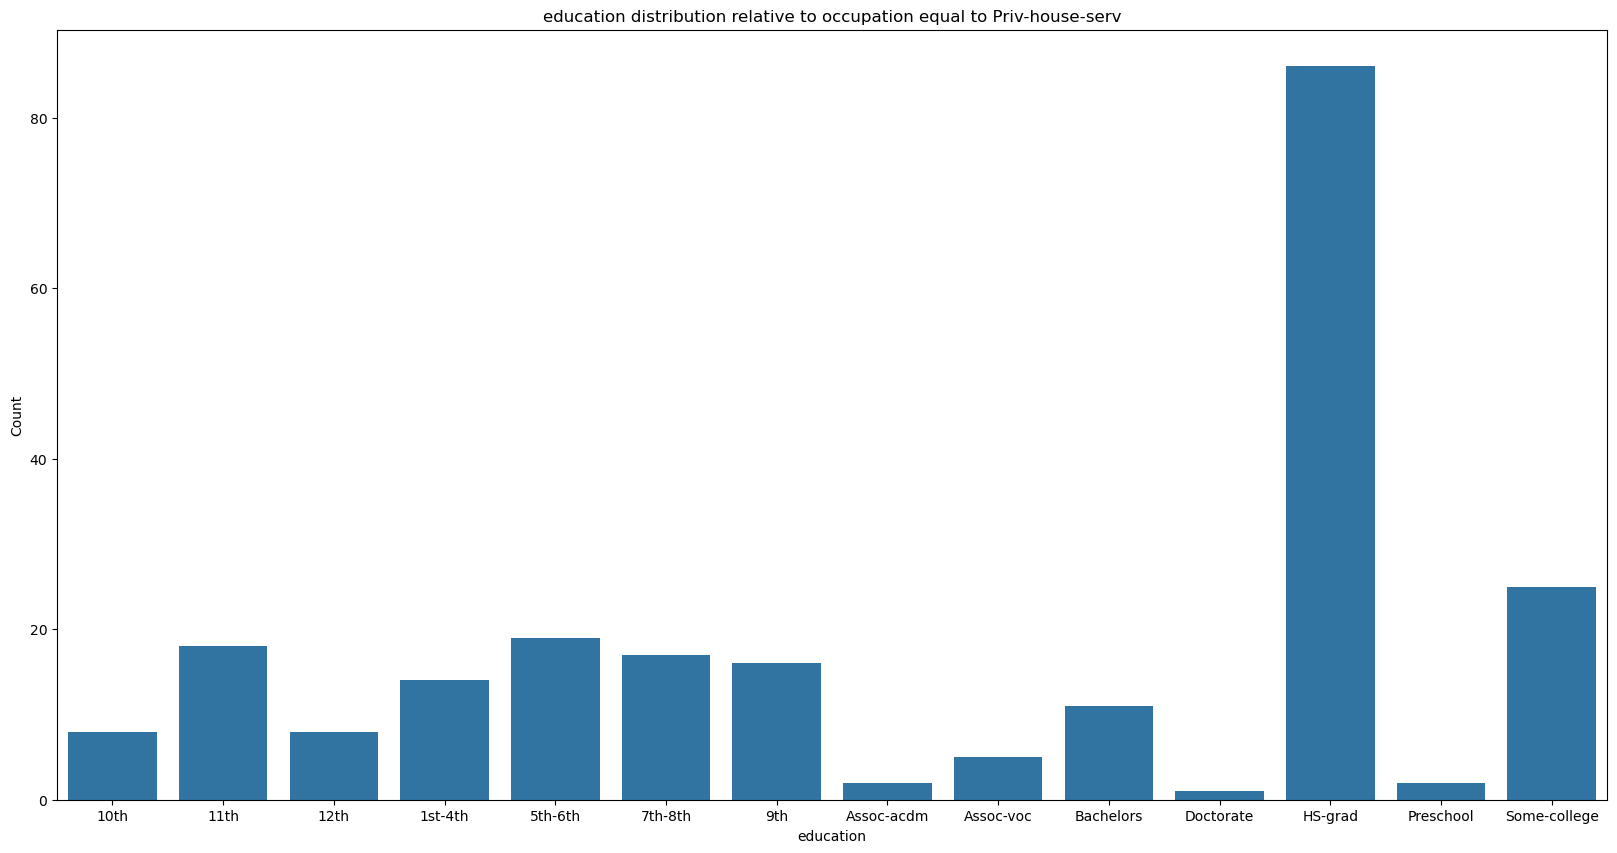

In [235]:
plot_hist(adult_features, "education", "occupation", "Priv-house-serv")

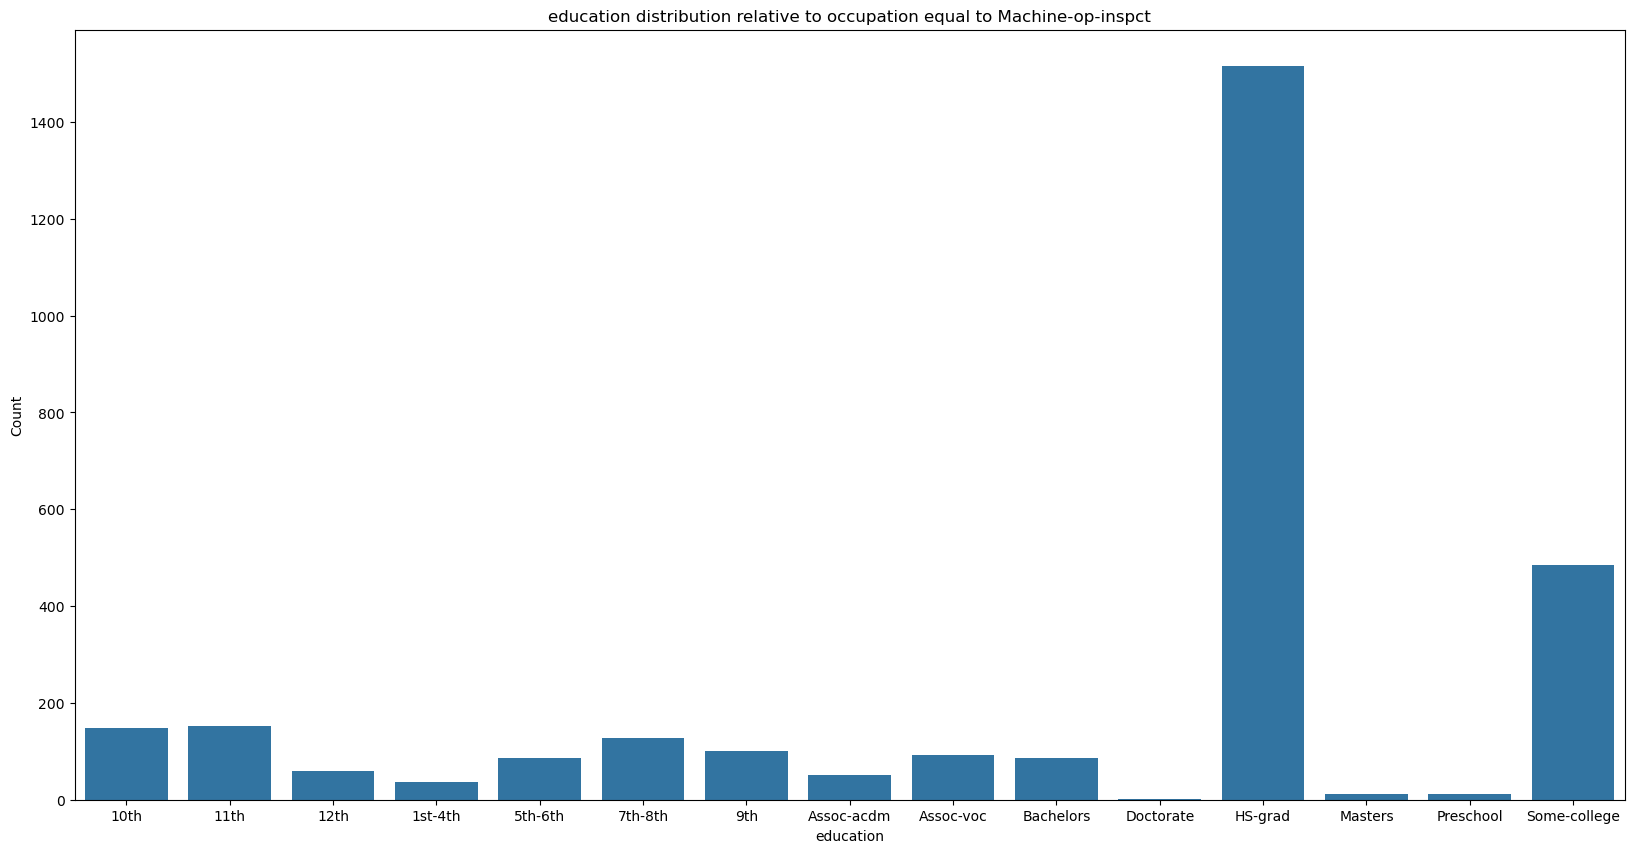

In [236]:
plot_hist(adult_features, "education", "occupation", "Machine-op-inspct")

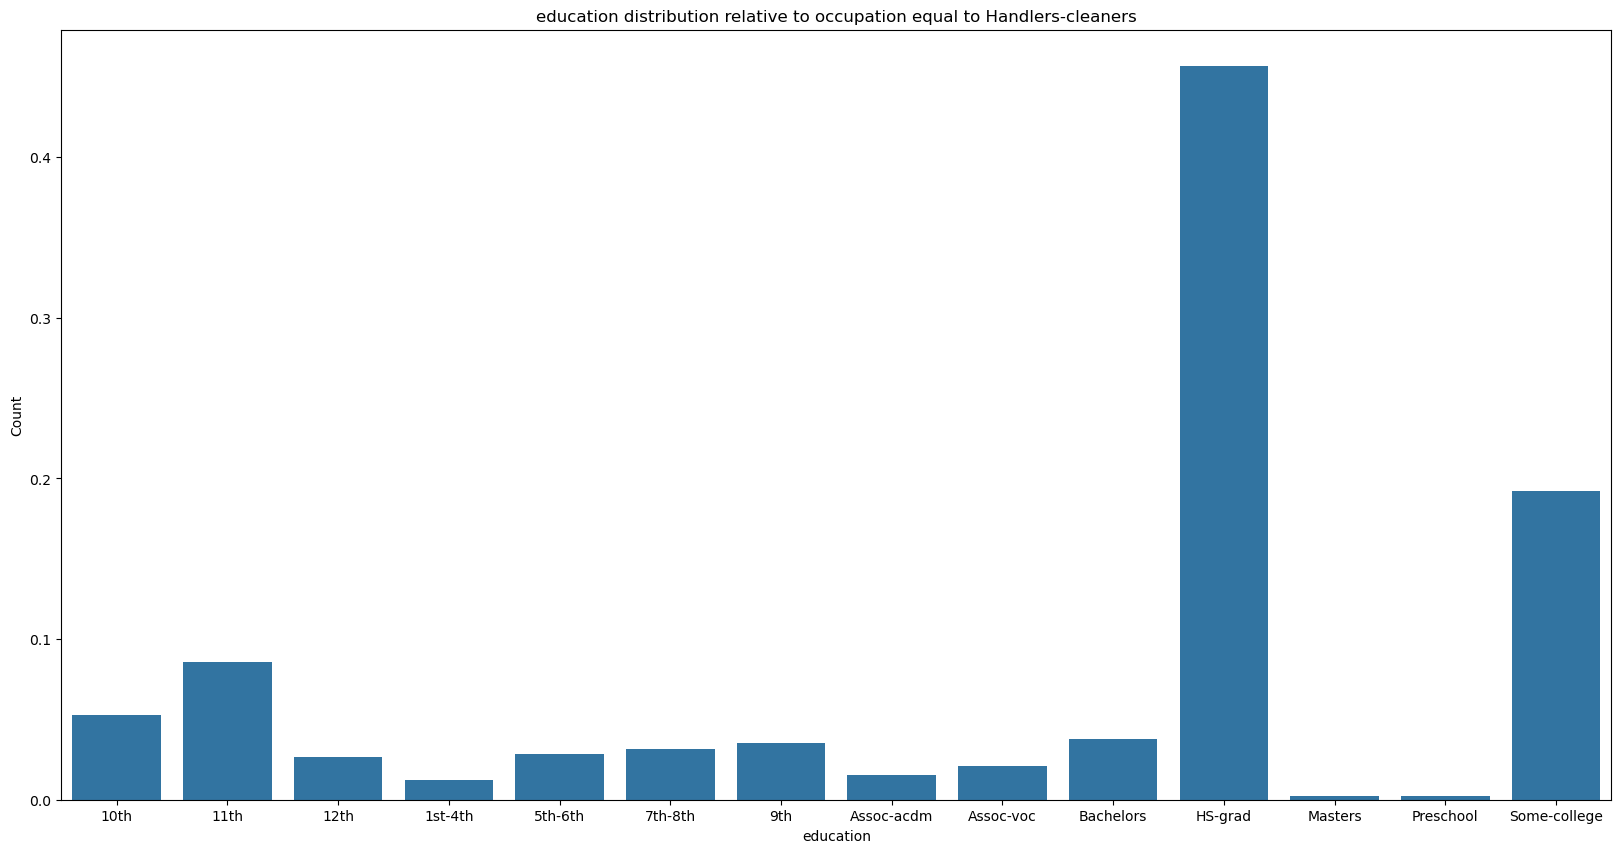

In [176]:
plot_hist(adult_features, "education", "occupation", "Handlers-cleaners")

As we could have expected, the top three positive coefficients are relative to strongly correlated values. In particular, all three occupations are strongly correlated with the "HS-grad" education level.

#### Bottom three positive coefficients

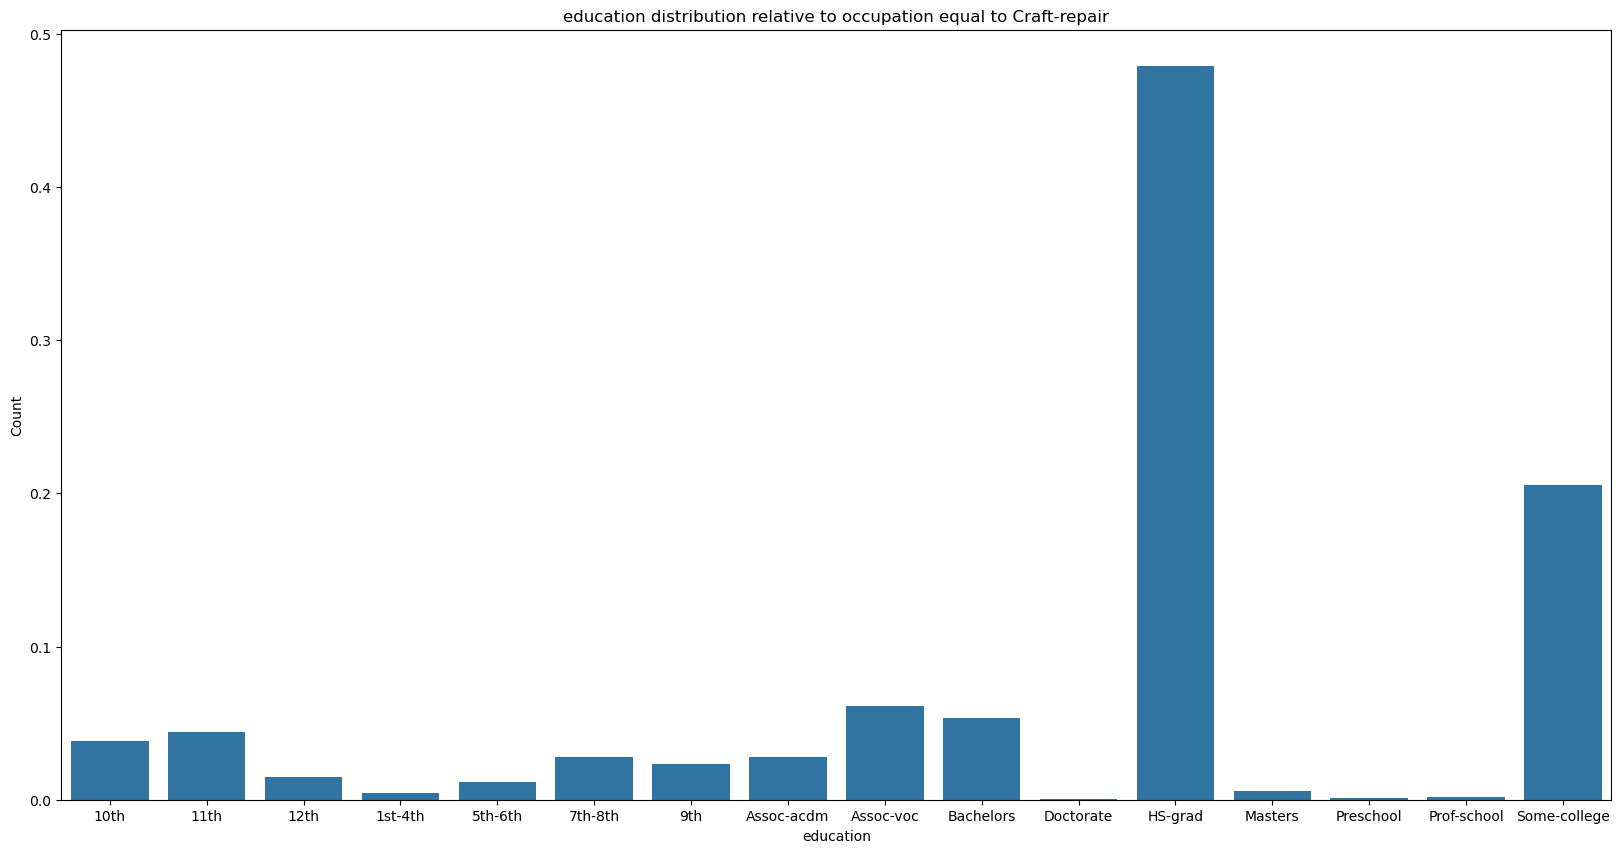

In [177]:
plot_hist(adult_features, "education", "occupation", "Craft-repair")

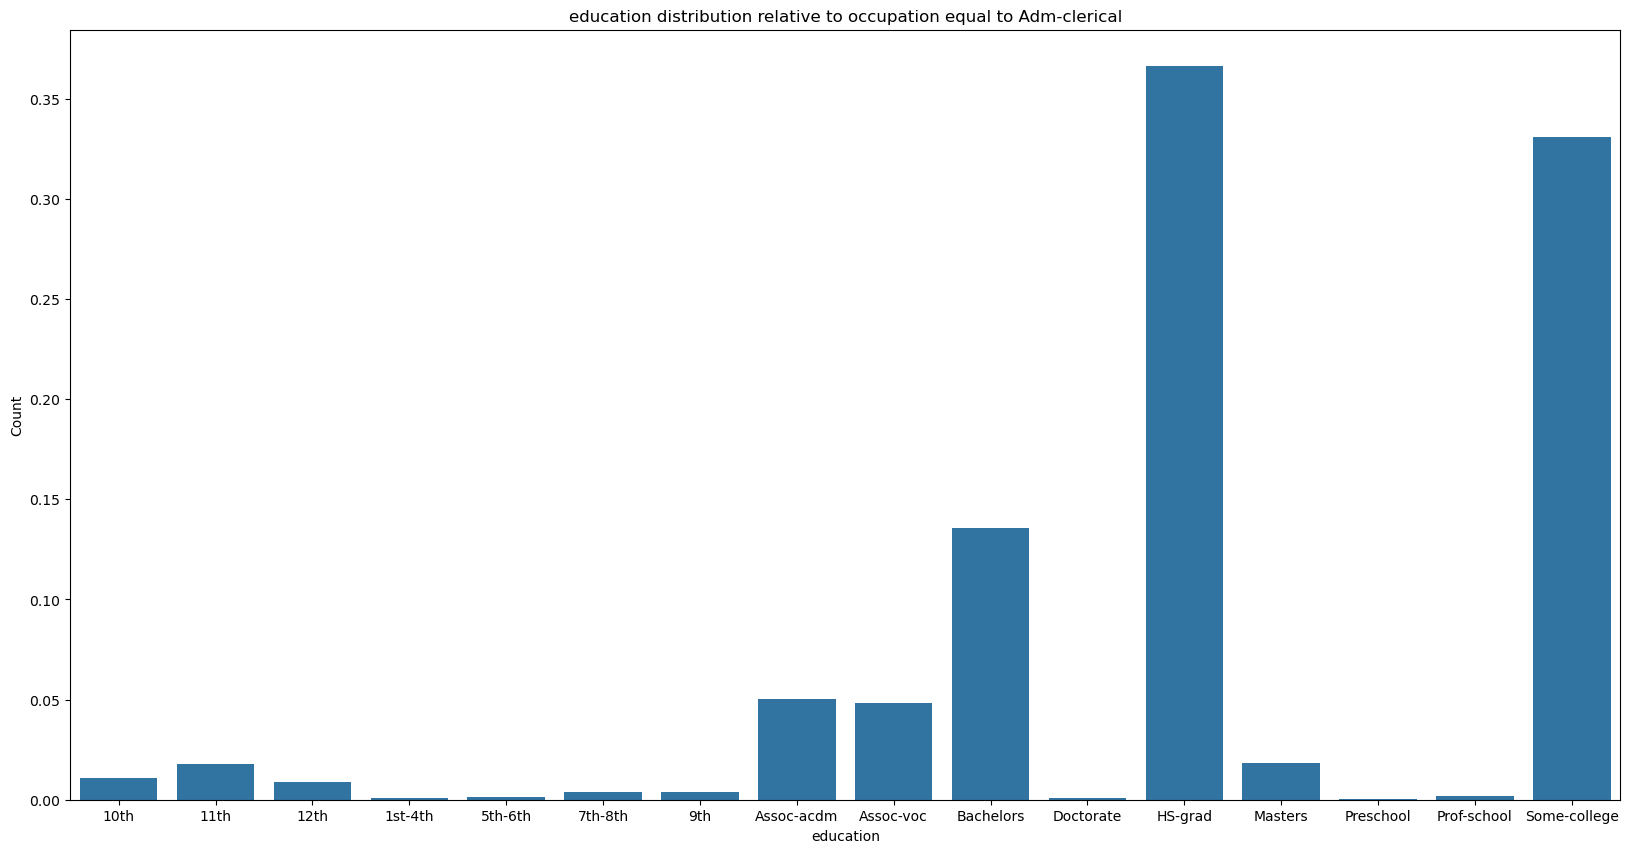

In [178]:
plot_hist(adult_features, "education", "occupation", "Adm-clerical")

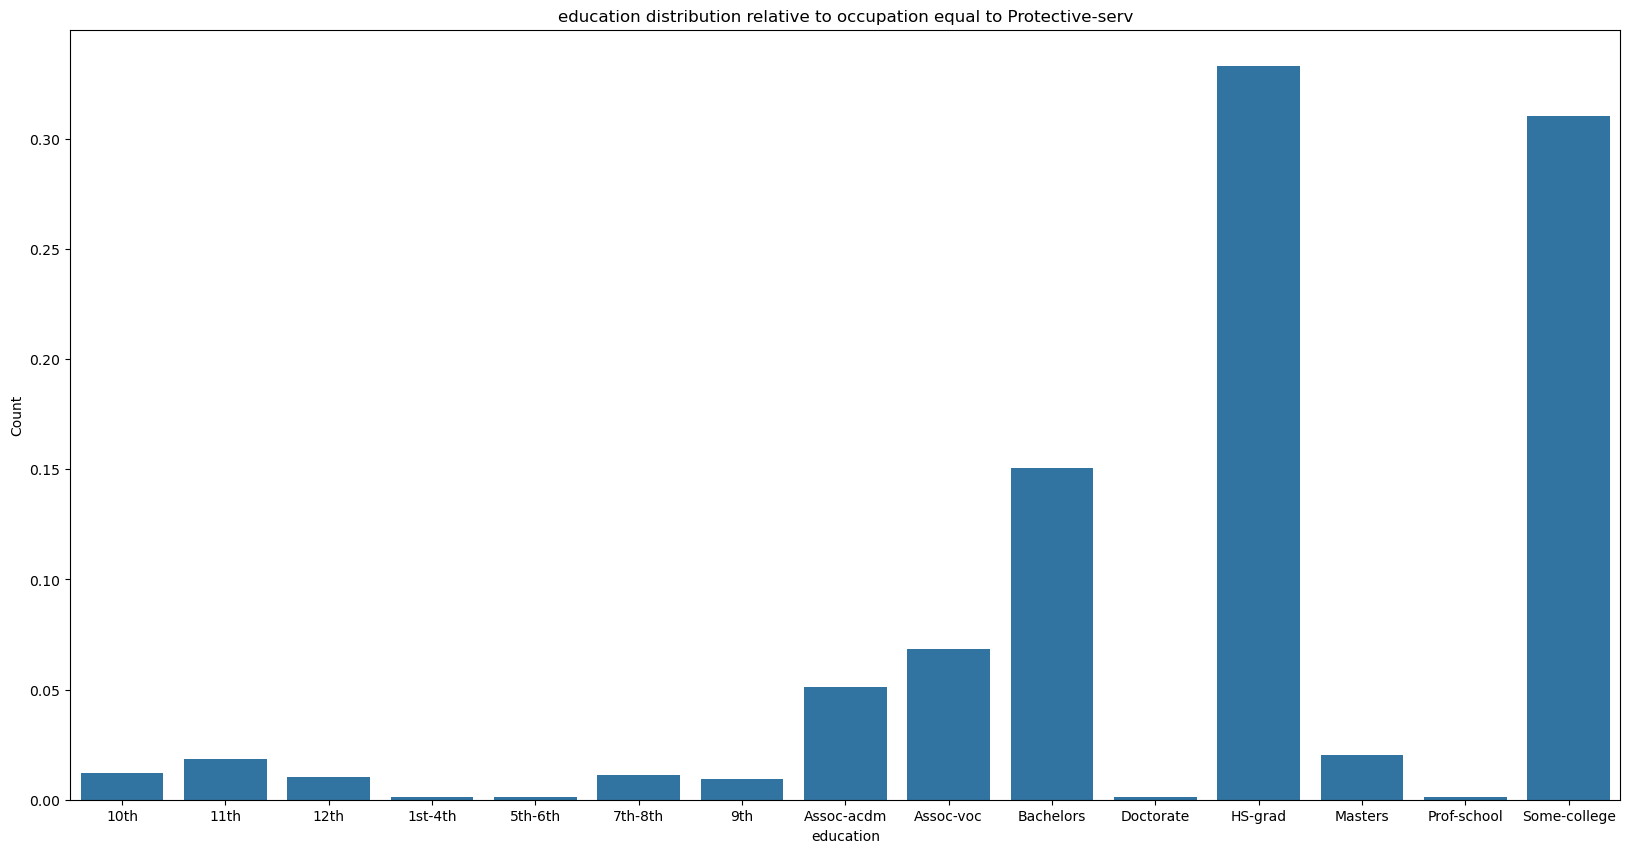

In [179]:
plot_hist(adult_features, "education", "occupation", "Protective-serv")

1. We can observe that the positive coefficients are linked with values whose corresponding "education" distribution is very similar to the complete "education" distribution, with a predominance of "HS-grad" and "Some-college"

Top three negative coefficients

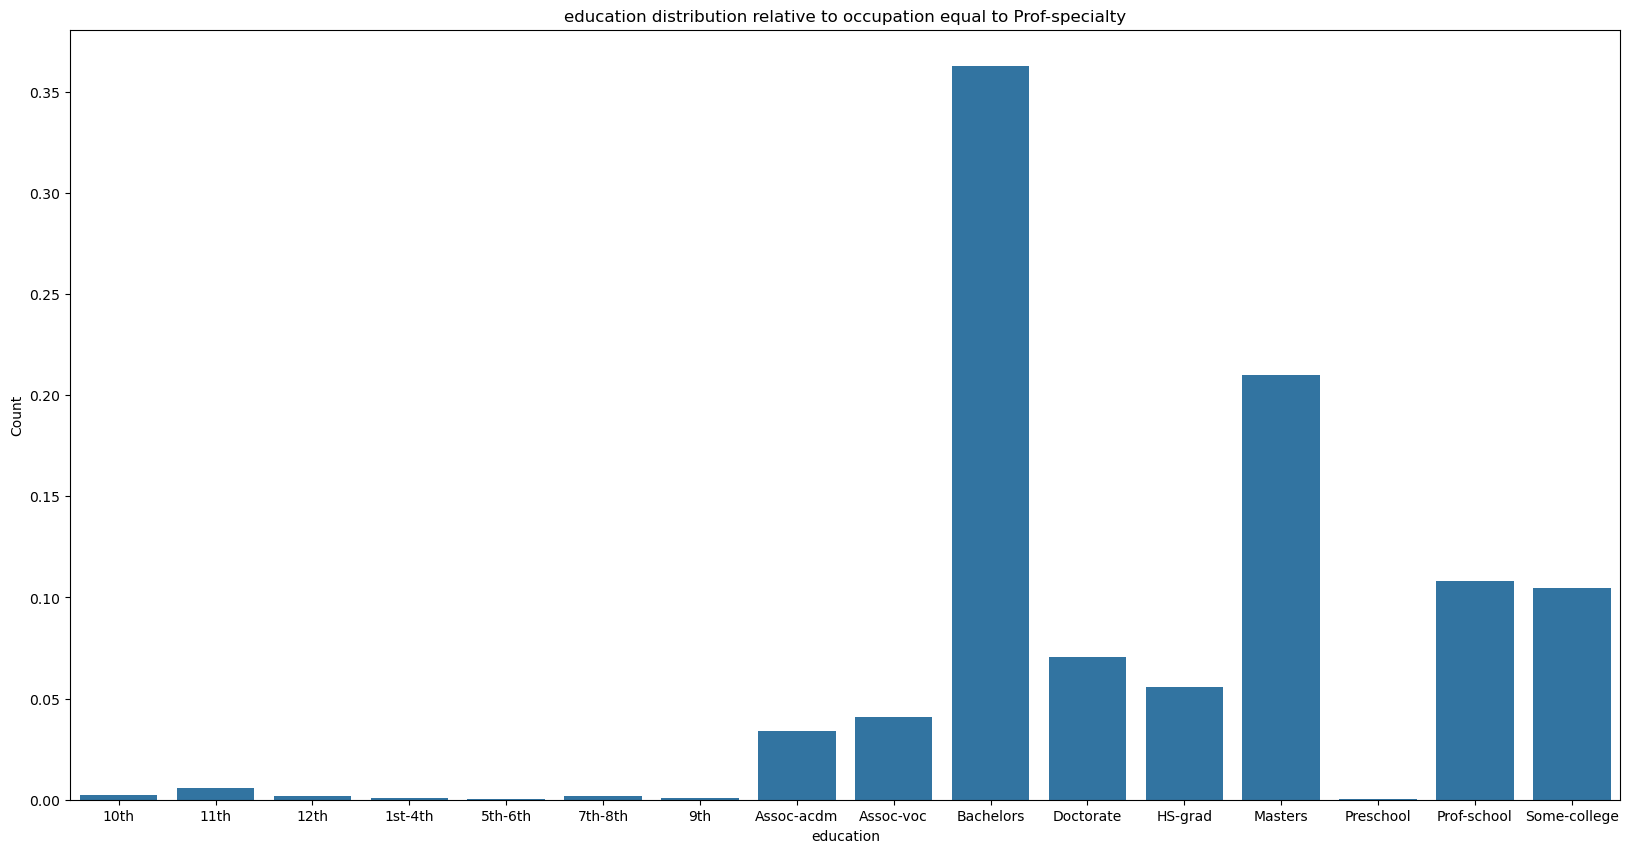

In [180]:
plot_hist(adult_features, "education", "occupation", "Prof-specialty")

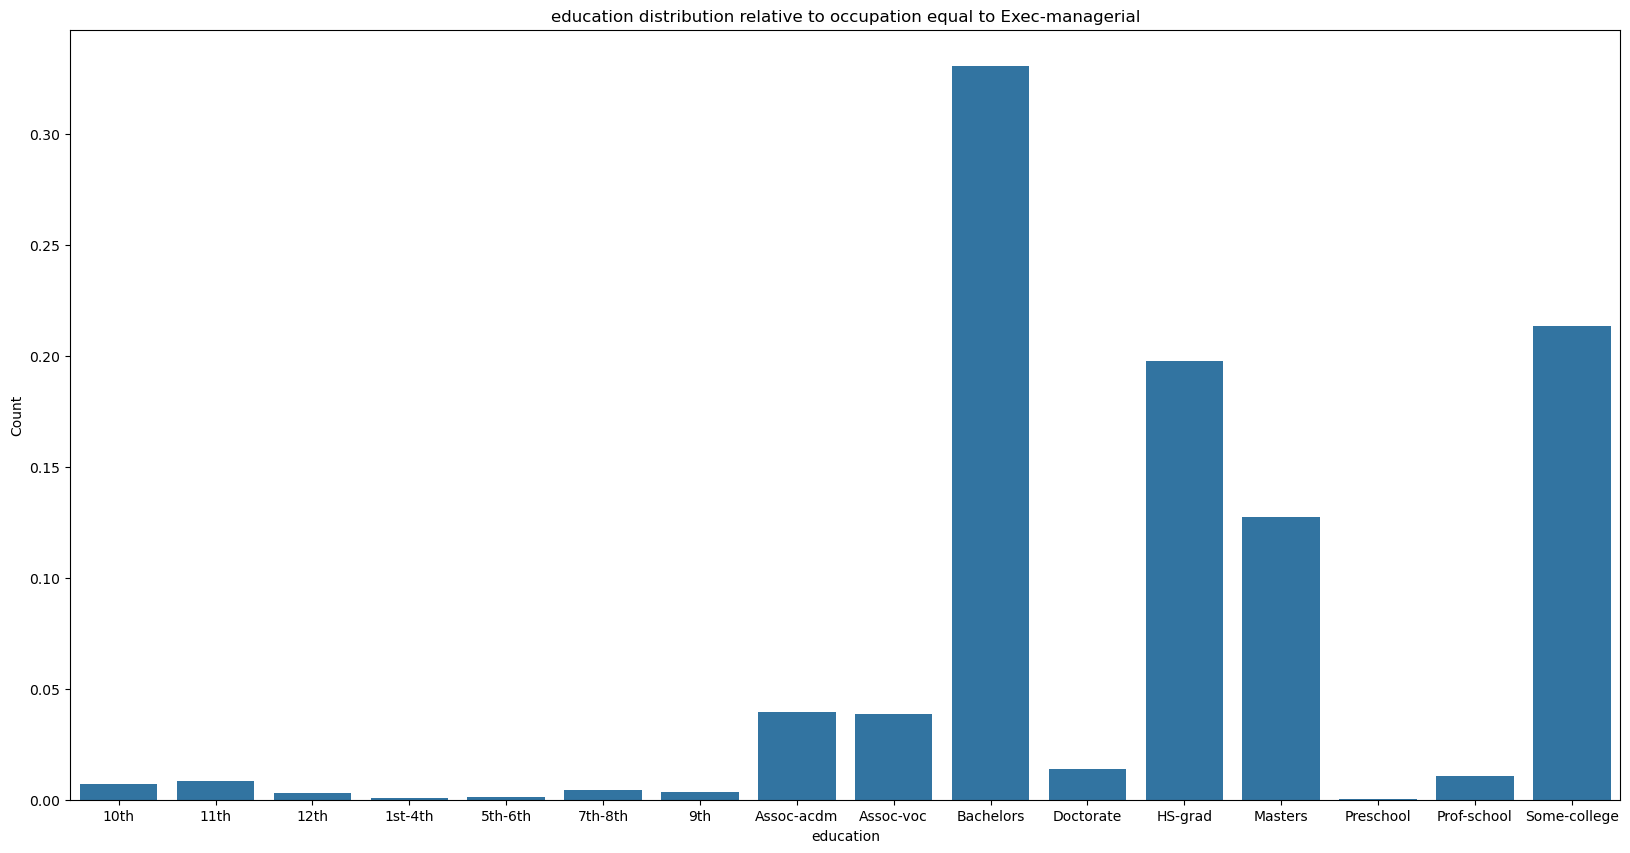

In [181]:
plot_hist(adult_features, "education", "occupation", "Exec-managerial")

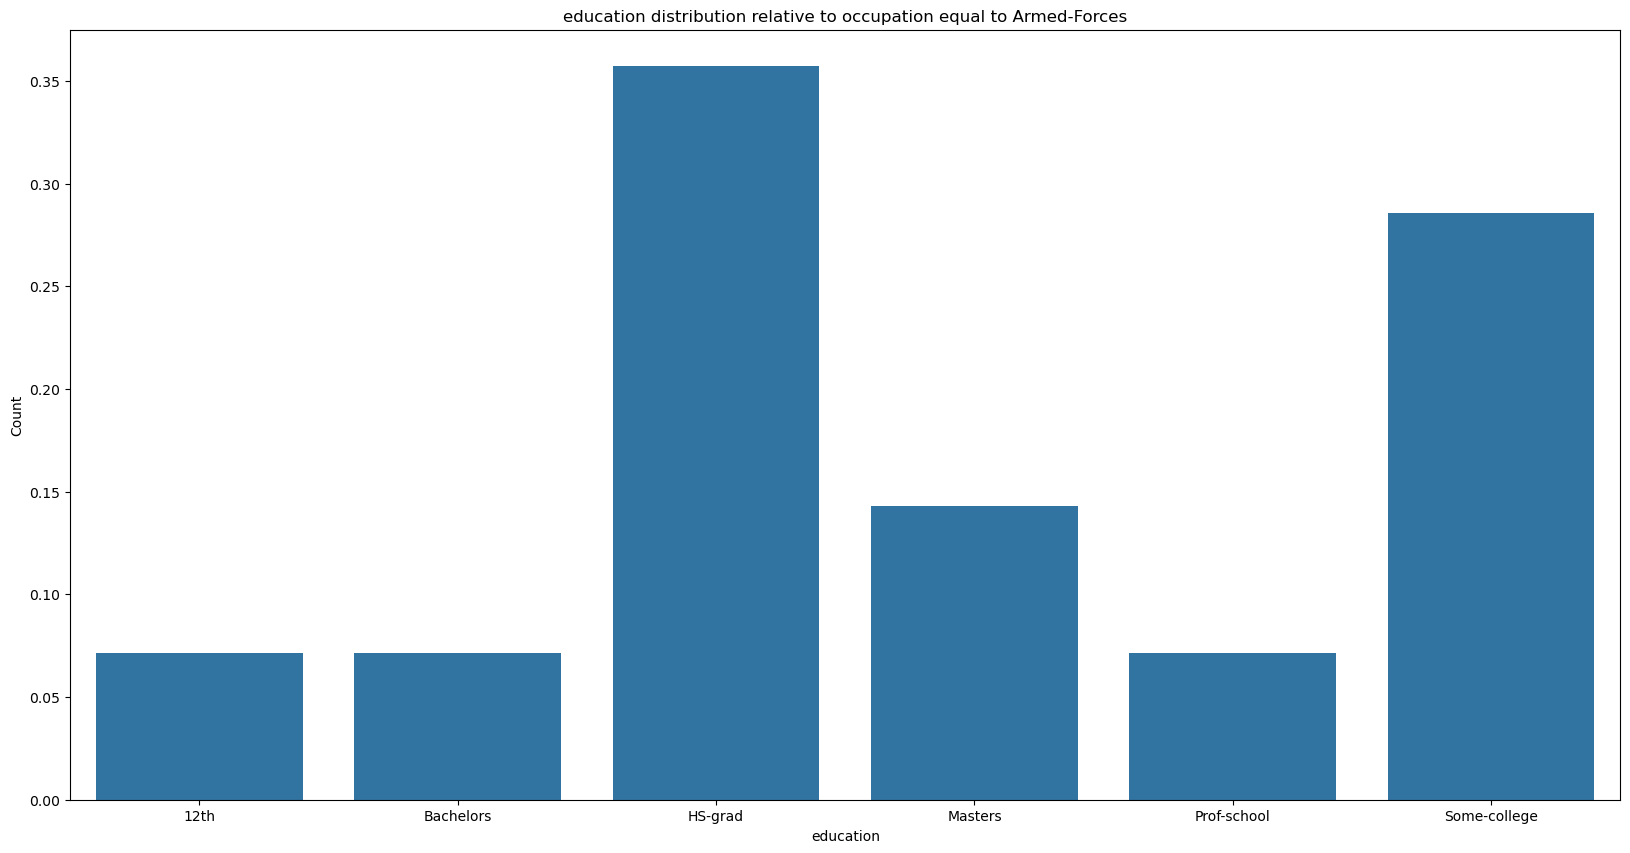

In [182]:
plot_hist(adult_features, "education", "occupation", "Armed-Forces")

The first two distributions are really different from the original one for education. This is true also for the last one, even if this one is a lot smaller than the other two (maybe this is the reason why the absolute value of its coefficient in sensibly smaller)

Bottom two negative coefficients

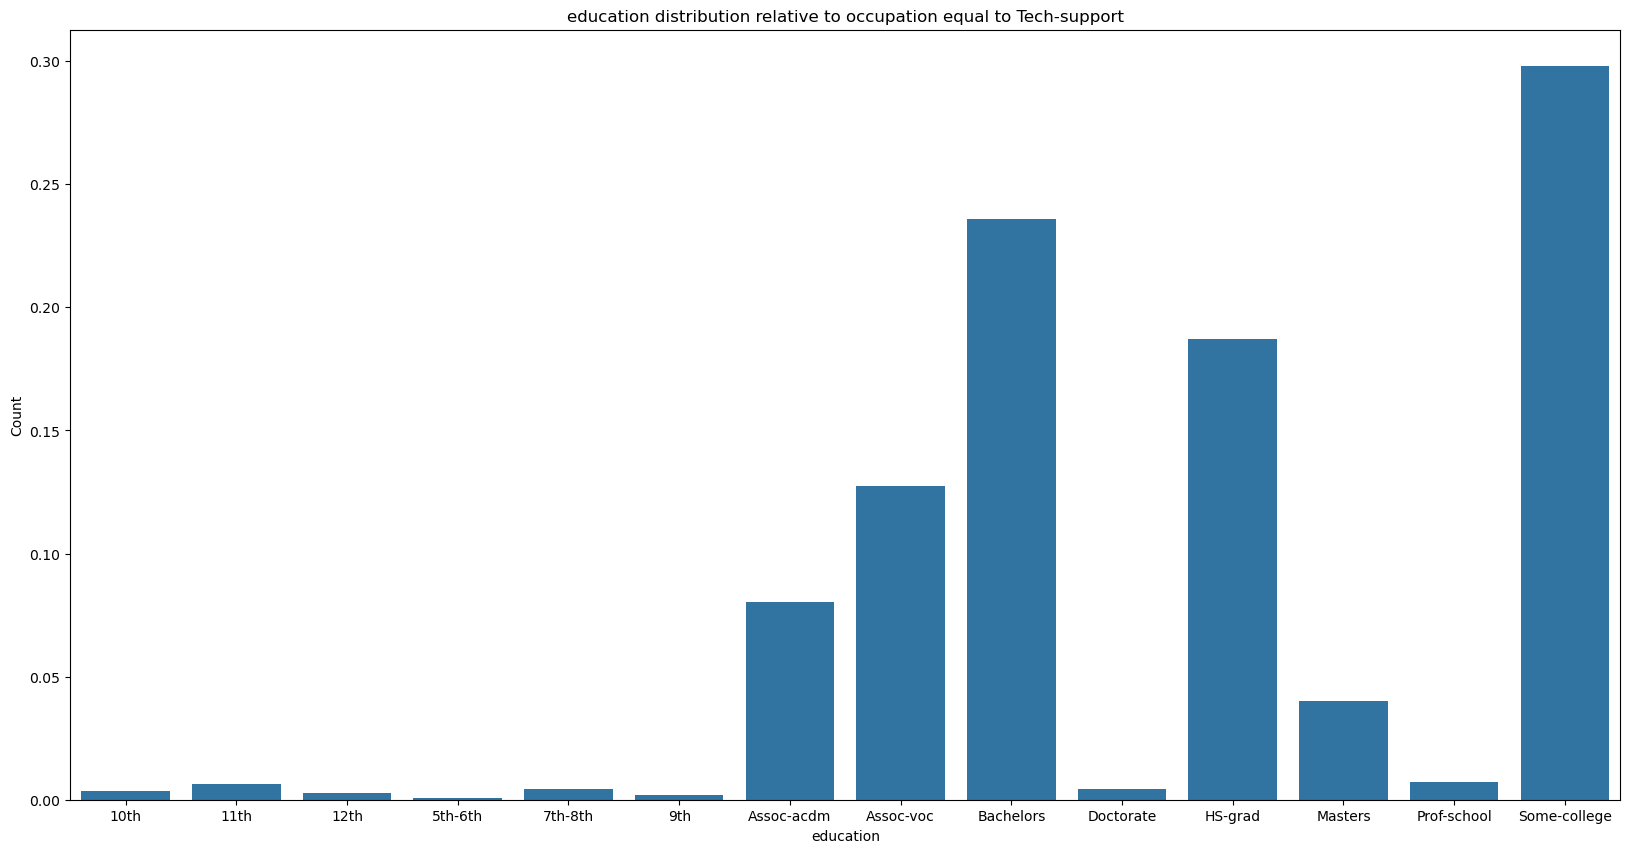

In [183]:
plot_hist(adult_features, "education", "occupation", "Tech-support")

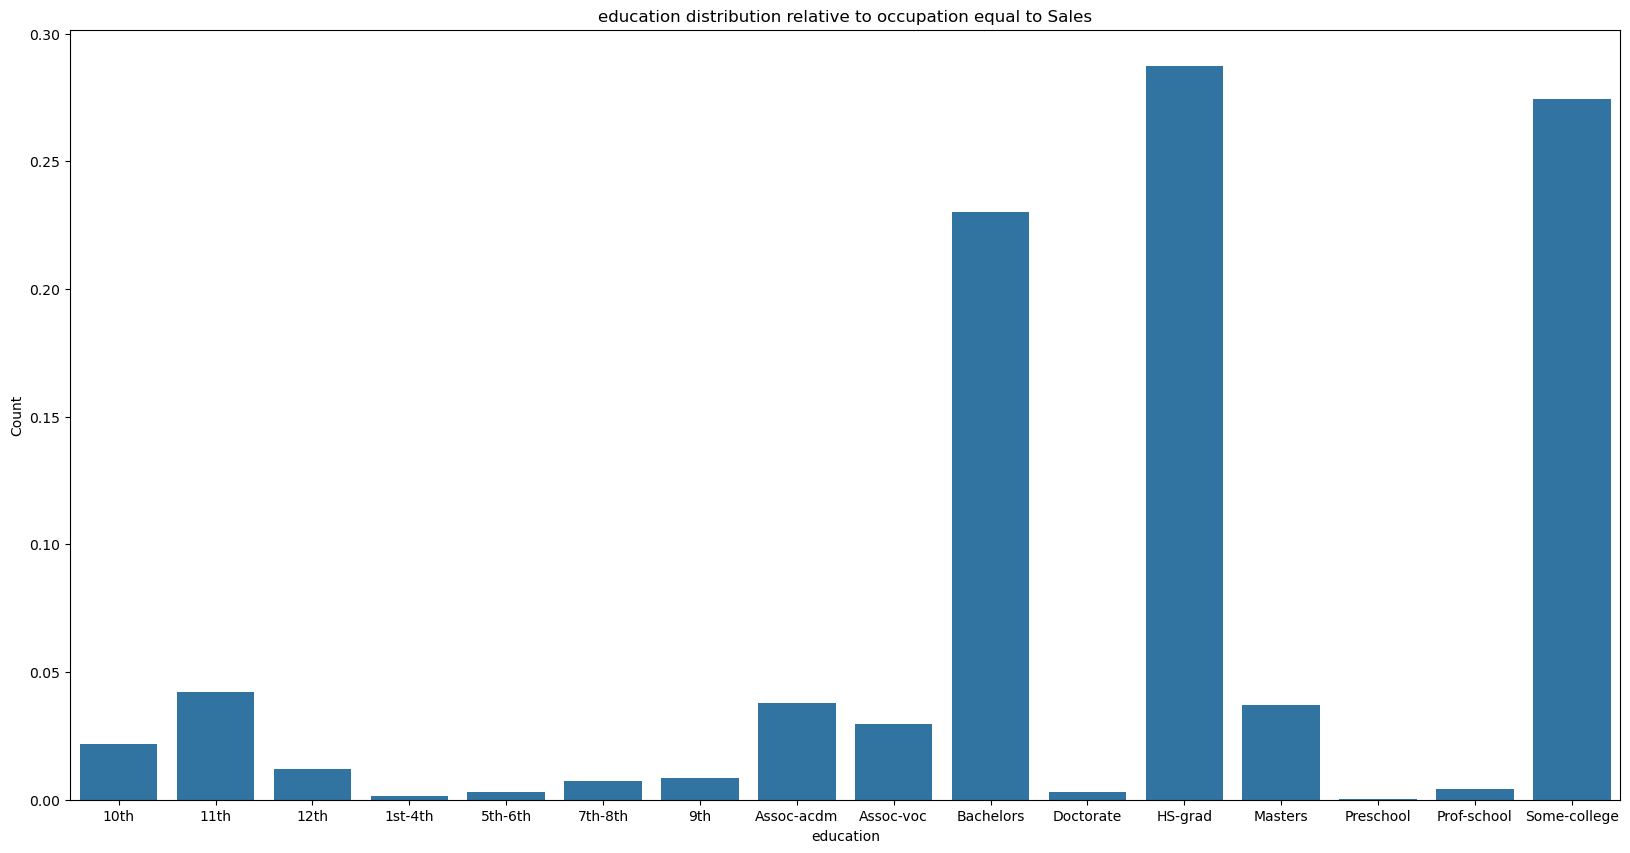

In [184]:
plot_hist(adult_features, "education", "occupation", "Sales")

### Let's have a look at the beta coefficients

In [185]:
print_coefficients_alphabetical(sorted_edu, occupation_education.beta)

10th         : 0.055893666855710344
11th         : 0.0498217152698247
12th         : 0.05012182947864084
1st-4th      : 0.06428886861111005
5th-6th      : 0.06910685417332005
7th-8th      : 0.060025757037498725
9th          : 0.0608930153842529
Assoc-acdm   : -0.011796507013182527
Assoc-voc    : 0.00026870710081214577
Bachelors    : -0.058605801921143175
Doctorate    : -0.14725052253185414
HS-grad      : 0.0389363380700987
Masters      : -0.10595099930426066
Preschool    : 0.0644774147291426
Prof-school  : -0.15002533044433464
Some-college : 0.012536672074813777


In [186]:
print_coefficients(sorted_edu, occupation_education.beta)

5th-6th      : 0.06910685417332005
Preschool    : 0.0644774147291426
1st-4th      : 0.06428886861111005
9th          : 0.0608930153842529
7th-8th      : 0.060025757037498725
10th         : 0.055893666855710344
12th         : 0.05012182947864084
11th         : 0.0498217152698247
HS-grad      : 0.0389363380700987
Some-college : 0.012536672074813777
Assoc-voc    : 0.00026870710081214577
Assoc-acdm   : -0.011796507013182527
Bachelors    : -0.058605801921143175
Masters      : -0.10595099930426066
Doctorate    : -0.14725052253185414
Prof-school  : -0.15002533044433464


#### Top three positive coefficients

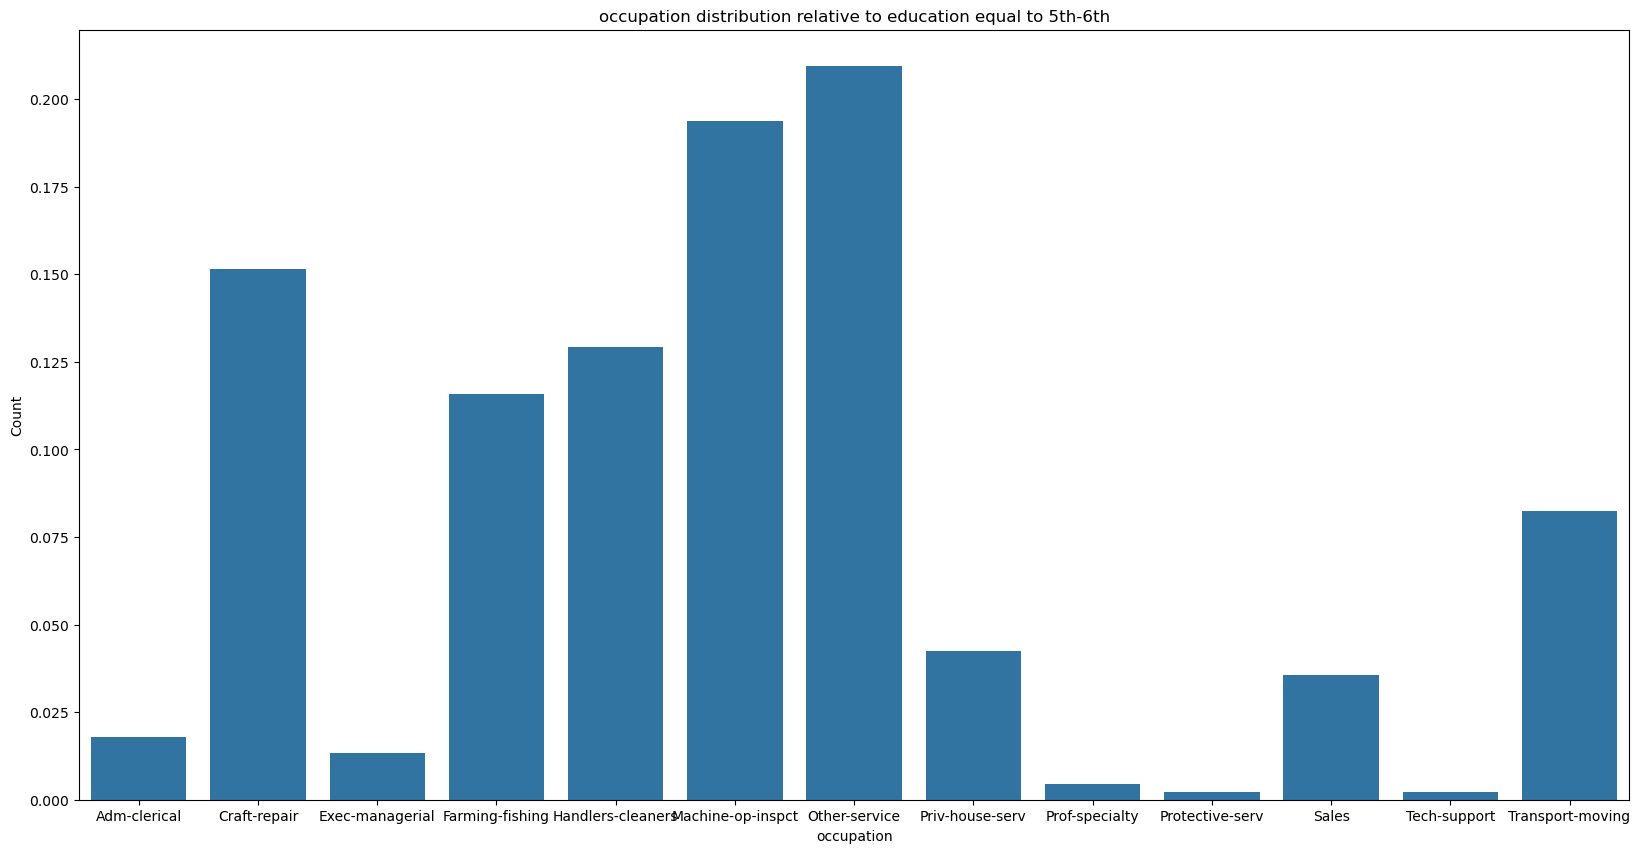

In [187]:
plot_hist(adult_features, "occupation", "education", "5th-6th")

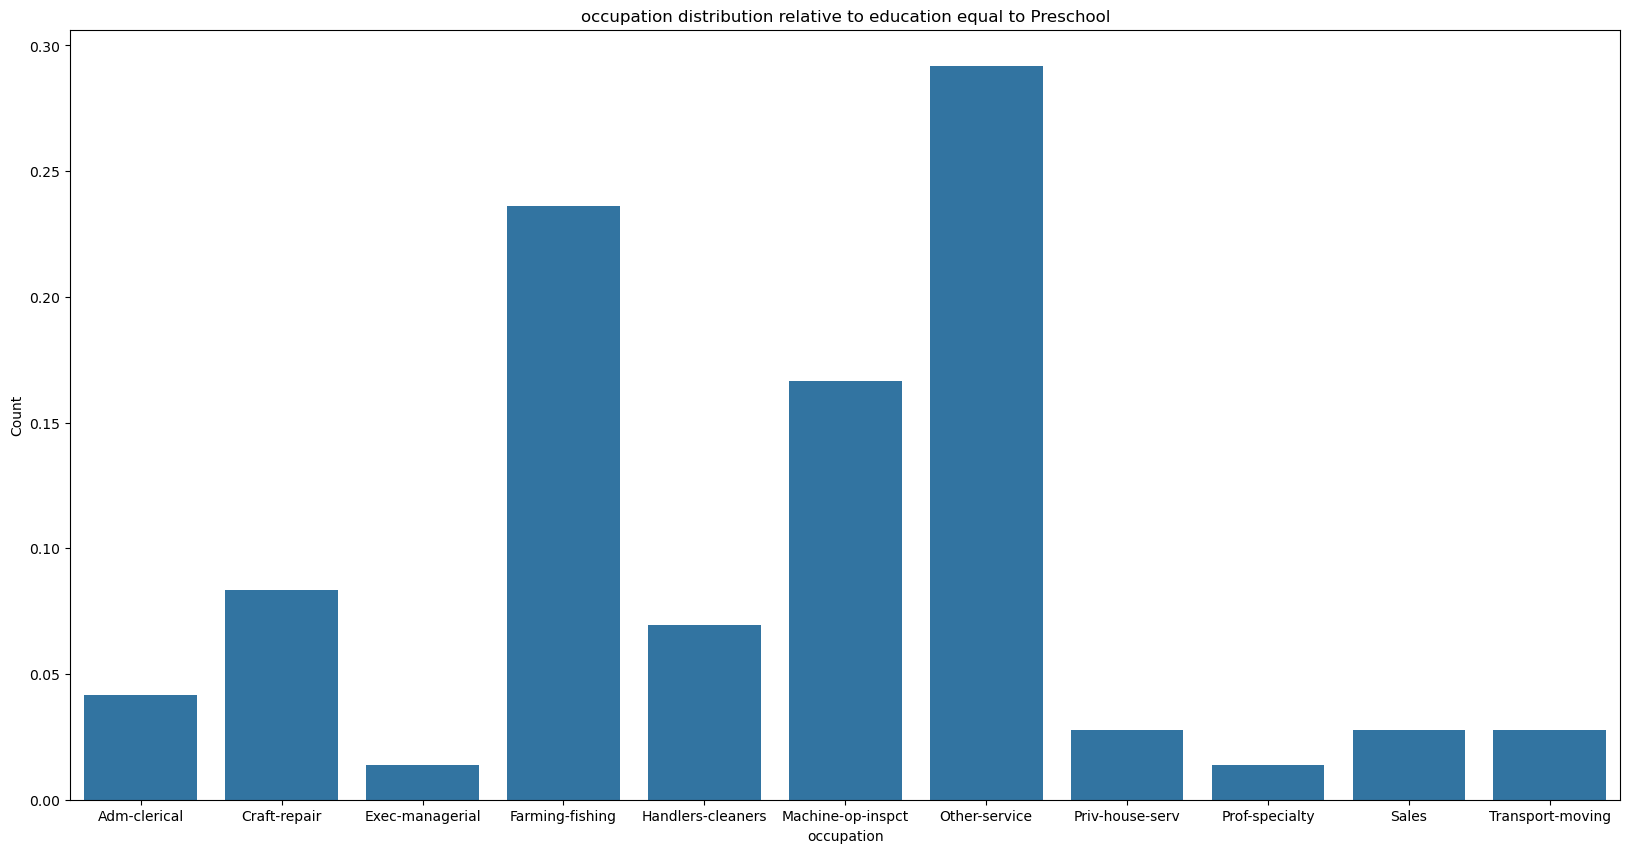

In [188]:
plot_hist(adult_features, "occupation", "education", "Preschool")

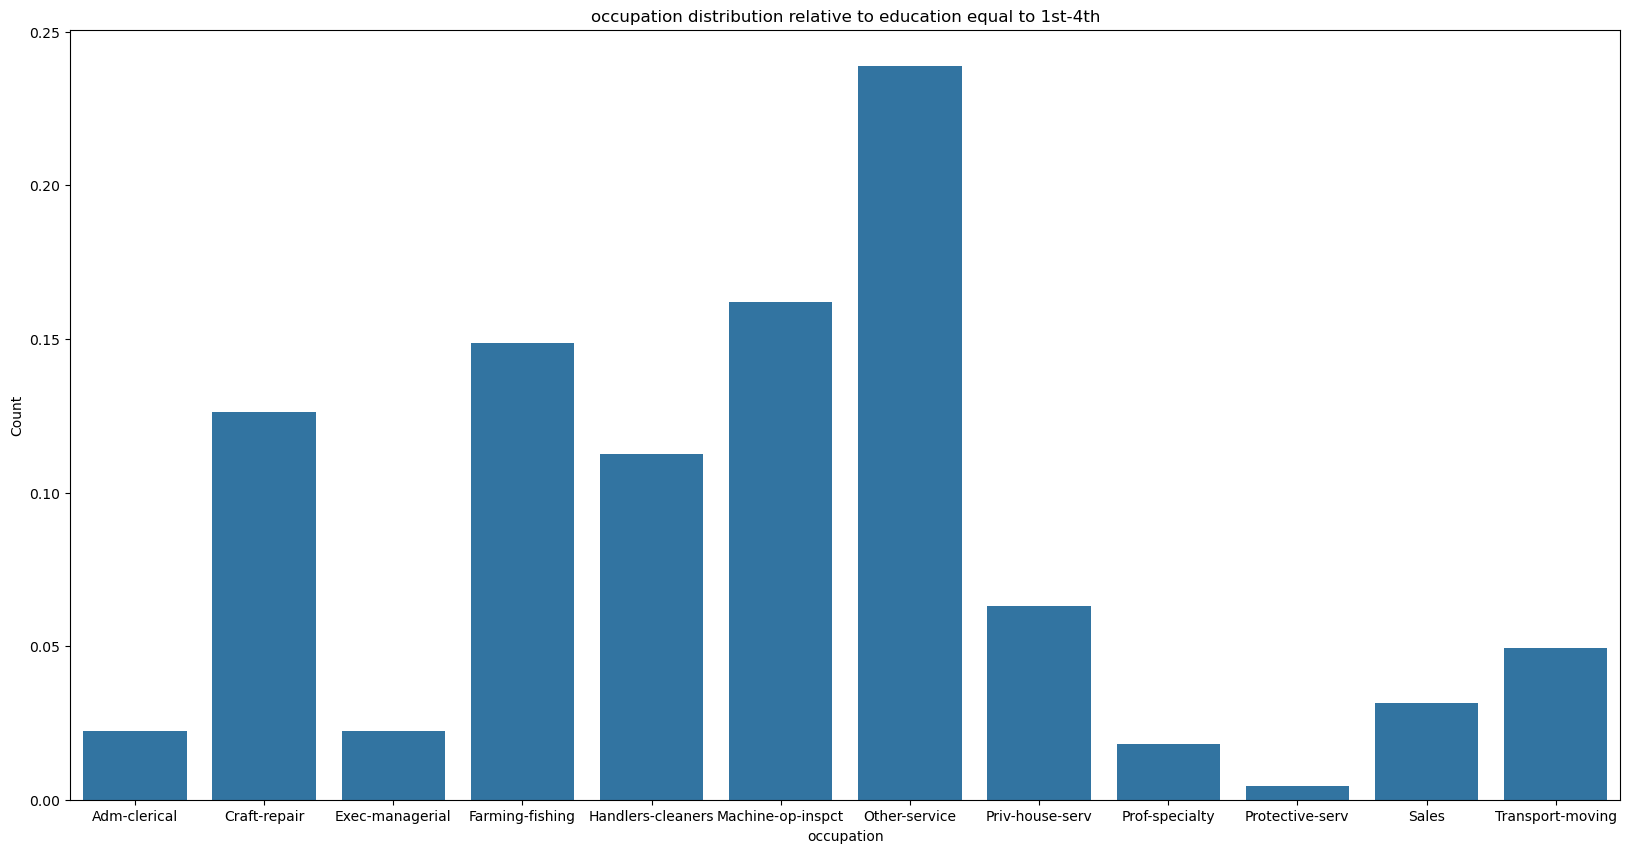

In [189]:
plot_hist(adult_features, "occupation", "education", "1st-4th")

#### Bottom three positive coefficients

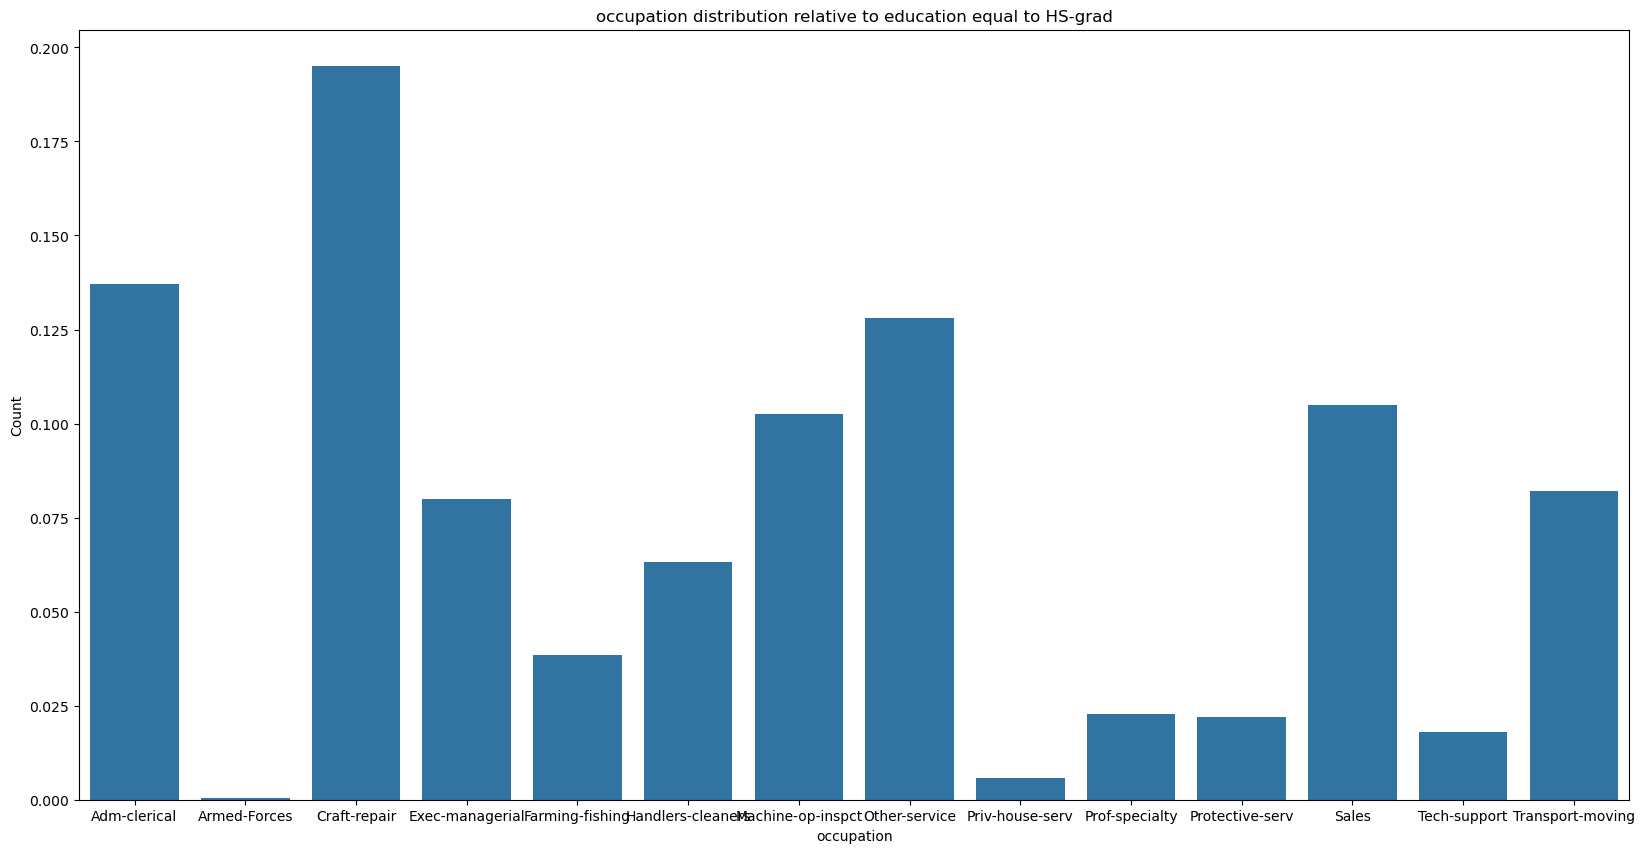

In [190]:
plot_hist(adult_features, "occupation", "education", "HS-grad")

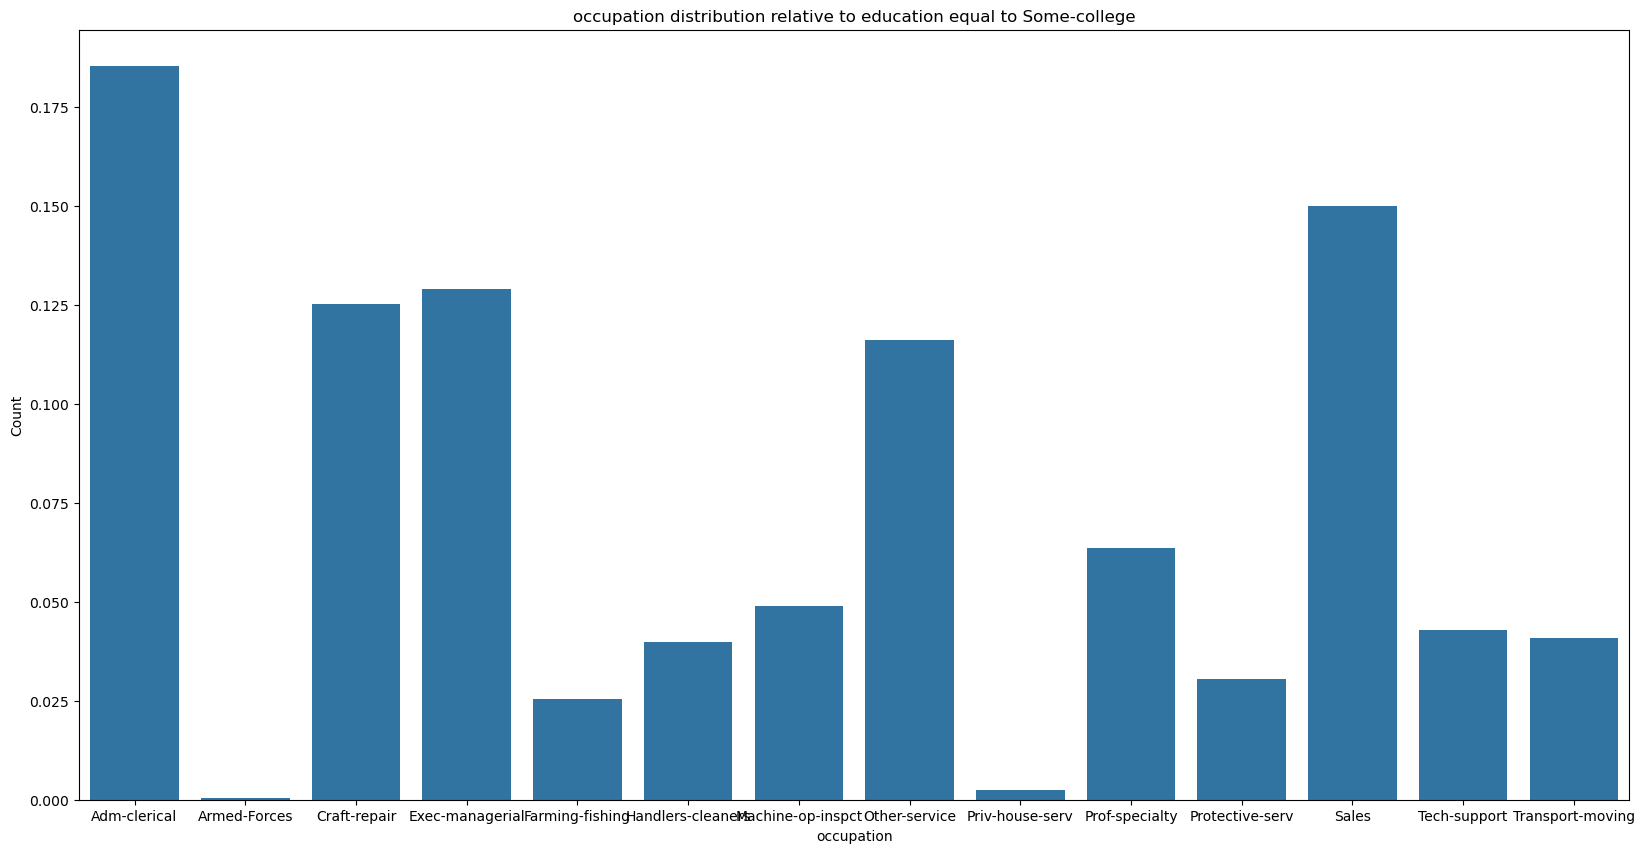

In [191]:
plot_hist(adult_features, "occupation", "education", "Some-college")

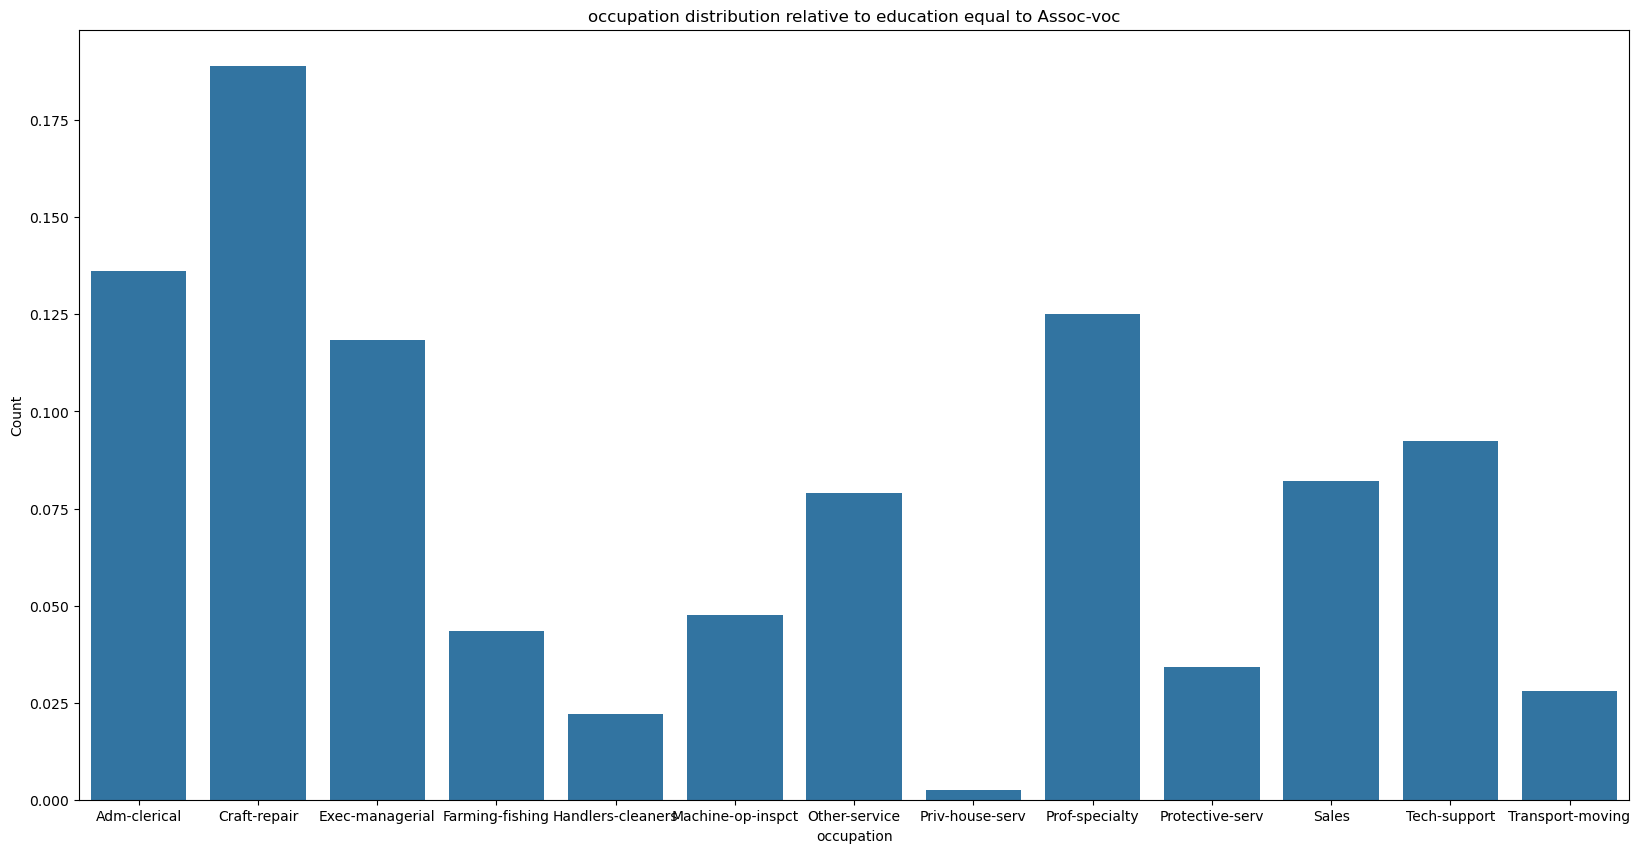

In [192]:
plot_hist(adult_features, "occupation", "education", "Assoc-voc")

Top three negative coefficients

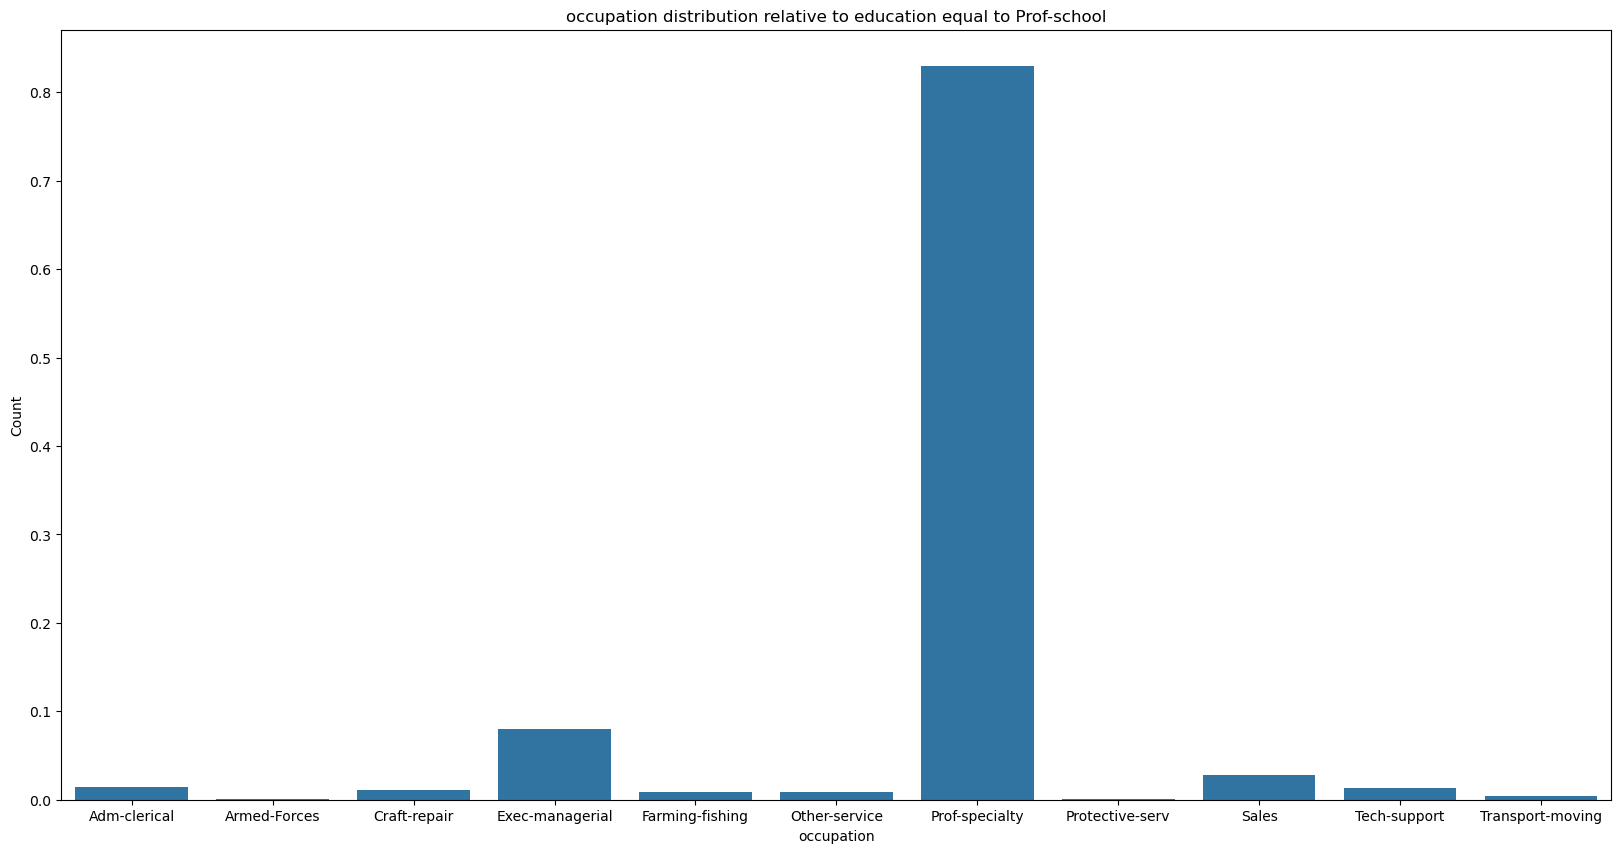

In [193]:
plot_hist(adult_features, "occupation", "education", "Prof-school")

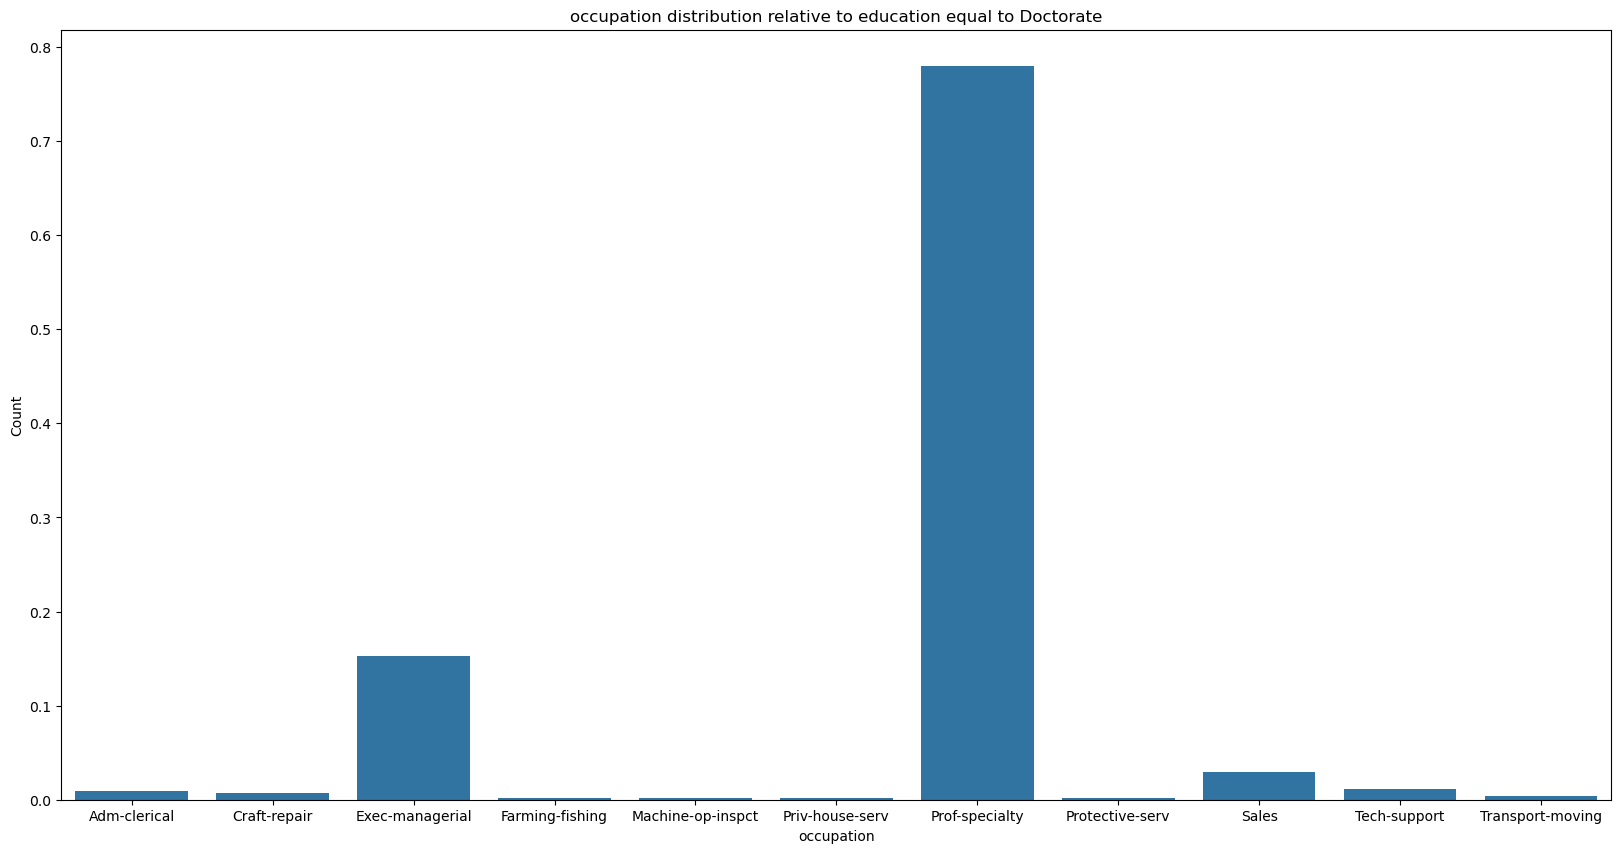

In [194]:
plot_hist(adult_features, "occupation", "education", "Doctorate")

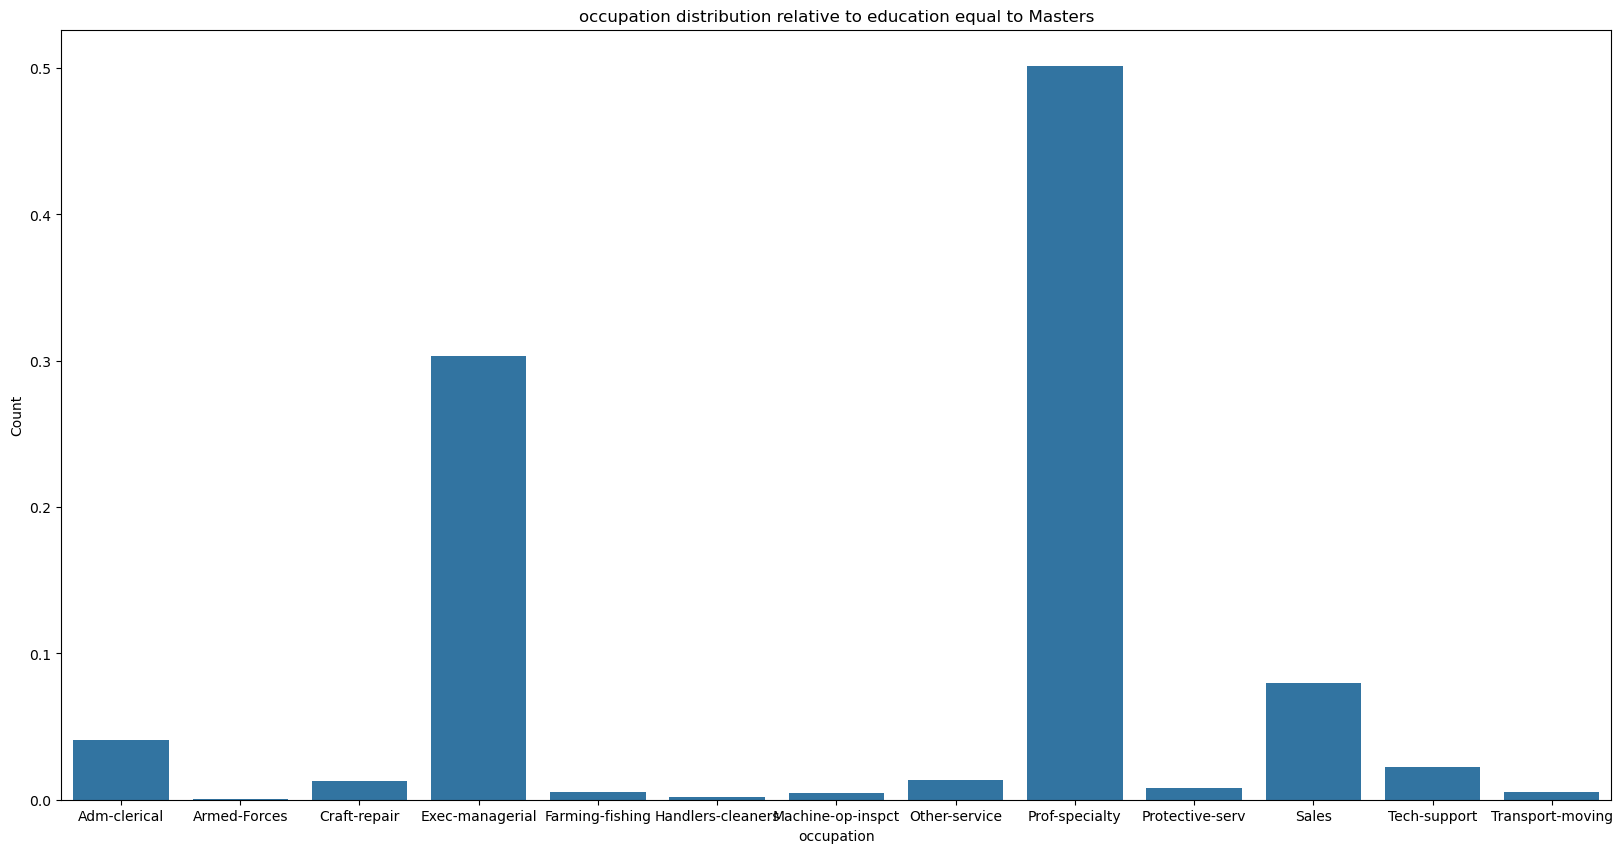

In [195]:
plot_hist(adult_features, "occupation", "education", "Masters")

These three coefficients boast the bigger absolute values by far, even considering positive coefficients, and this is so for a reason: the relative distributions of the "occupation" variable is sensibly skewed towards "Prof-specialty" and is really different from the total "occupation" distribution.

Bottom two negative coefficients

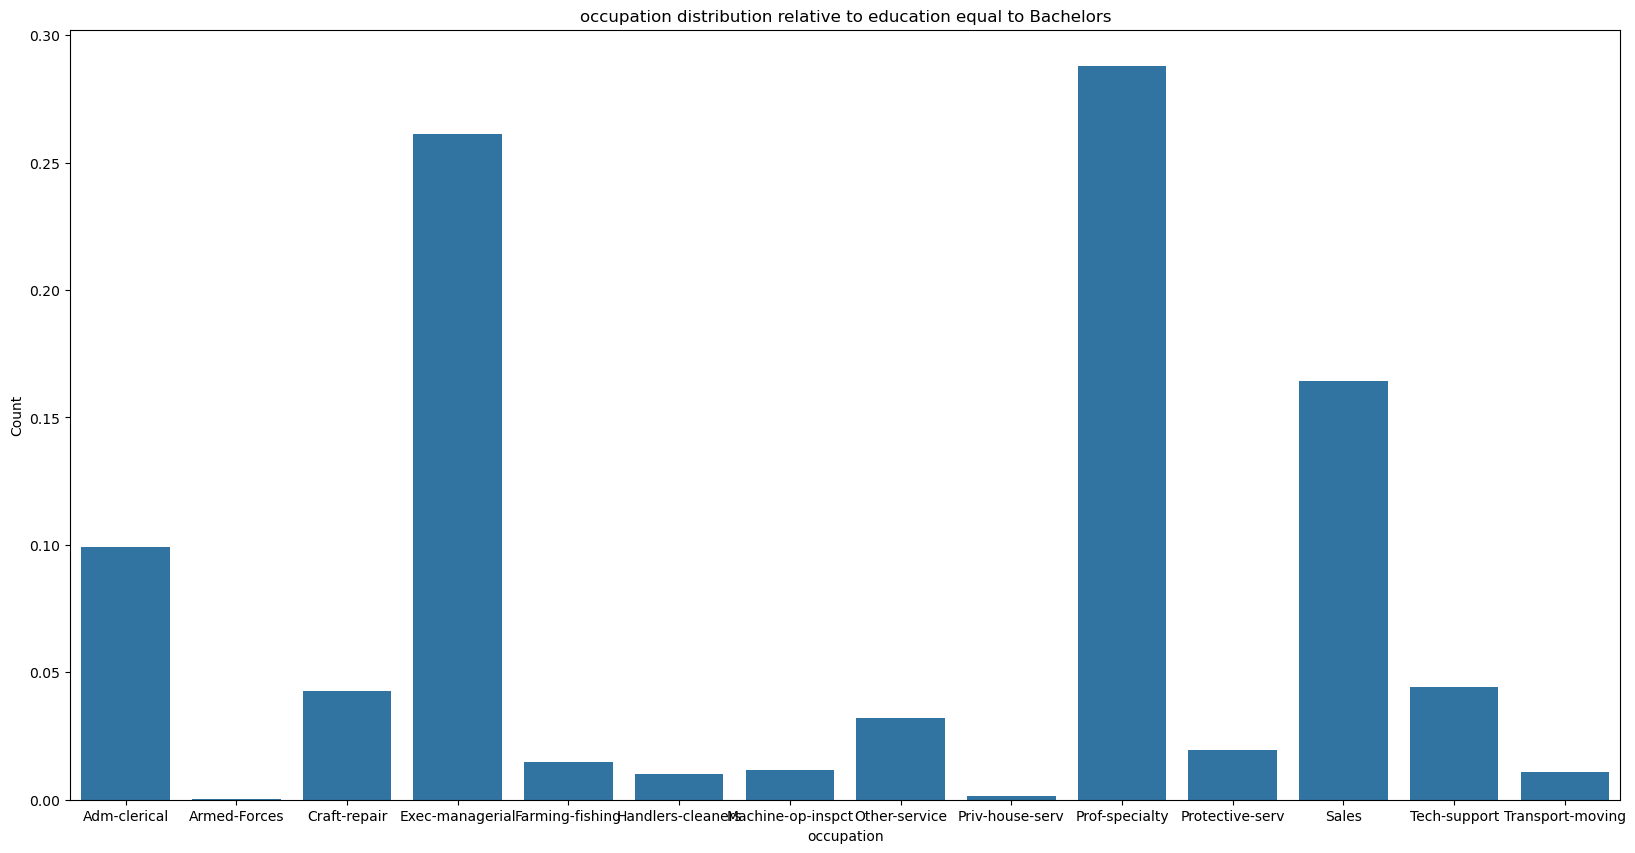

In [196]:
plot_hist(adult_features, "occupation", "education", "Bachelors")

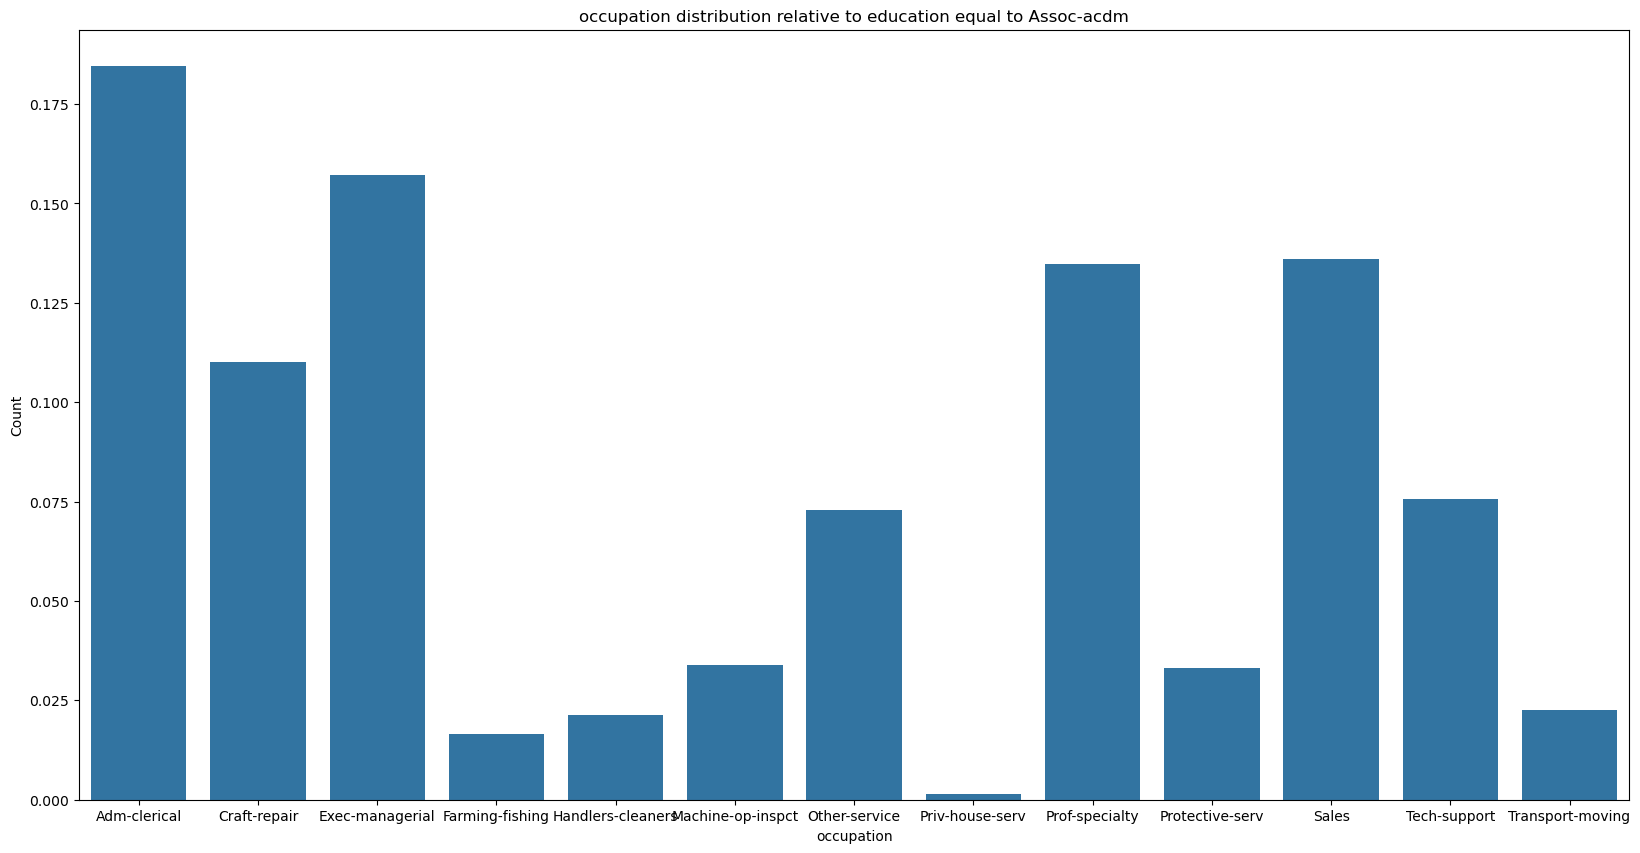

In [197]:
plot_hist(adult_features, "occupation", "education", "Assoc-acdm")

Sensibly messier w.r.t. the top three.

## 8.2 Education and Workclass

In [198]:
sorted_edu = np.unique(adult_features["education"])
print(sorted_edu)

['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college']


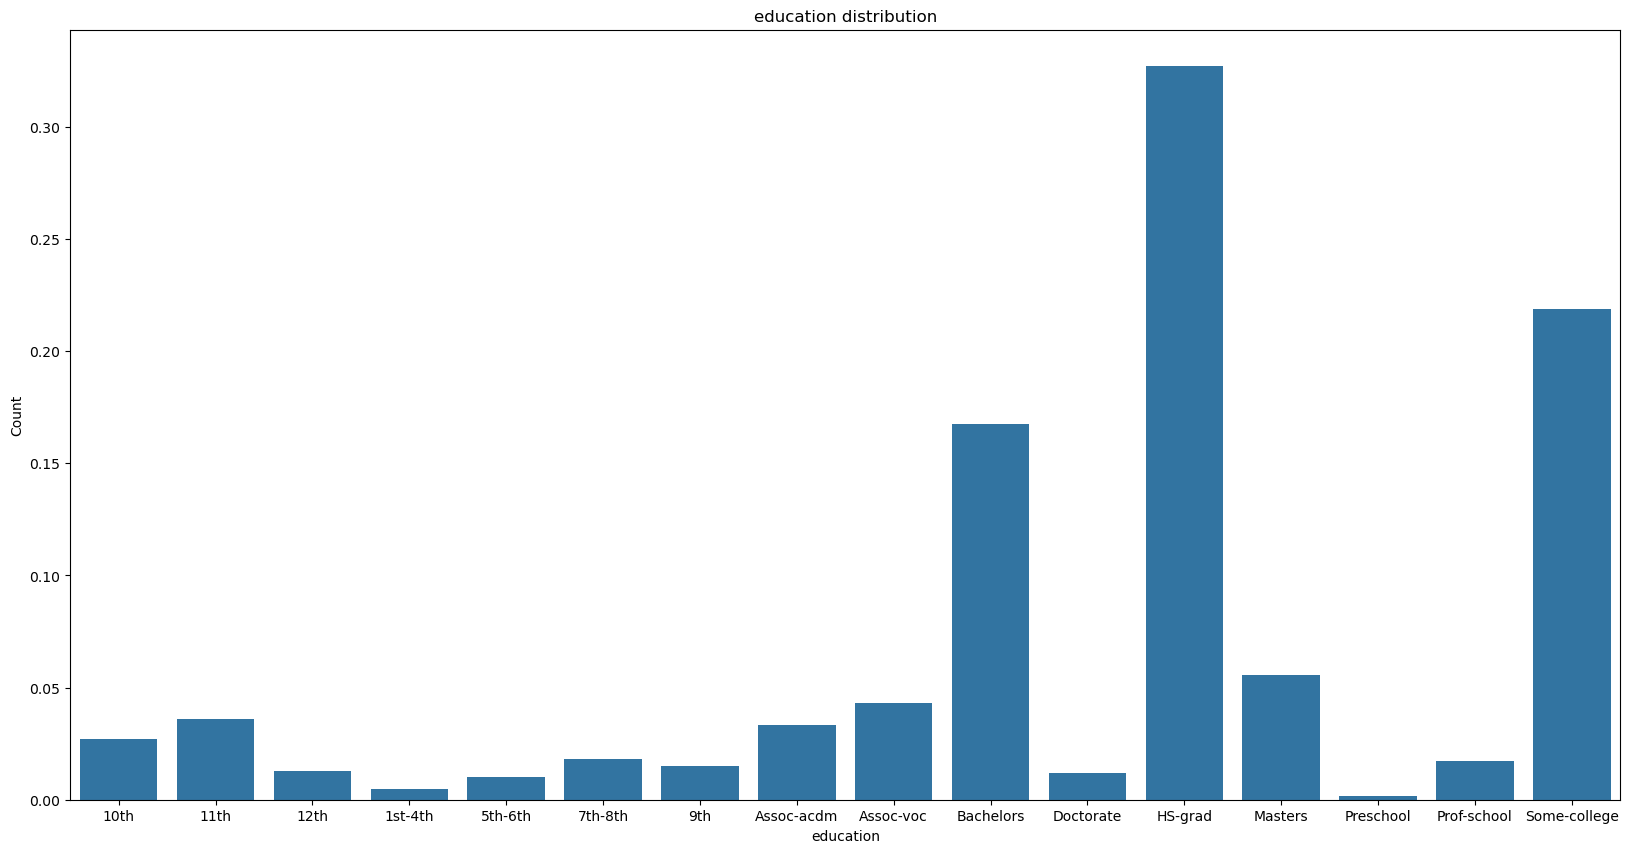

In [199]:
plot_hist(adult_features, "education")

In [200]:
sorted_work = np.unique(adult_features["workclass"])
print(sorted_work)

['Federal-gov' 'Local-gov' 'Private' 'Self-emp-inc' 'Self-emp-not-inc'
 'State-gov' 'Without-pay']


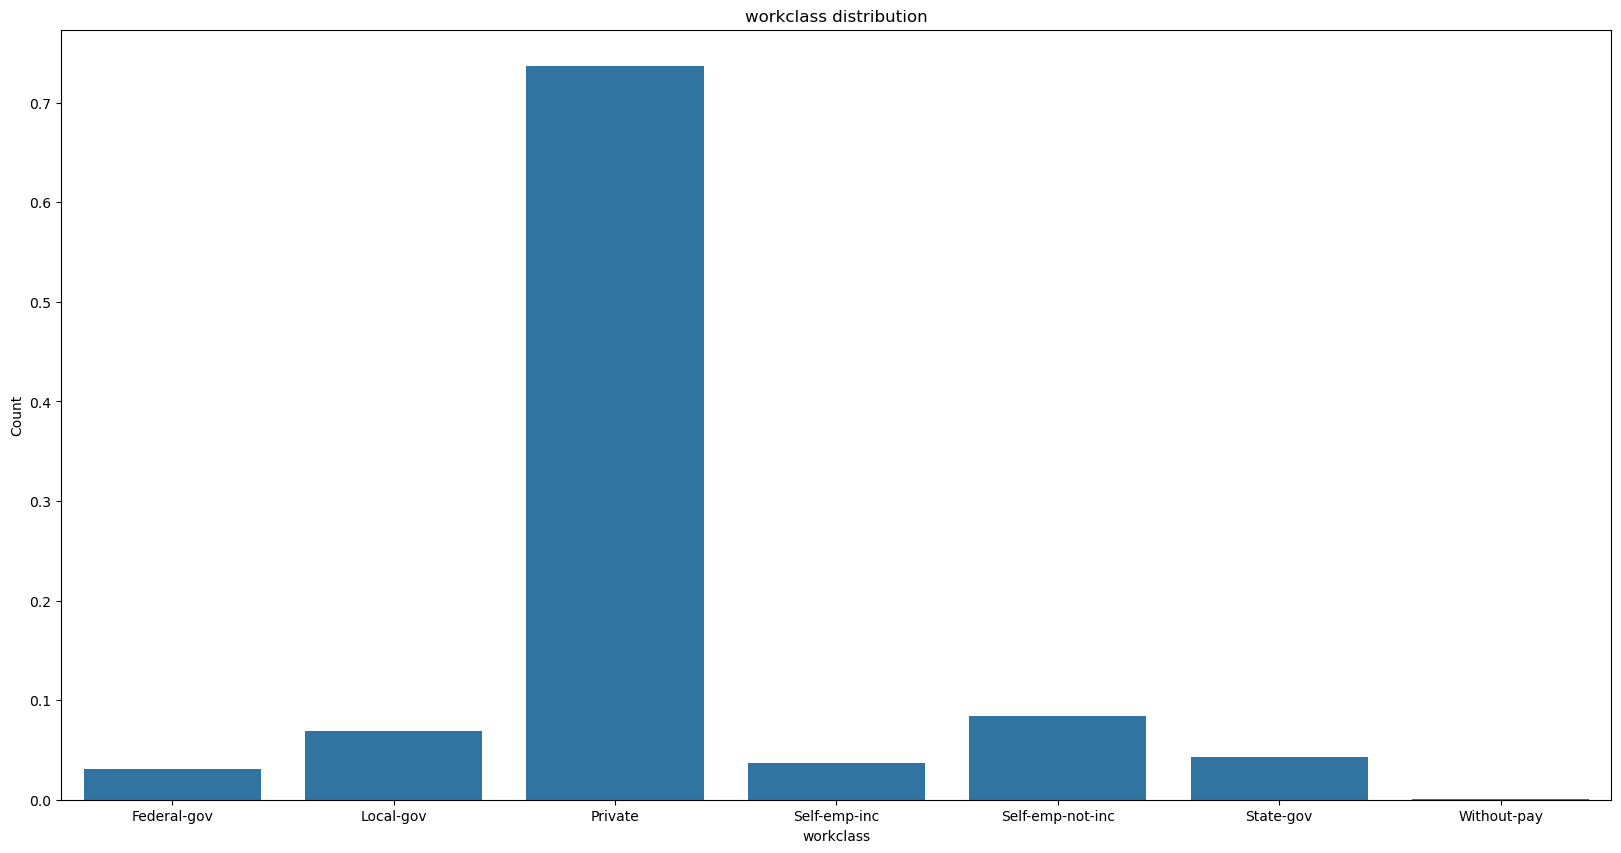

In [201]:
plot_hist(adult_features, "workclass")

### Computing the correlation

In [202]:
education_workclass = compute_correlation(adult_features, "education", "workclass", my_kernel_one_hot)

In [203]:
print(education_workclass.value)

0.21381110332053718


In [204]:
confusion_matrix = pd.crosstab(adult_features["education"], adult_features["workclass"])
cramer_education_workclass = cramers_v(confusion_matrix.values)

In [205]:
print(cramer_education_workclass)

0.10820037850597394


### Let's have a look at the alpha coefficients

In [206]:
print_coefficients_alphabetical(sorted_edu, education_workclass.alpha)

10th         : 0.05904269105725934
11th         : 0.07560094105314147
12th         : 0.06244512046376863
1st-4th      : 0.09000745816459178
5th-6th      : 0.08128638416390634
7th-8th      : 0.040670798372910044
9th          : 0.05985572409696697
Assoc-acdm   : -0.005354316647127599
Assoc-voc    : 0.0195715028942331
Bachelors    : -0.023568373615399252
Doctorate    : -0.1509430531289061
HS-grad      : 0.03618260930813703
Masters      : -0.114433936432569
Preschool    : 0.0716616849399687
Prof-school  : -0.09623125211193533
Some-college : 0.013144153549179242


In [207]:
print_coefficients(sorted_edu, education_workclass.alpha)

1st-4th      : 0.09000745816459178
5th-6th      : 0.08128638416390634
11th         : 0.07560094105314147
Preschool    : 0.0716616849399687
12th         : 0.06244512046376863
9th          : 0.05985572409696697
10th         : 0.05904269105725934
7th-8th      : 0.040670798372910044
HS-grad      : 0.03618260930813703
Assoc-voc    : 0.0195715028942331
Some-college : 0.013144153549179242
Assoc-acdm   : -0.005354316647127599
Bachelors    : -0.023568373615399252
Prof-school  : -0.09623125211193533
Masters      : -0.114433936432569
Doctorate    : -0.1509430531289061


#### Top three positive coefficients

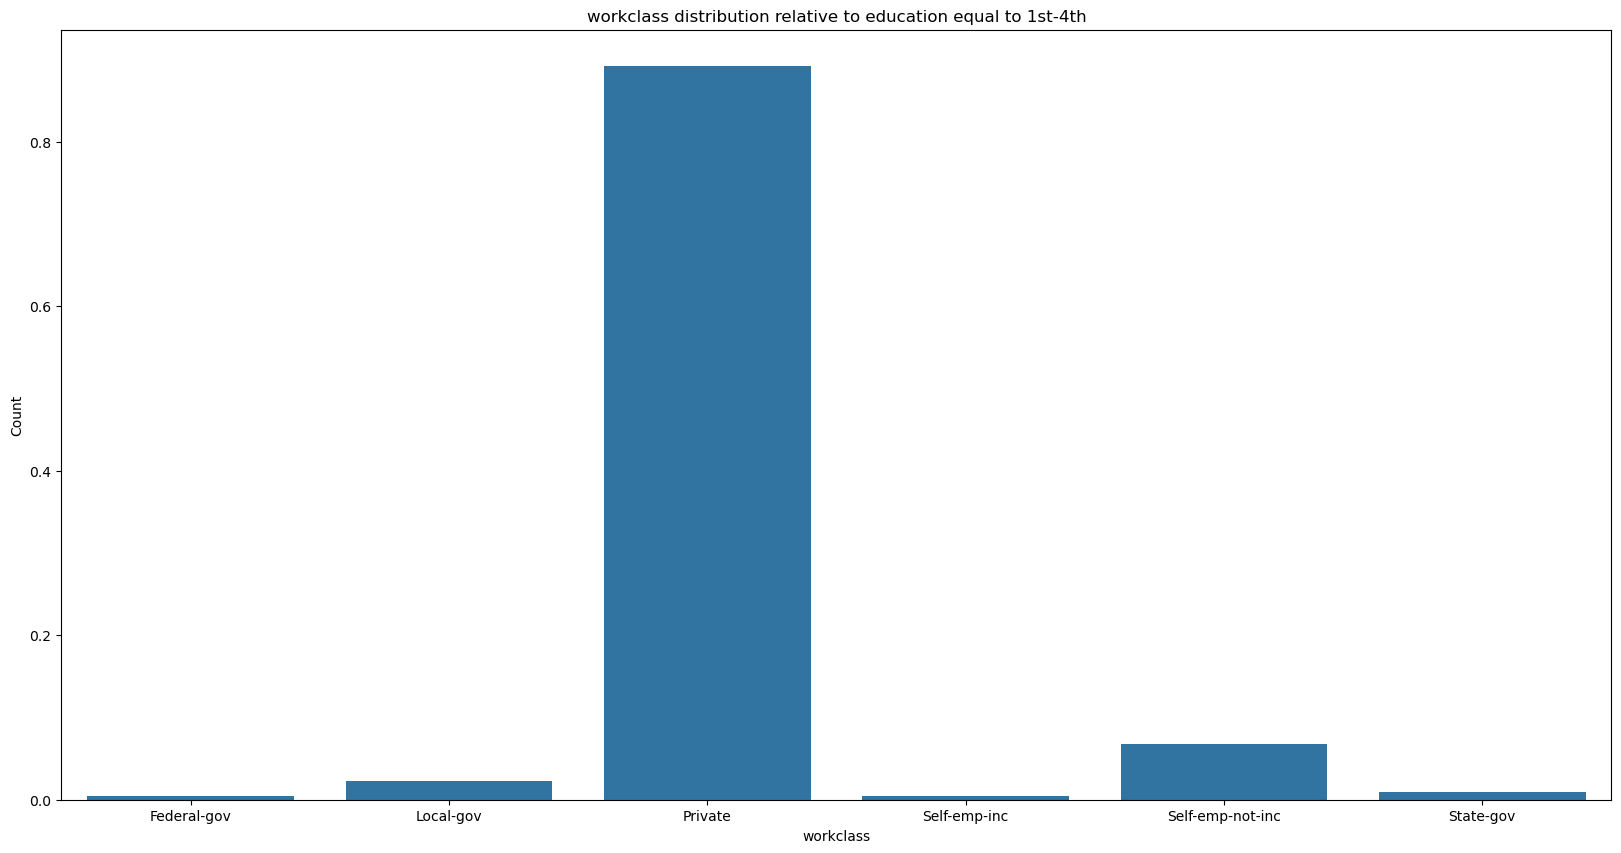

In [208]:
plot_hist(adult_features, "workclass", "education", "1st-4th")

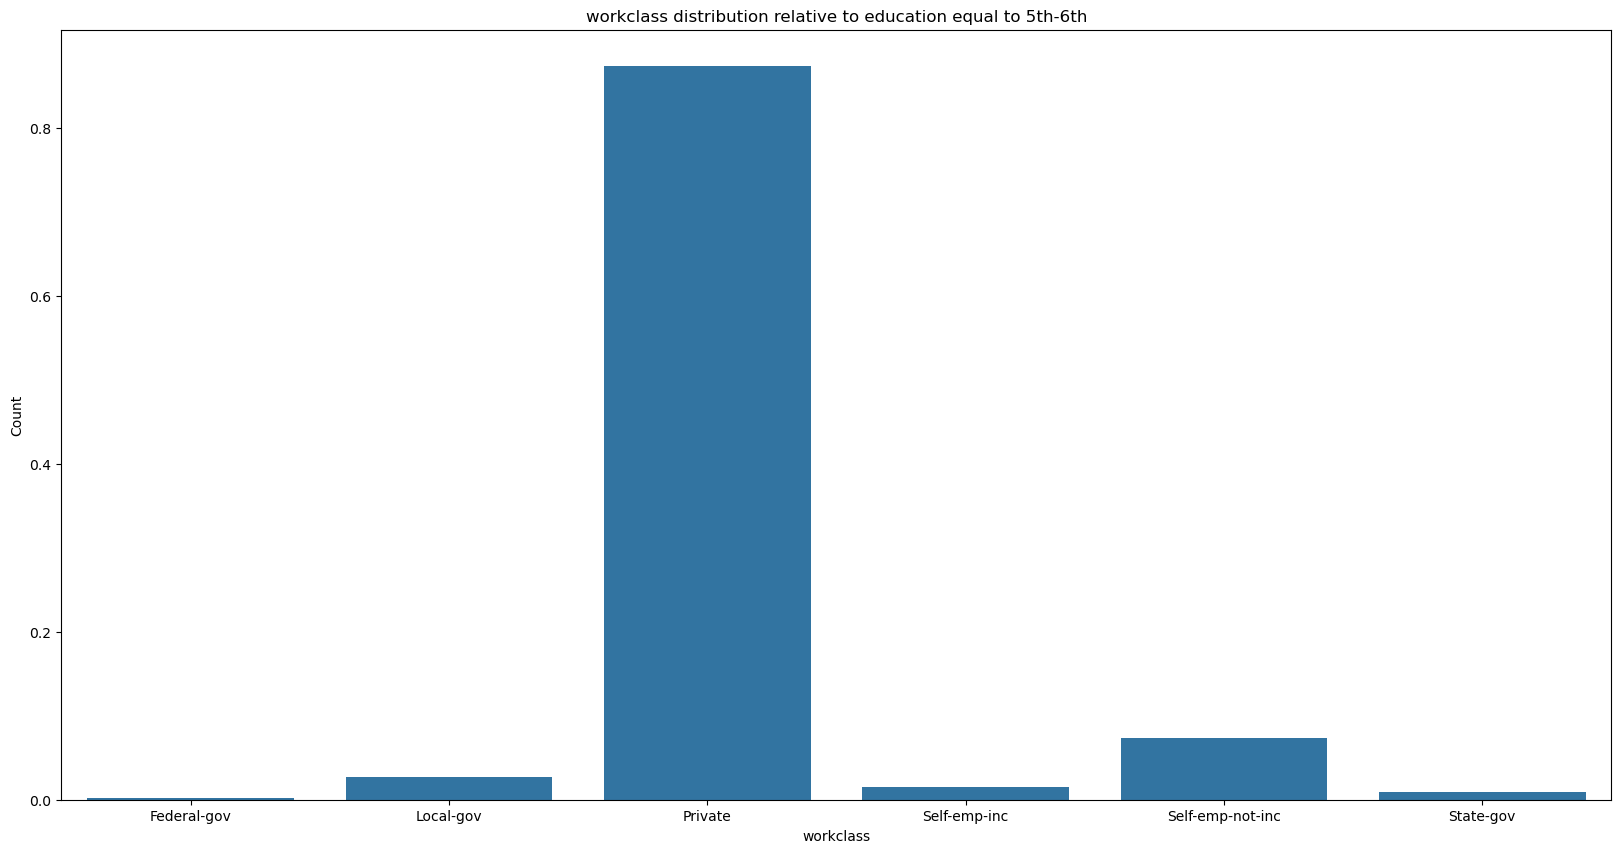

In [209]:
plot_hist(adult_features, "workclass", "education", "5th-6th")

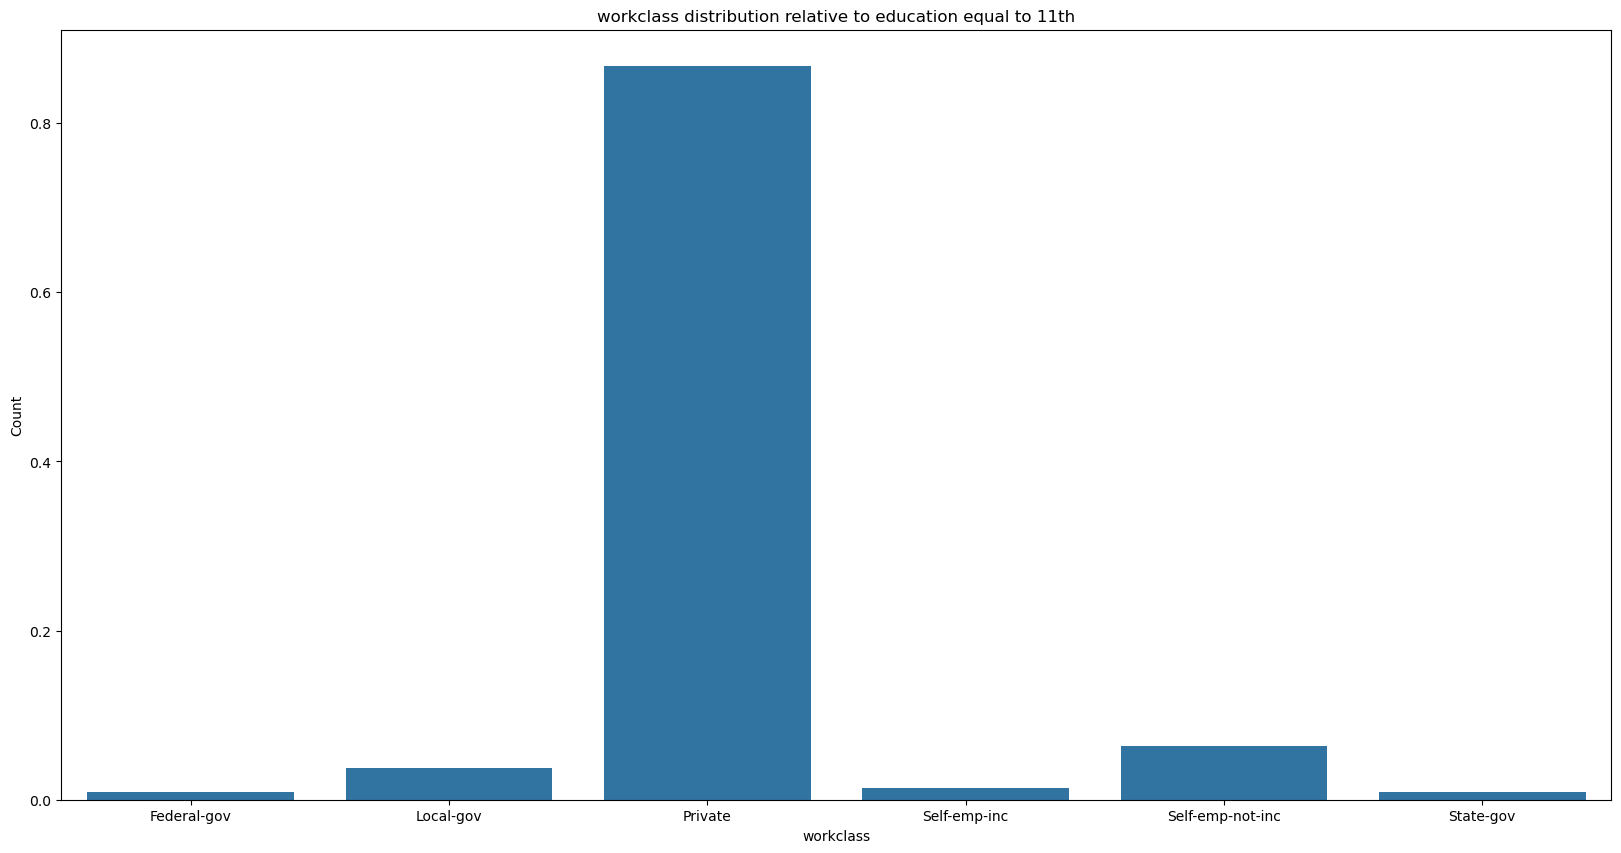

In [210]:
plot_hist(adult_features, "workclass", "education", "11th")

Even if they are the "top" ones, they are really small and, in fact, they mirror the original distribution of workclass a lot.

#### Bottom three positive coefficients

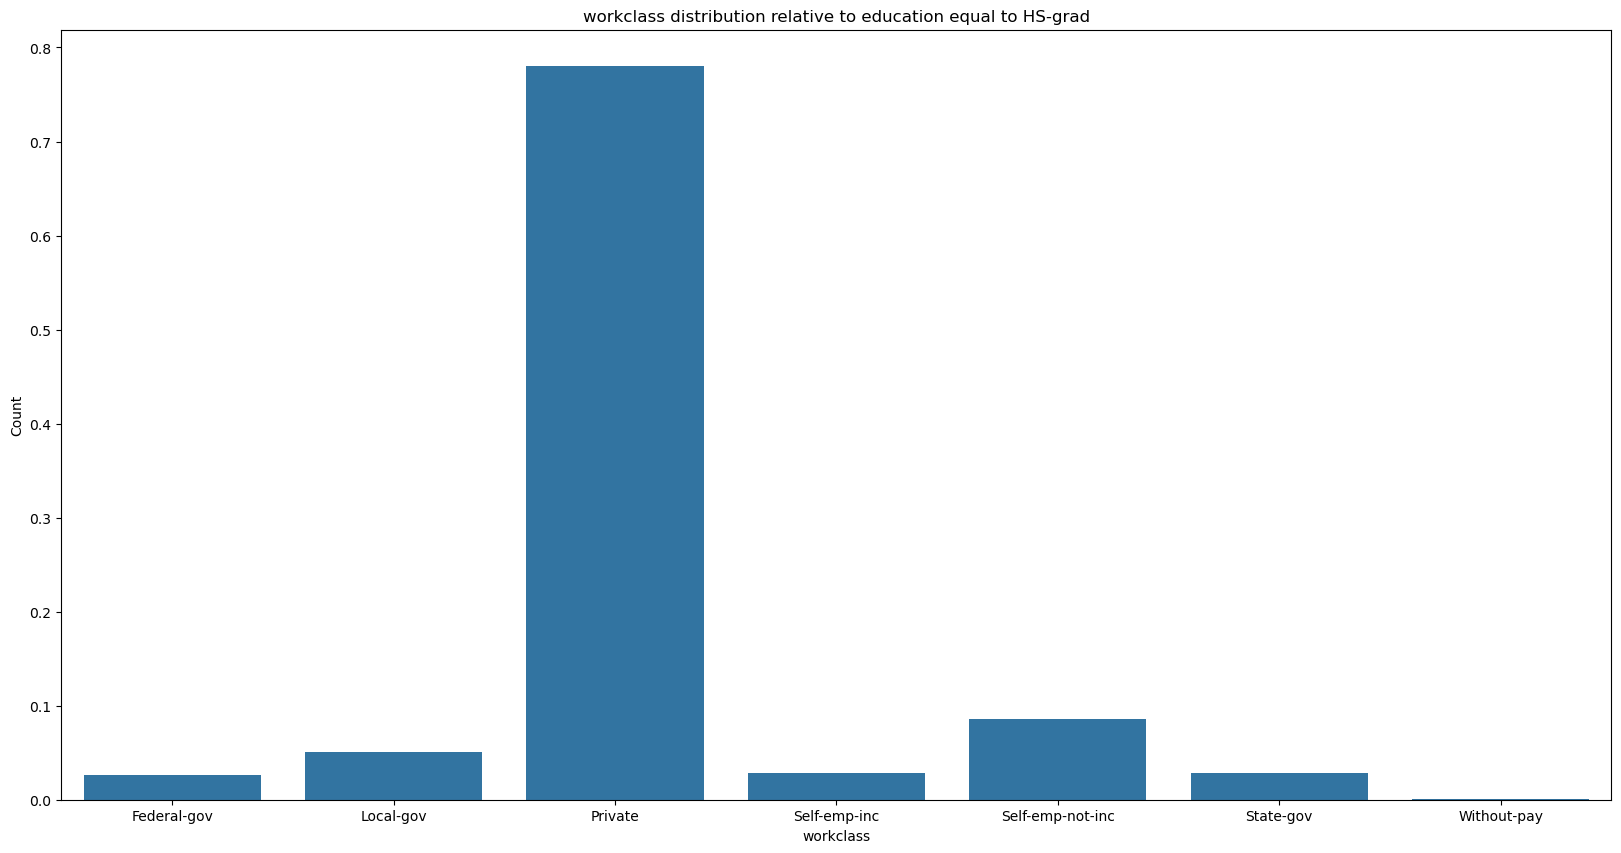

In [211]:
plot_hist(adult_features, "workclass", "education", "HS-grad")

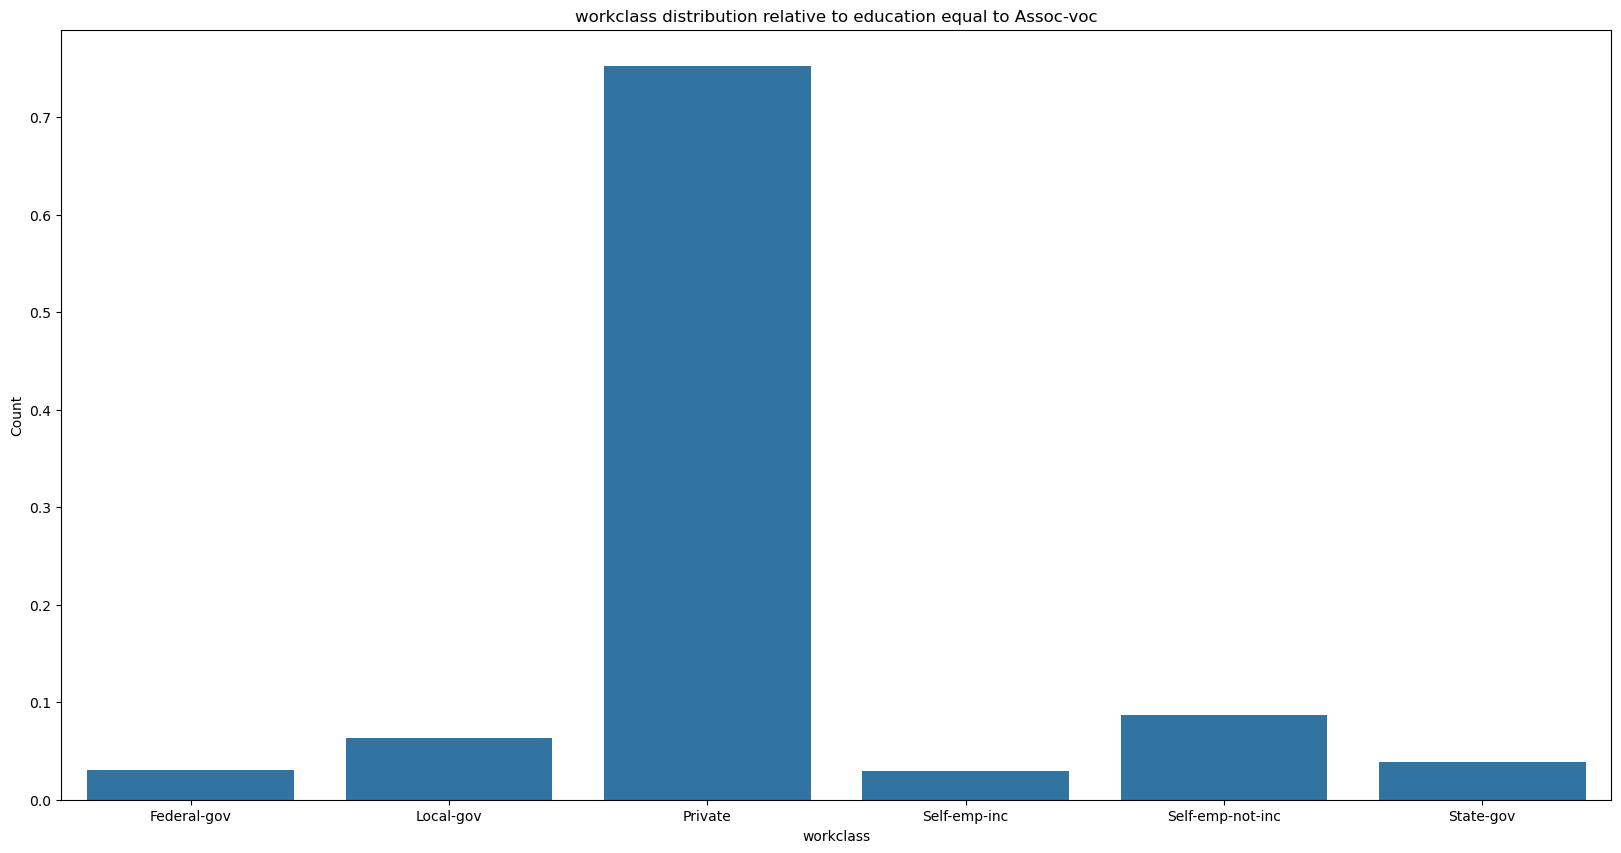

In [212]:
plot_hist(adult_features, "workclass", "education", "Assoc-voc")

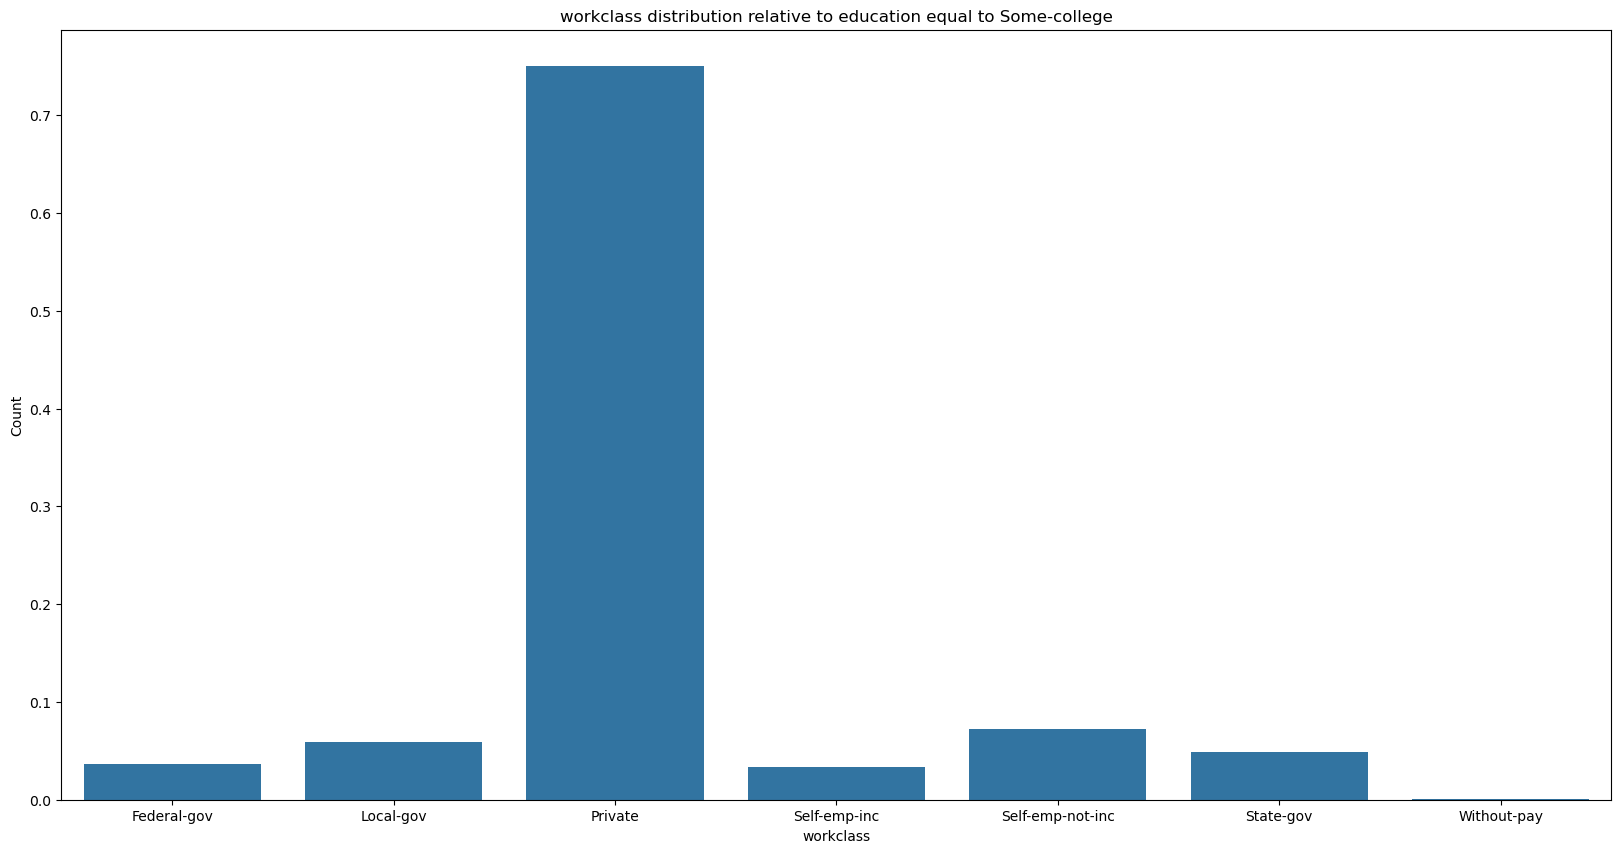

In [213]:
plot_hist(adult_features, "workclass", "education", "Some-college")

They also are really similar to the original distribution.

Top three negative coefficients

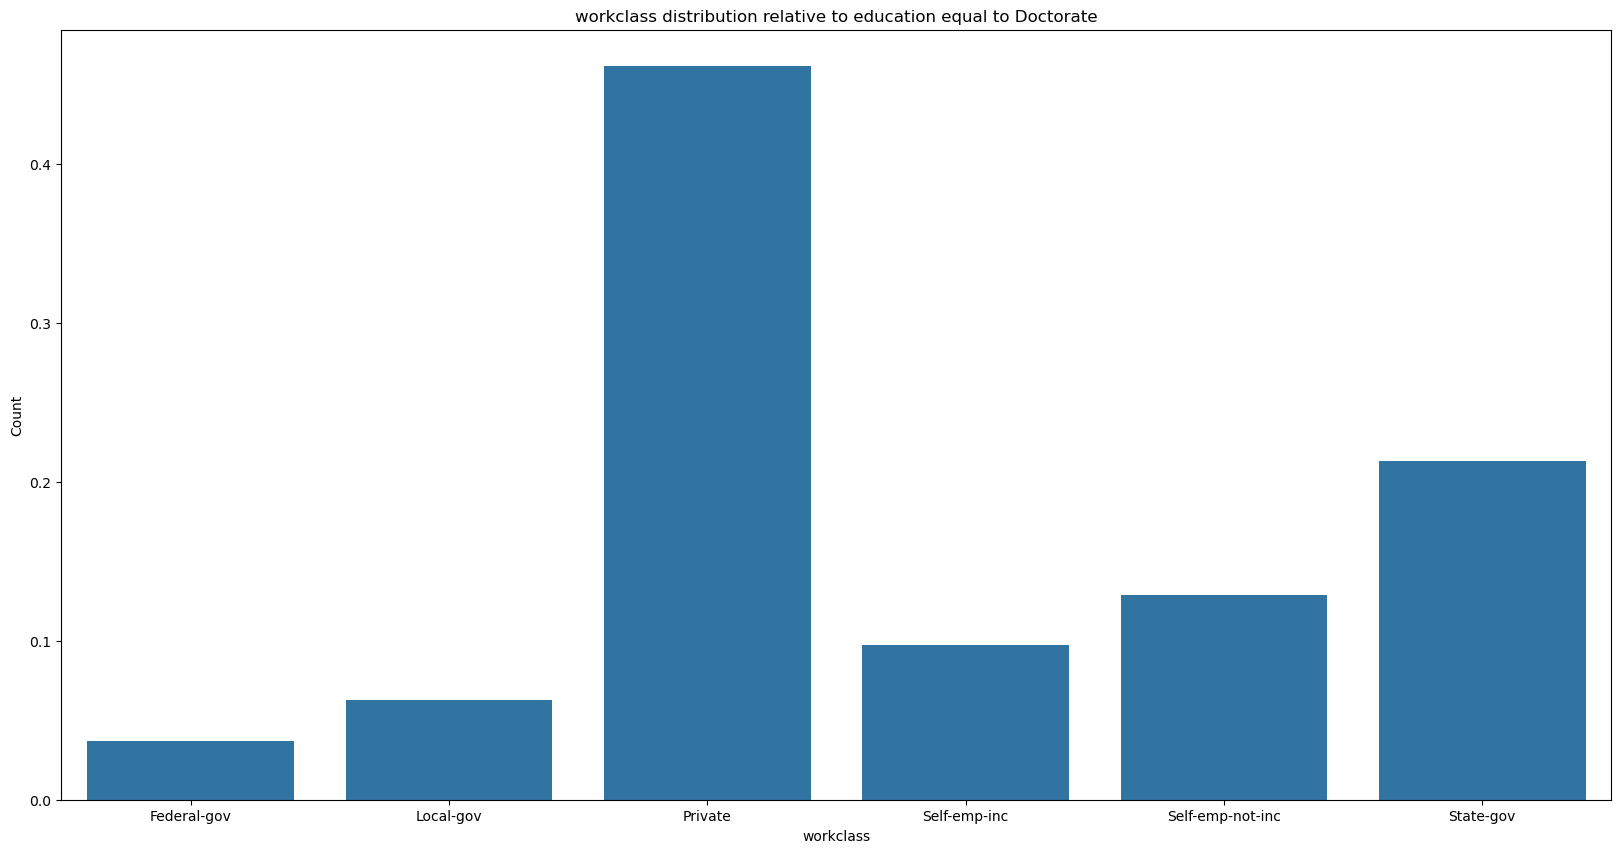

In [214]:
plot_hist(adult_features, "workclass", "education", "Doctorate")

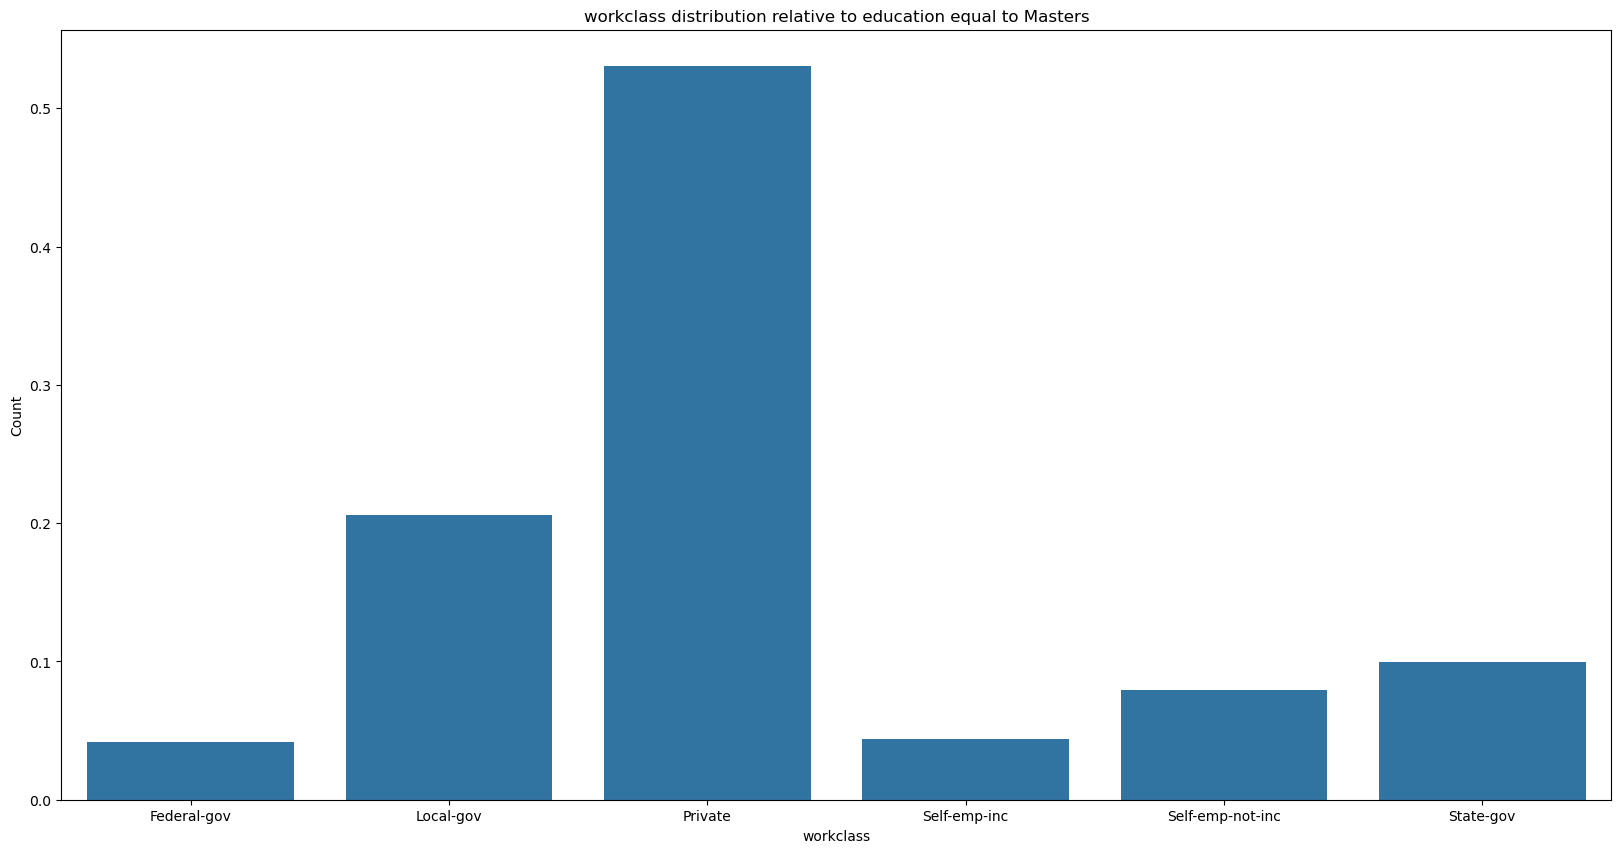

In [215]:
plot_hist(adult_features, "workclass", "education", "Masters")

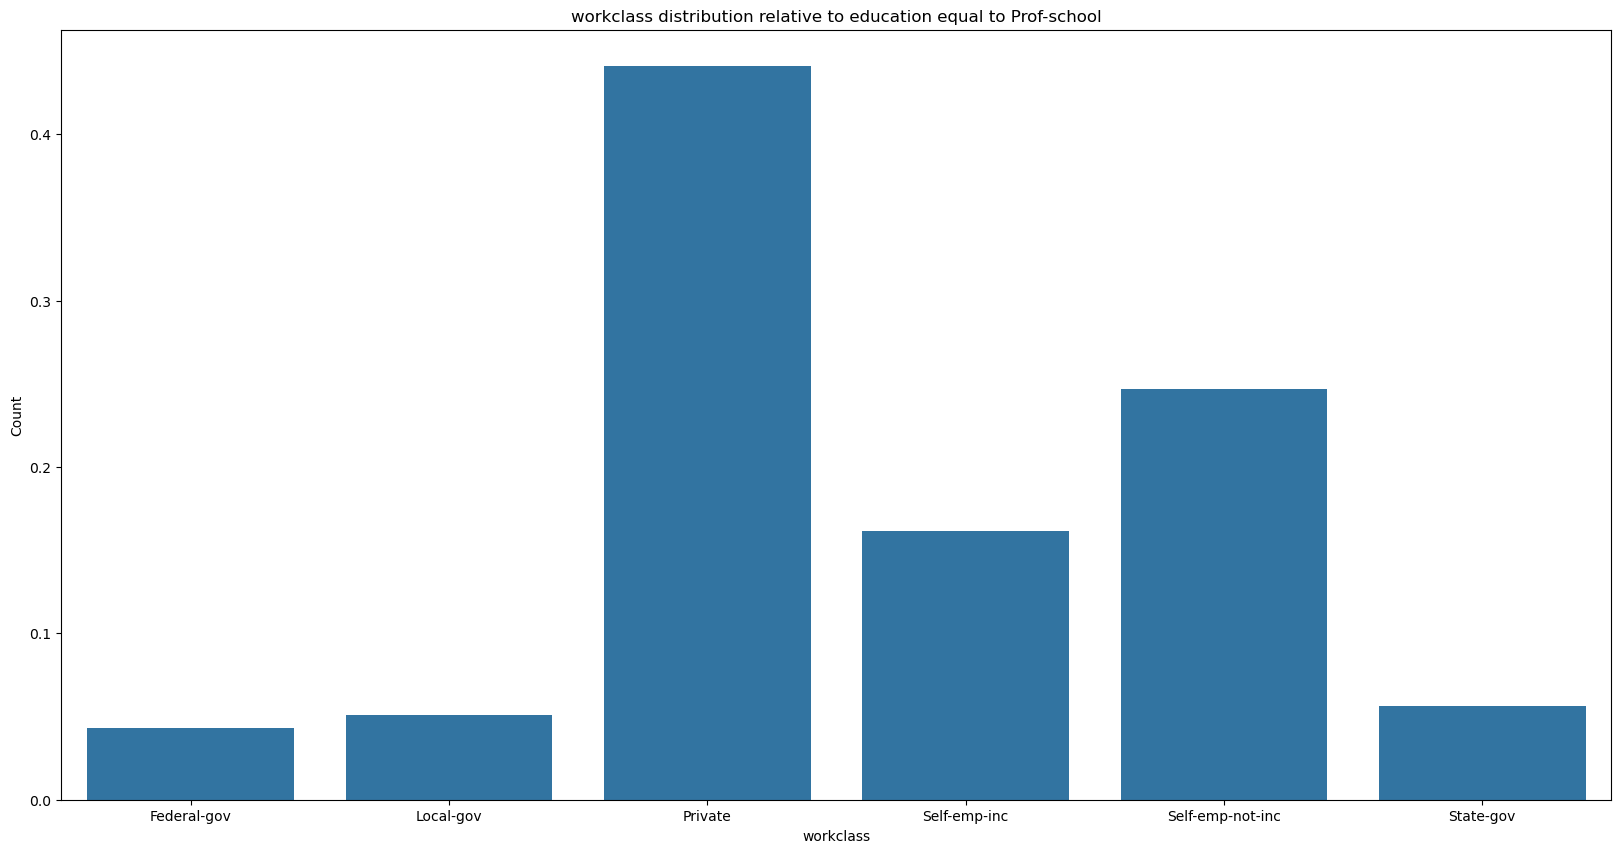

In [216]:
plot_hist(adult_features, "workclass", "education", "Prof-school")

Bottom two negative coefficients

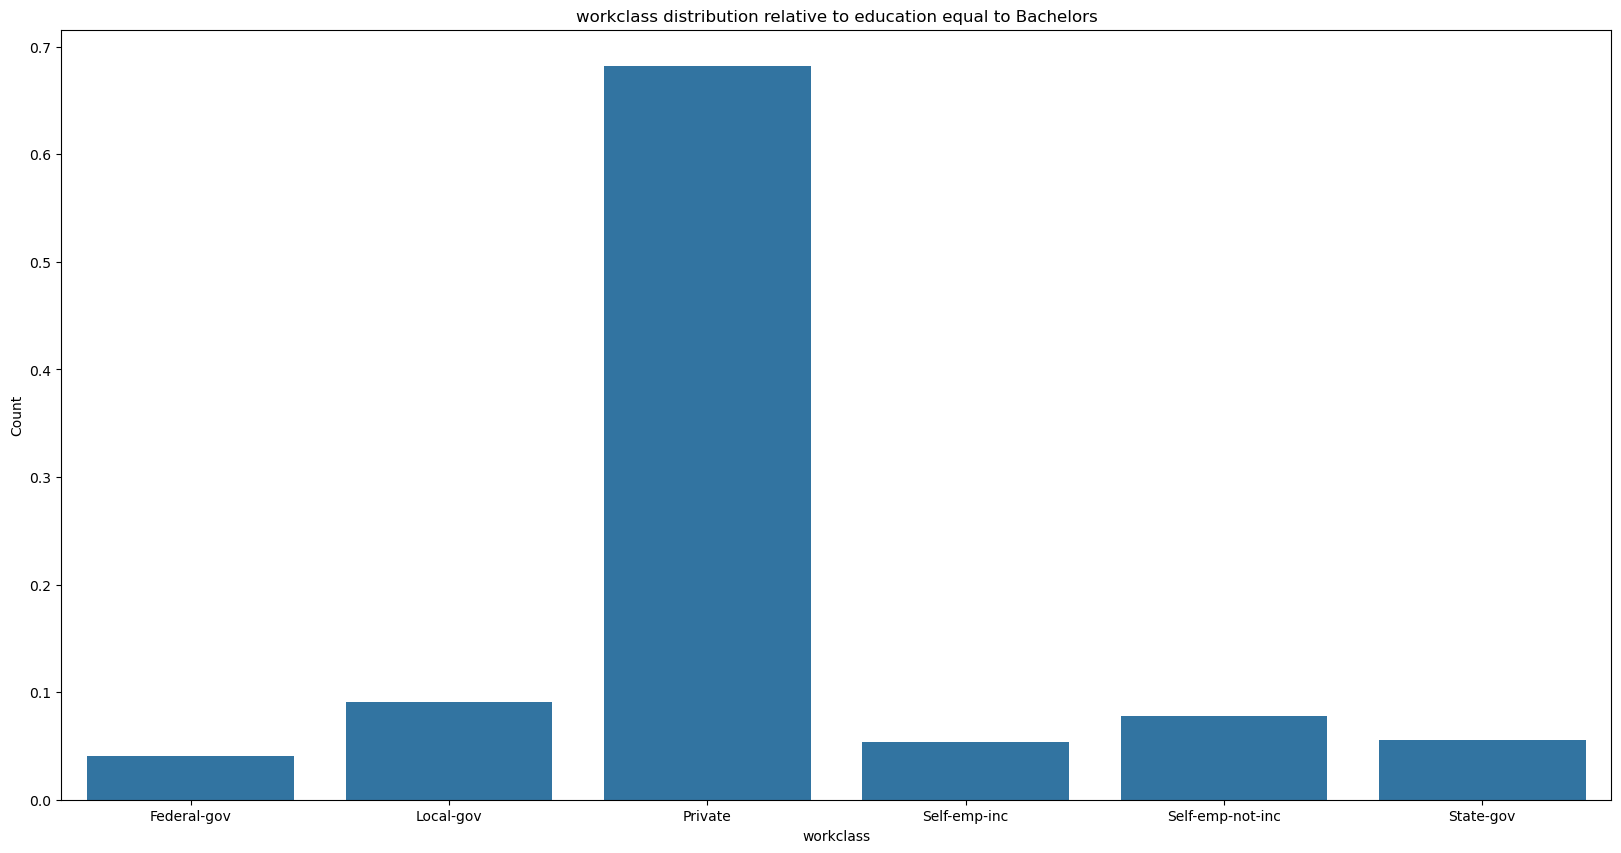

In [217]:
plot_hist(adult_features, "workclass", "education", "Bachelors")

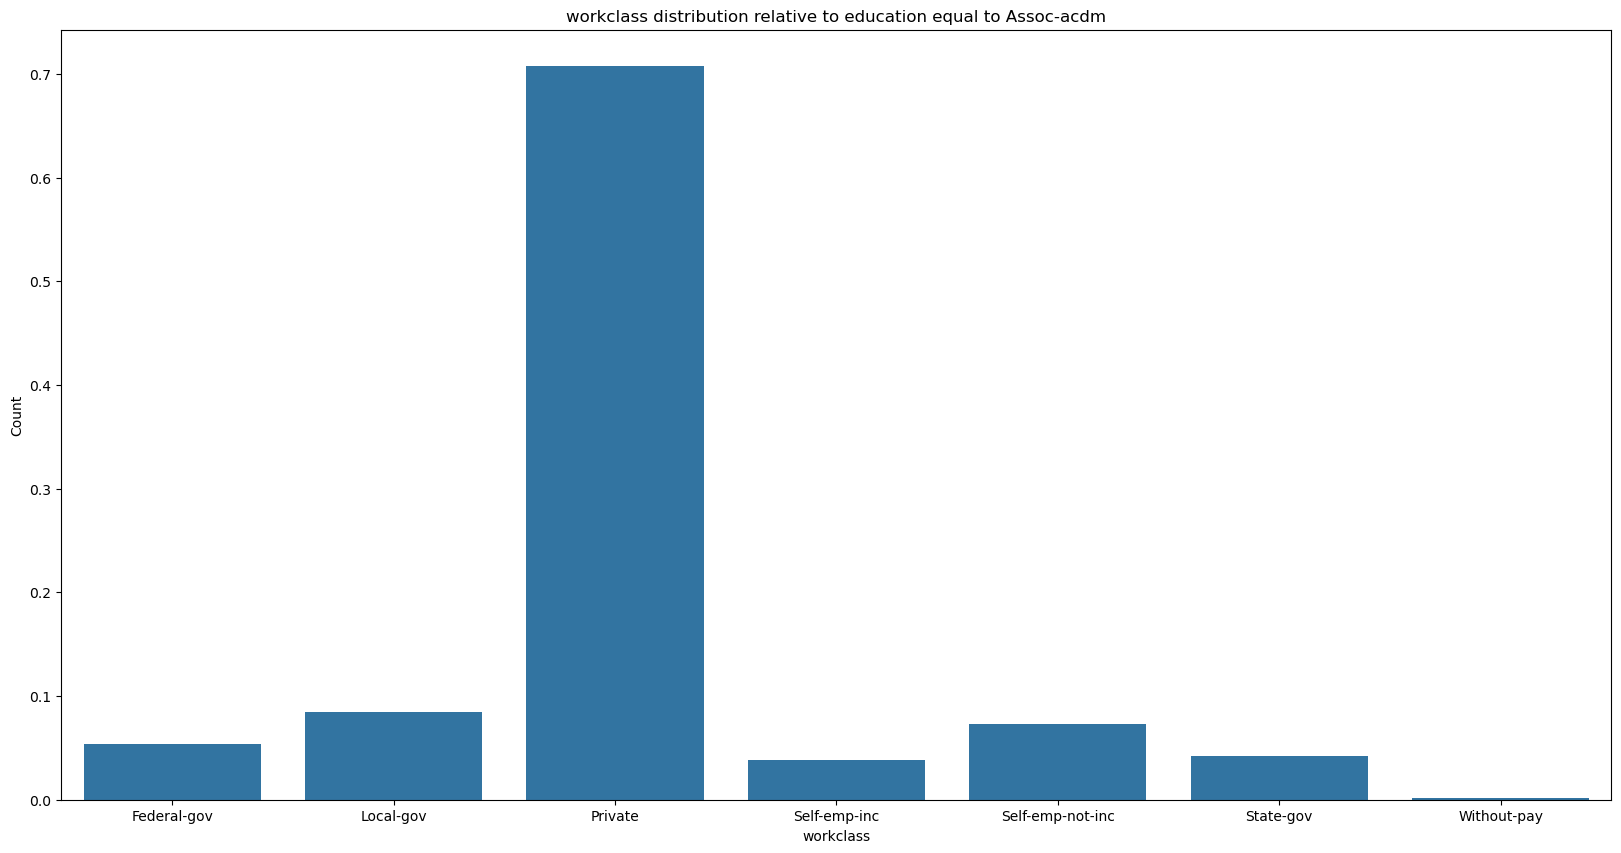

In [218]:
plot_hist(adult_features, "workclass", "education", "Assoc-acdm")

As we expected, the closer to 0 the more similar w.r.t. the original distribution.

### Let's have a look at the beta coefficients

In [219]:
print_coefficients_alphabetical(sorted_work, education_workclass.beta)

Federal-gov      : -0.022184015020026662
Local-gov        : -0.12100804990921471
Private          : 0.16725701185727077
Self-emp-inc     : -0.11052259011119081
Self-emp-not-inc : 0.06161151934374281
State-gov        : -0.190425836202379
Without-pay      : 0.32699097755617534


In [220]:
print_coefficients(sorted_work, education_workclass.beta)

Without-pay      : 0.32699097755617534
Private          : 0.16725701185727077
Self-emp-not-inc : 0.06161151934374281
Federal-gov      : -0.022184015020026662
Self-emp-inc     : -0.11052259011119081
Local-gov        : -0.12100804990921471
State-gov        : -0.190425836202379


#### Positive coefficients

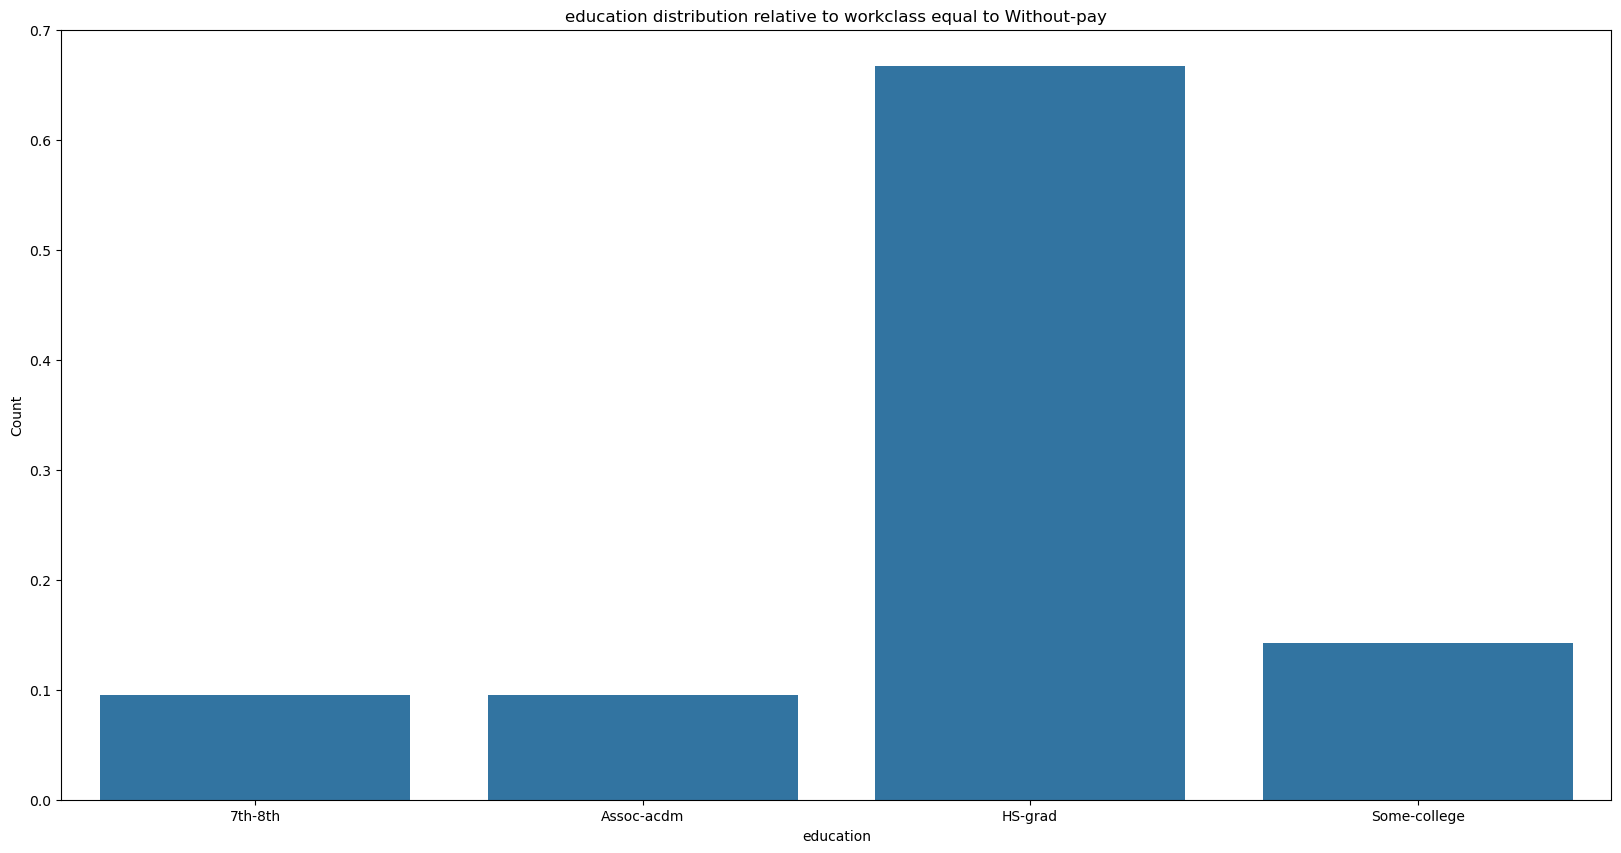

In [221]:
plot_hist(adult_features, "education", "workclass", "Without-pay")

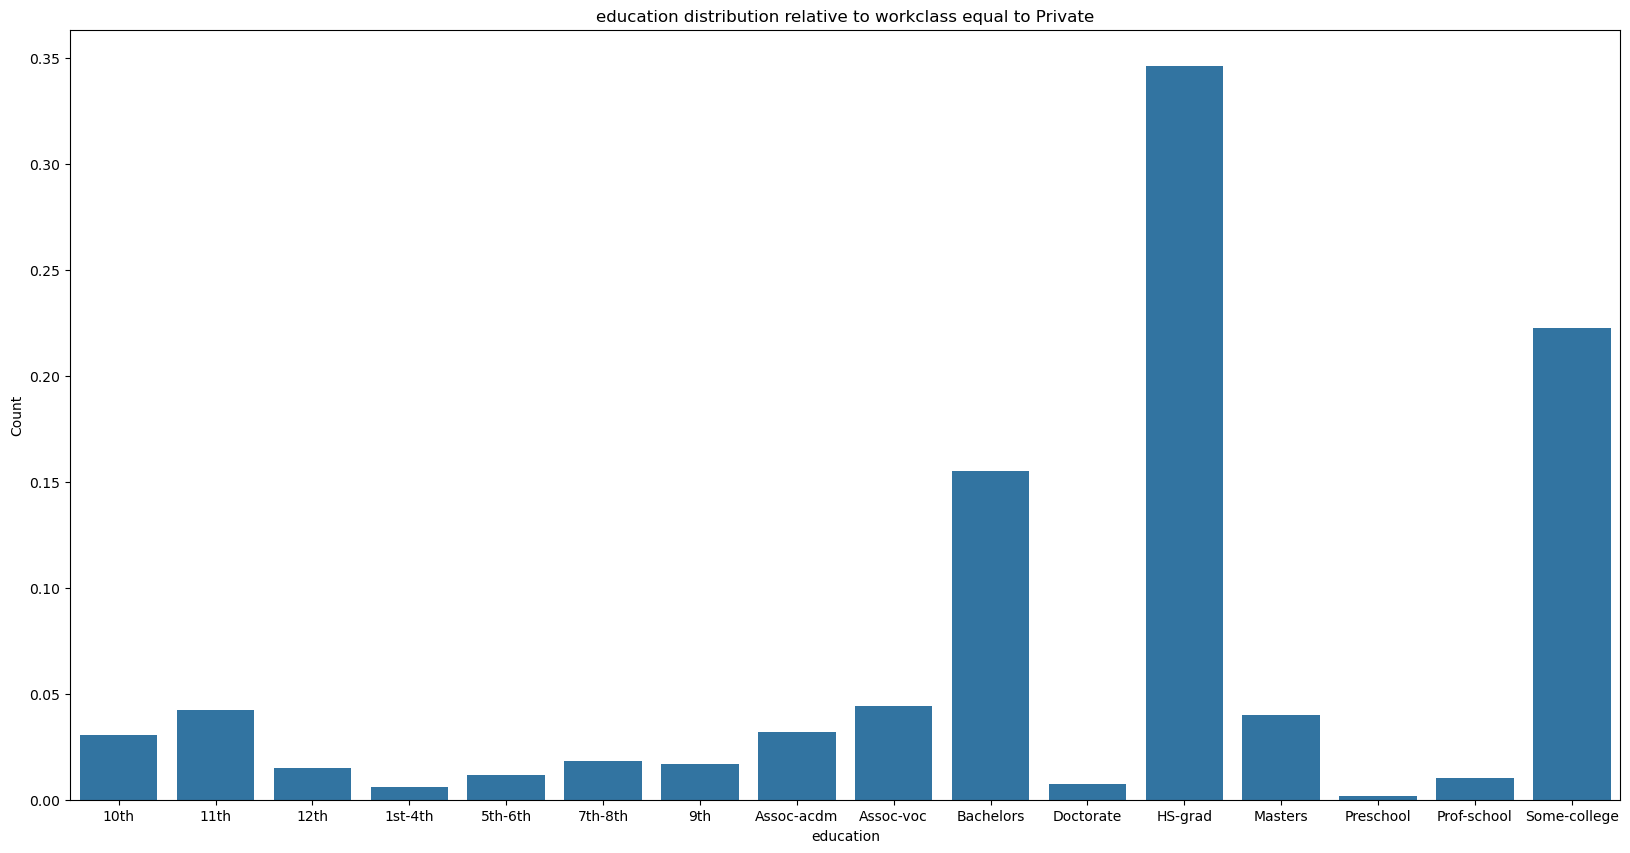

In [222]:
plot_hist(adult_features, "education", "workclass", "Private")

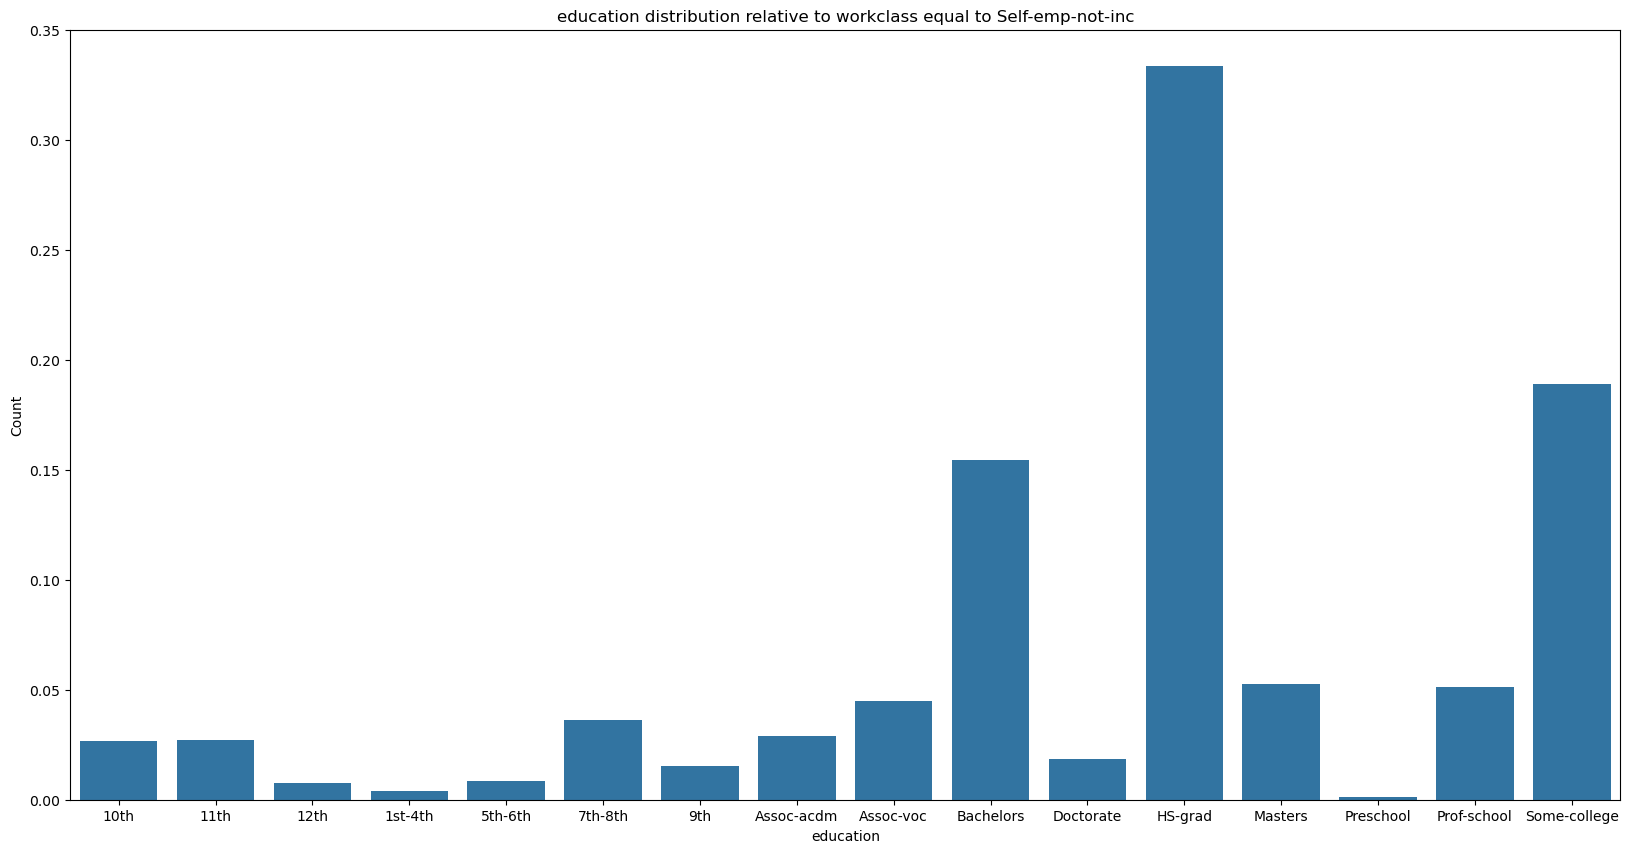

In [223]:
plot_hist(adult_features, "education", "workclass", "Self-emp-not-inc")

#### Negative coefficients

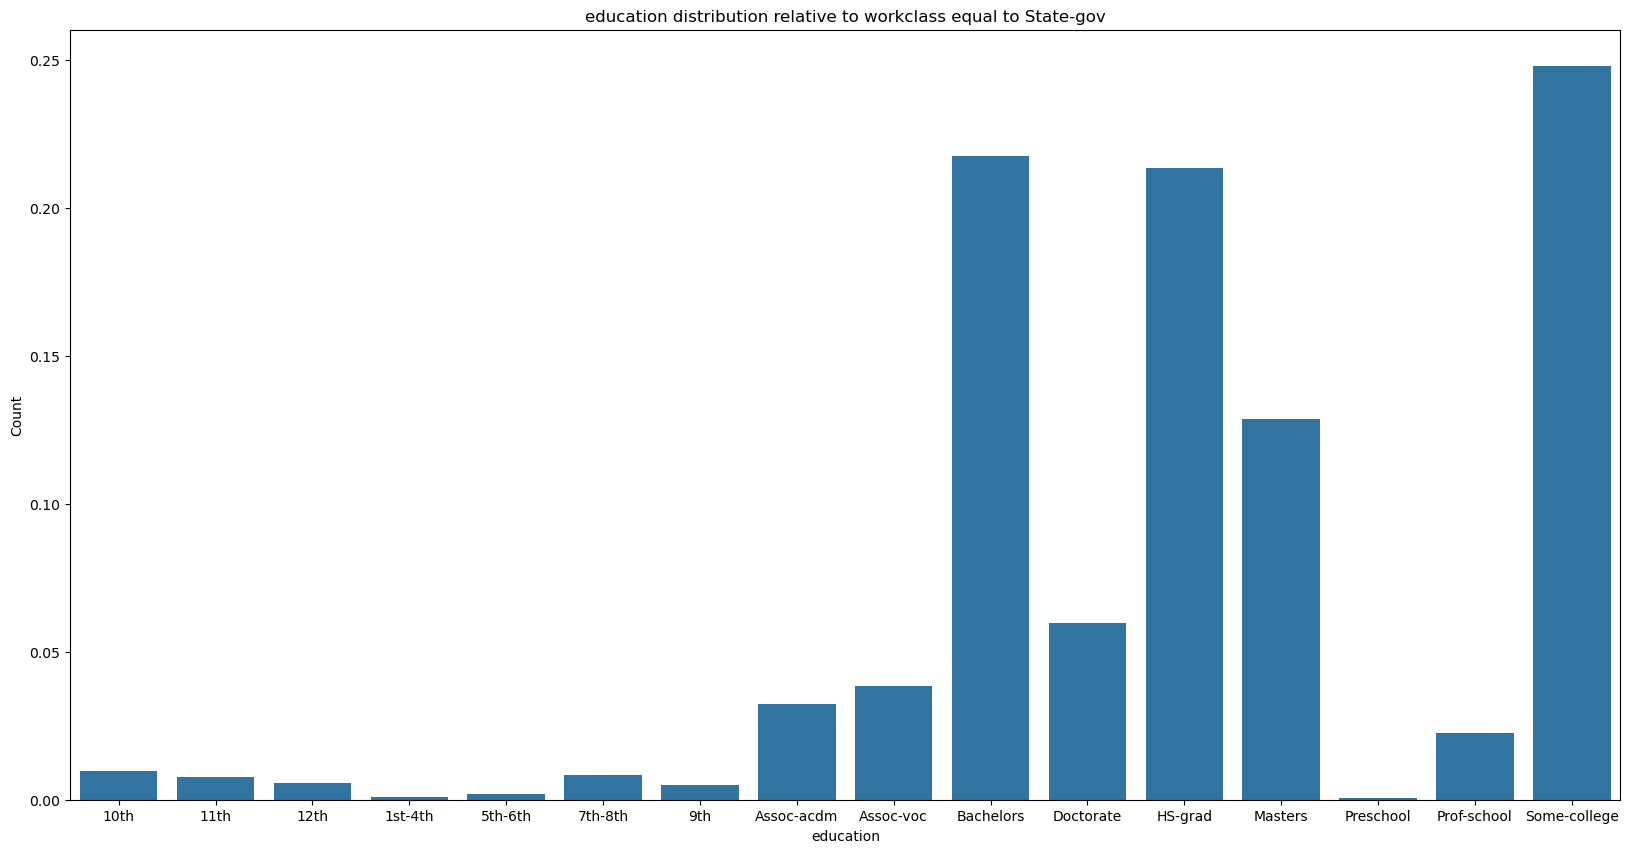

In [224]:
plot_hist(adult_features, "education", "workclass", "State-gov")

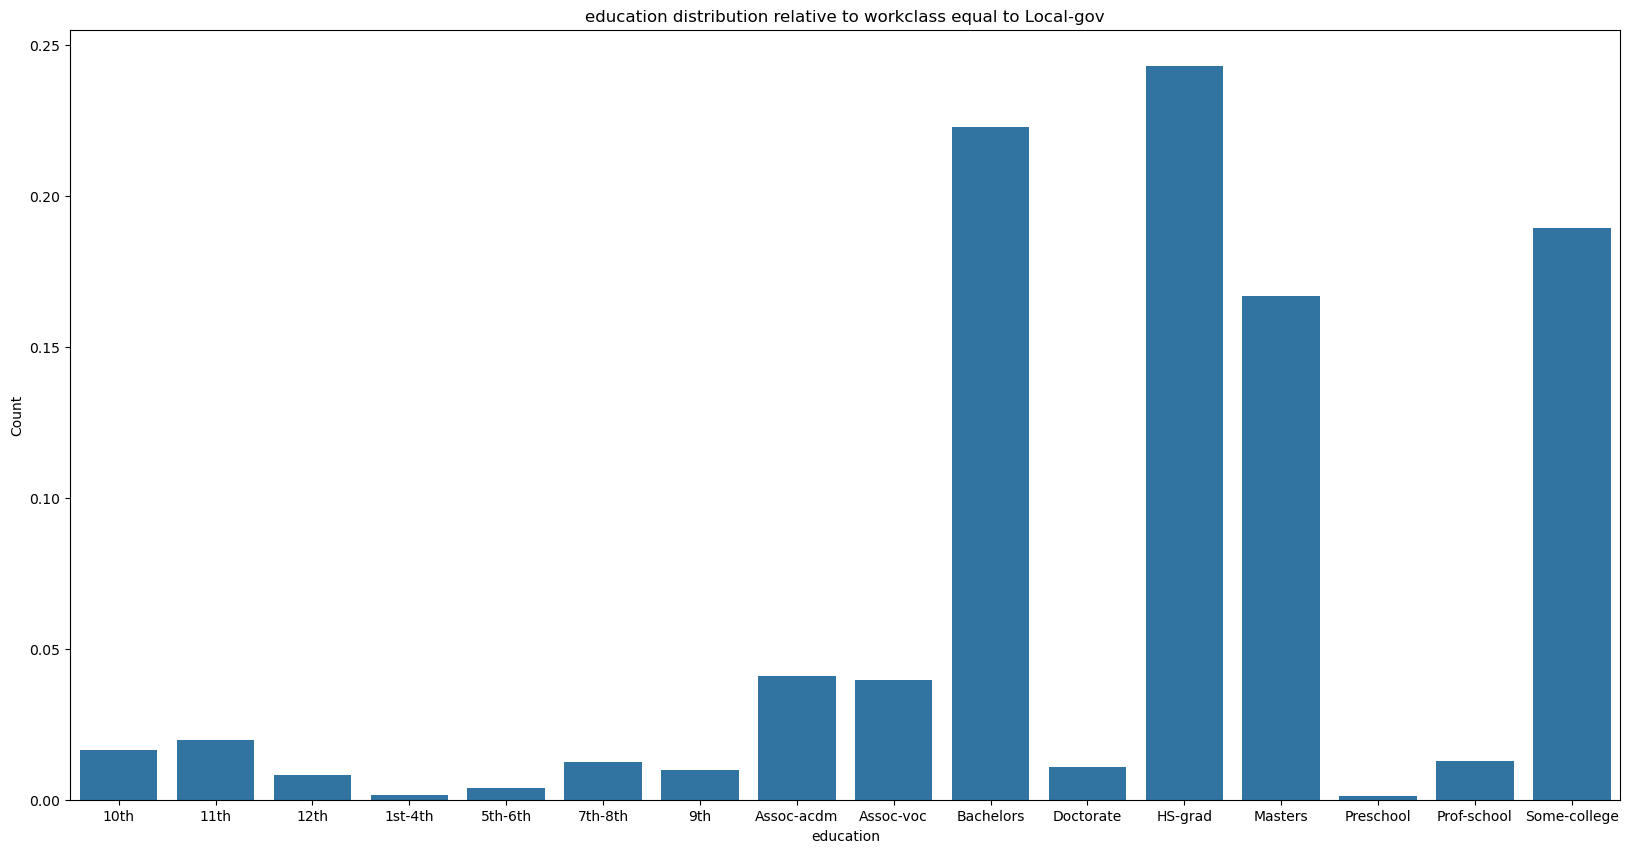

In [225]:
plot_hist(adult_features, "education", "workclass", "Local-gov")

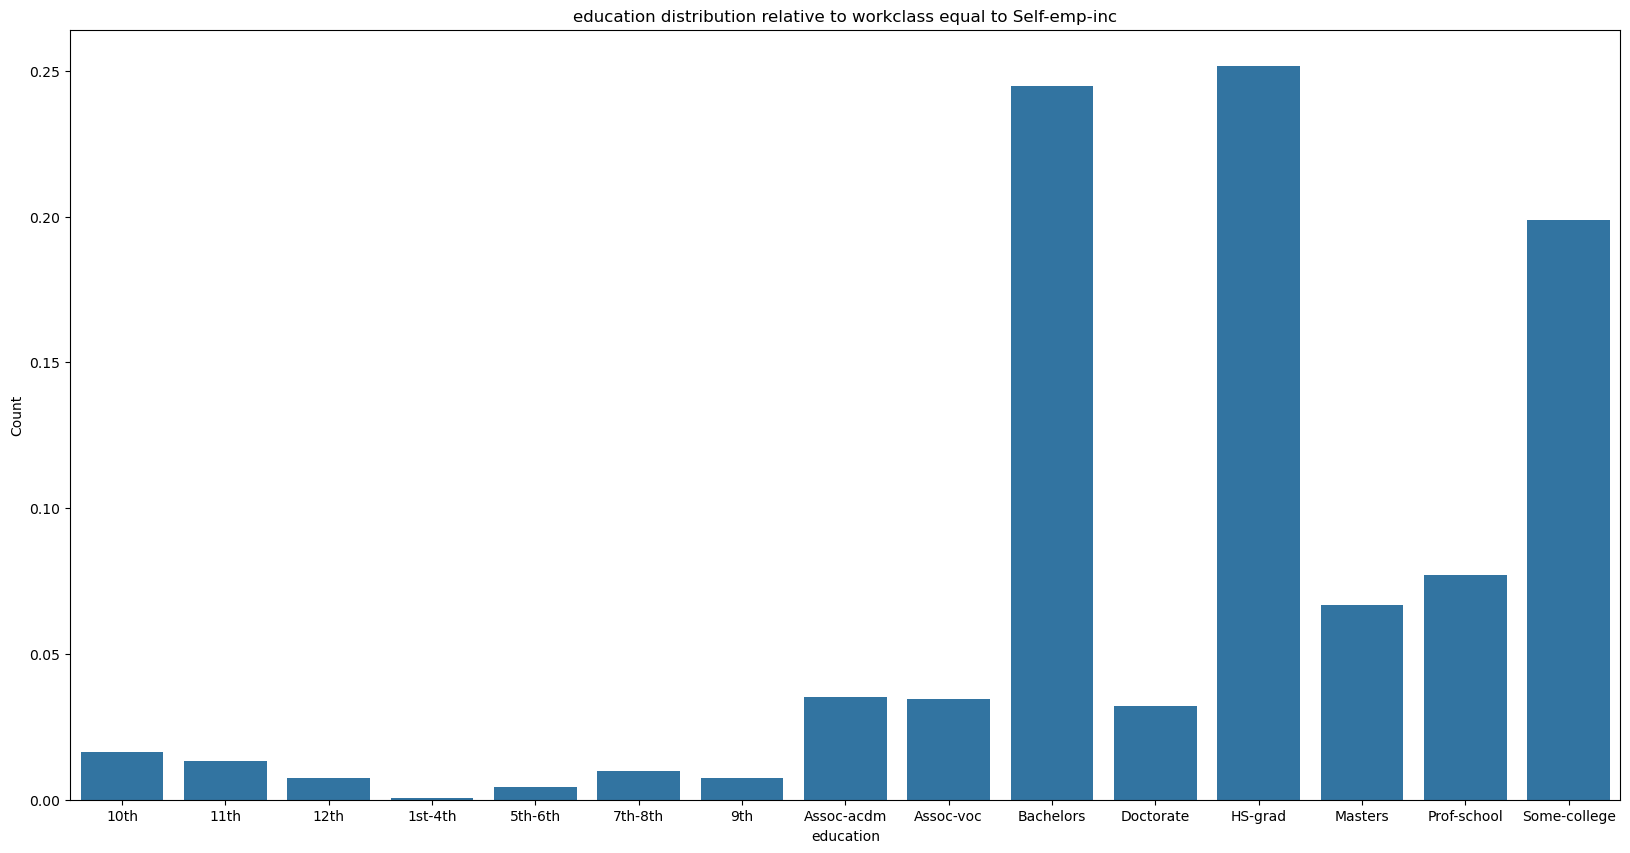

In [226]:
plot_hist(adult_features, "education", "workclass", "Self-emp-inc")

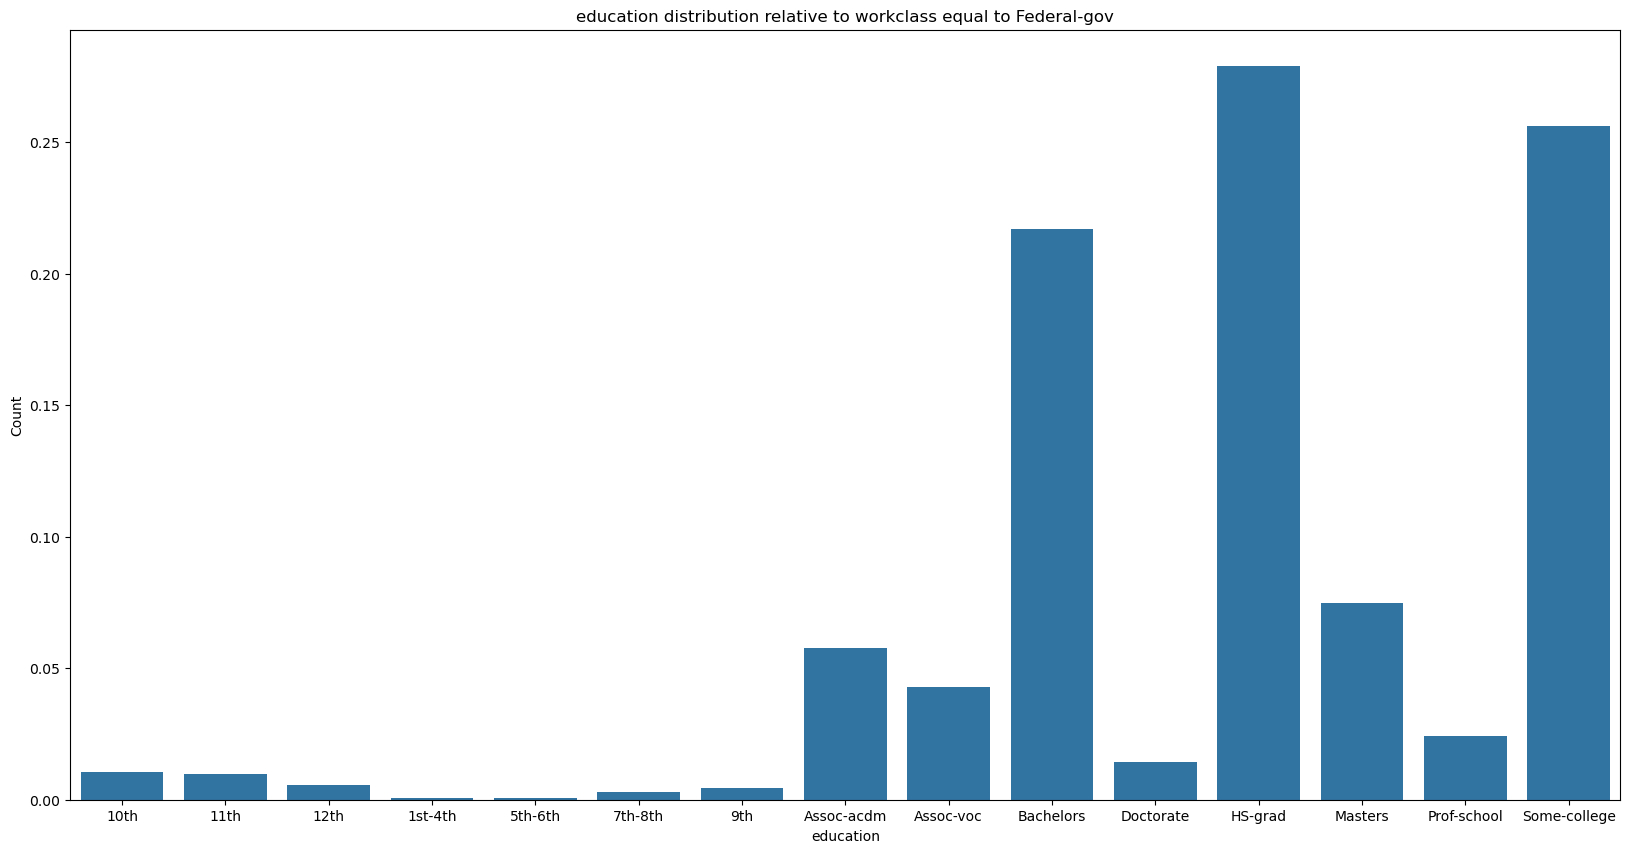

In [227]:
plot_hist(adult_features, "education", "workclass", "Federal-gov")